In [412]:
import pandas as pd
import datetime
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas
import numpy as np

In [125]:
# Data frame for April,August
def get_data(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url))
    return pd.concat(dfs)


# weeks of April 2018 most month touris go to      
week_nums = [180414, 180421, 180428]
df = get_data(week_nums)

# weeks of August 2018
weeks_Aug18 = [180804, 180818, 180811]
df_aug18 = get_data(weeks_Aug18)

# weeks of April 2021
weeks_April21 = [210403, 210410, 210417]
df_april21 = get_data(weeks_April21)

# weeks of August 2021
weeks_Aug21 = [210807, 210814, 210821]
df_aug21 = get_data(weeks_Aug21)

In [127]:
# to concat multiple DF
pdList = [df, df_aug18, df_april21, df_aug21]  # List of your dataframes
new_df = pd.concat(pdList)

In [128]:
new_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/07/2018,00:00:00,REGULAR,6573108,2226461
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/07/2018,04:00:00,REGULAR,6573129,2226465
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/07/2018,08:00:00,REGULAR,6573139,2226495
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/07/2018,12:00:00,REGULAR,6573211,2226561
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/07/2018,16:00:00,REGULAR,6573425,2226604


In [129]:
# check the concat is working Usnig .shape
new_df.shape

(2436813, 11)

In [184]:
# Creating New column Date_Time
new_df["DATE_TIME"] = pd.to_datetime(new_df.DATE + " " + new_df.TIME, 
                                            format="%m/%d/%Y %H:%M:%S")

In [132]:
new_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/07/2018,00:00:00,REGULAR,6573108,2226461,2018-04-07 00:00:00
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/07/2018,04:00:00,REGULAR,6573129,2226465,2018-04-07 04:00:00
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/07/2018,08:00:00,REGULAR,6573139,2226495,2018-04-07 08:00:00
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/07/2018,12:00:00,REGULAR,6573211,2226561,2018-04-07 12:00:00
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/07/2018,16:00:00,REGULAR,6573425,2226604,2018-04-07 16:00:00


In [134]:
# remove space
new_df.columns = [column.strip() for column in new_df.columns]

In [135]:
# to check if we have dublicate value
(new_df
 .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)).head(5)

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES
649257,N071,R013,00-00-01,34 ST-PENN STA,2021-04-08 08:00:00,2
650267,N071,R013,00-00-03,34 ST-PENN STA,2021-04-08 08:00:00,2
2214897,R523,R147,00-00-07,61 ST WOODSIDE,2021-08-18 05:00:00,2
2190696,R515,R095,00-00-00,ASTORIA DITMARS,2018-08-07 20:00:00,2
2191203,R515,R095,00-00-01,ASTORIA DITMARS,2018-08-07 16:00:00,2


In [137]:
# remove the duplicate entry
new_df.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], 
                          inplace=True, ascending=False)
new_df.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True)

In [143]:
daily_df = (new_df
                        .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE","DATE_TIME"],as_index=False)
                        .ENTRIES.first())

In [144]:
daily_df[["PREV_DATE", "PREV_ENTRIES"]] = (daily_df.groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", "ENTRIES"].apply(lambda grp: grp.shift(1)))

<ipython-input-144-3570f5d86822>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  daily_df[["PREV_DATE", "PREV_ENTRIES"]] = (daily_df.groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", "ENTRIES"].apply(lambda grp: grp.shift(1)))


In [145]:
daily_df.head()

,C/A,UNIT,SCP,STATION,DATE,DATE_TIME,ENTRIES,PREV_DATE,PREV_ENTRIES
0,A002,R051,02-00-00,59 ST,03/27/2021,2021-03-27 00:00:00,7550517,NaN,NaN
1,A002,R051,02-00-00,59 ST,03/27/2021,2021-03-27 04:00:00,7550517,03/27/2021,7550517.0
2,A002,R051,02-00-00,59 ST,03/27/2021,2021-03-27 08:00:00,7550517,03/27/2021,7550517.0
3,A002,R051,02-00-00,59 ST,03/27/2021,2021-03-27 12:00:00,7550517,03/27/2021,7550517.0
4,A002,R051,02-00-00,59 ST,03/27/2021,2021-03-27 16:00:00,7550517,03/27/2021,7550517.0


In [146]:
# remove the first row 
daily_df.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

In [147]:
# function to counr the daily visitors
def get_daily_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        print(row["ENTRIES"], row["PREV_ENTRIES"])
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter
daily_df["DAILY_ENTRIES"] = daily_df.apply(get_daily_counts, axis=1, max_counter=1000000)

5731362 6528.0
6598 5731945.0
5732081 6995.0
7060 5732548.0
5732644 7385.0
7452 5733740.0
5733915 7851.0
7930 5735027.0
5735253 8189.0
8255 5736378.0
5736564 8325.0
8336 5737635.0
5737834 8678.0
8749 5738939.0
5739153 9096.0
9162 5739836.0
5739970 9489.0
9561 5740462.0
5740568 9914.0
9992 5741501.0
5741674 10392.0
53272 5860570.0
5860779 53497.0
53585 5861842.0
5862047 53789.0
53851 5863128.0
5863336 54220.0
54302 5864390.0
5864599 54762.0
54844 5865176.0
5865324 55227.0
55311 5865762.0
5865892 55755.0
55849 5866941.0
5867160 56242.0
56315 5868277.0
5868479 56600.0
56662 5869475.0
5869683 56833.0
56897 5870746.0
5870966 57311.0
57372 5872035.0
5872266 57793.0
57853 5872821.0
5872981 58305.0
58398 5873509.0
5873662 58845.0
58939 5874715.0
5874925 59331.0
59408 5876089.0
5876348 59651.0
59721 5877495.0
5877758 59936.0
59988 5878827.0
5879047 60419.0
60491 5880063.0
10723562 12128411.0
12128510 10724547.0
10724771 12129178.0
12129270 10725533.0
10725684 12129922.0
12130025 10727435.0
1072

754850 3393012.0
3393064 754968.0
754973 3393740.0
3393782 755123.0
755130 3394671.0
3394724 755261.0
755262 3395036.0
3395061 755421.0
755423 3395546.0
3395569 755570.0
755575 3395972.0
3396007 755747.0
755754 3396603.0
3396622 755938.0
755948 3397414.0
3397458 756121.0
756130 3398112.0
3398138 756303.0
756312 3398817.0
6773159 87035.0
87052 6774409.0
6774487 87447.0
87460 6775420.0
6775449 87856.0
87878 6776741.0
6776794 88231.0
88252 6778095.0
6778140 88546.0
88560 6779537.0
6779576 88687.0
88693 6781068.0
6781124 88983.0
88997 6782940.0
6783069 89333.0
89352 6785180.0
6785269 89695.0
89714 6786294.0
6786329 90057.0
90075 6787432.0
6787480 90389.0
135281 6950230.0
6950293 135736.0
135771 6952018.0
6952109 136125.0
136144 6953889.0
6953956 136589.0
136619 6955714.0
6955811 137099.0
137147 6956833.0
6956919 137621.0
137669 6958116.0
6958167 138127.0
138164 6959875.0
6959962 138619.0
138646 6961754.0
6961820 139093.0
139118 6963723.0
6963818 139473.0
139493 6965745.0
6965858 139970.0
1

1562203490 730519.0
730557 1562205439.0
1562205809 730647.0
730677 1562207714.0
1562208148 730826.0
730871 1562210117.0
1562210559 731007.0
731044 1562211882.0
1562212284 731194.0
731226 1562213417.0
1562213620 731386.0
731411 1562215766.0
1562216088 731559.0
755220 1562388231.0
1562388514 755459.0
755513 1562390257.0
1562390530 755674.0
755714 1562392215.0
1562392497 755885.0
755924 1562394084.0
1562394311 756108.0
756167 1562395079.0
1562395267 756373.0
756420 1562395931.0
1562396090 756640.0
756704 1562397797.0
1562398039 756902.0
756966 1562399801.0
1562400052 757168.0
757223 1562401758.0
1562402069 757415.0
757453 1562403813.0
1562404091 757647.0
757684 1562405663.0
1562405879 757903.0
757953 1562406487.0
1562406633 758163.0
758219 1562407151.0
1562407293 758469.0
758547 1562408824.0
1562409045 758805.0
758875 1562410668.0
1562410940 759064.0
759127 1562412616.0
1562412867 759278.0
759322 1562414519.0
1562414779 759536.0
759586 1562416340.0
1662492460 1095587.0
1095627 1662493386.

10069241 8048338.0
8048930 10069665.0
10069757 8052187.0
8052793 10070891.0
10071045 8055678.0
2523620 4151848.0
4151896 2524401.0
2524626 4152363.0
4152406 2525173.0
2525279 4152929.0
4152973 2527652.0
2527962 4153491.0
4153546 2530361.0
2530713 4153750.0
4153798 2533211.0
2533557 4153922.0
4153942 2535994.0
2536317 4154437.0
4154483 2538453.0
2538771 4155011.0
4155063 2539684.0
2539923 4155592.0
4155632 2540528.0
2540601 4156146.0
4156185 2542661.0
2542965 4156683.0
4218508 2773882.0
2774249 4218868.0
4218952 2776678.0
2777037 4219200.0
4219248 2779459.0
2779789 4219969.0
4220056 2782063.0
2782390 4220849.0
4220930 2783113.0
2783337 4221677.0
4221764 2783957.0
2784100 4222490.0
4222603 2786536.0
2786875 4223196.0
4223289 2789376.0
2789686 4223637.0
4223709 2792250.0
2792575 4223965.0
4224004 2795053.0
2795403 4224684.0
4224767 2797598.0
2797886 4225523.0
4225602 2798612.0
2798777 4226351.0
4226461 2799381.0
2799504 4227167.0
4227262 2801721.0
2802046 4227887.0
4227969 2804429.0
28047

15121901 12463254.0
12463749 15122474.0
15122638 12467219.0
12467763 15122981.0
15123047 12471301.0
12471828 15123922.0
15124005 12475302.0
12476013 15124978.0
15125094 12477821.0
12478214 15125981.0
15126116 12479480.0
12479698 15126929.0
15127043 12483056.0
12483533 15127972.0
15242428 12841305.0
12841882 15243158.0
15243340 12845422.0
12846064 15243879.0
15244003 12849847.0
12850439 15245075.0
15245218 12853747.0
12854311 15246512.0
15246653 12855809.0
12856243 15247869.0
15248022 12857703.0
12858106 15249198.0
15249389 12861638.0
12862146 15250495.0
15250703 12865788.0
12866378 15251432.0
15251616 12870117.0
12870708 15252213.0
15252319 12874371.0
12875023 15253407.0
15253549 12878588.0
12879193 15254737.0
15254880 12880484.0
12880865 15256106.0
15256283 12882197.0
12882547 15257466.0
15257631 12885872.0
12886295 15258690.0
15258907 12889722.0
12890239 15259582.0
15259779 12893624.0
12894205 15260376.0
15260507 12897659.0
12898217 15261567.0
15261702 12901378.0
6612510 9000253.0
90

5865380 6865399.0
9049192 10473526.0
10473568 9050077.0
9050274 10473783.0
10473819 9050987.0
9051135 10474040.0
10474083 9053080.0
9053428 10474322.0
10474371 9055488.0
9055897 10474607.0
10474658 9057761.0
9058057 10474763.0
10474792 9060167.0
9060555 10474977.0
10474996 9062406.0
9062839 10475231.0
10475262 9063948.0
9064183 10475494.0
10475528 9064963.0
9065064 10475720.0
10475751 9066732.0
9067102 10475992.0
10511999 9273625.0
9274078 10512337.0
10512425 9276551.0
9277041 10512628.0
10512666 9279484.0
9279936 10513009.0
10513069 9282065.0
9282465 10513427.0
10513490 9283443.0
9283735 10513823.0
10513945 9284649.0
9284891 10514312.0
10514407 9287156.0
9287535 10514780.0
10514870 9289943.0
9290353 10515193.0
10515259 9292781.0
9293207 10515536.0
10515585 9295595.0
9296098 10515877.0
10515946 9298097.0
9298435 10516321.0
10516369 9299289.0
9299515 10516710.0
10516794 9300286.0
9300450 10517137.0
10517189 9302586.0
9302928 10517511.0
10517580 9305163.0
9305559 10517920.0
10518018 9307

225097 14856271.0
69748480 71279230.0
71279268 69749357.0
69749512 71279603.0
71279637 69750260.0
69750365 71279984.0
71280012 69752719.0
69752967 71280375.0
71280421 69755306.0
69755571 71280609.0
71280646 69758032.0
69758340 71280771.0
71280798 69760771.0
69761174 71281132.0
71281159 69763493.0
69763801 71281546.0
71281577 69764980.0
69765138 71281975.0
71282016 69765916.0
69766002 71282362.0
71282394 69768366.0
69768609 71282758.0
71323505 69992845.0
69993109 71323767.0
71323801 69995425.0
69995692 71323933.0
71323961 69997971.0
69998279 71324349.0
71324388 70000277.0
70000511 71324775.0
71324818 70001346.0
70001485 71325311.0
71325364 70002156.0
70002268 71325791.0
71325835 70004458.0
70004681 71326267.0
71326312 70007040.0
70007279 71326570.0
71326605 70009589.0
70009878 71326776.0
71326793 70012145.0
70012483 71327224.0
71327259 70014527.0
70014766 71327722.0
71327770 70015429.0
70015541 71328214.0
71328263 70016164.0
70016283 71328688.0
71328751 70018253.0
70018456 71329137.0
71

5009546 3867121.0
3867372 5009886.0
5010013 3868998.0
3869348 5010328.0
5010451 3870905.0
3871253 5010728.0
5010820 3872836.0
3873197 5011095.0
5011167 3874768.0
3875134 5011453.0
5011531 3876025.0
3876358 5011851.0
5011933 3877171.0
3877442 5012253.0
5012351 3878773.0
3879048 5012684.0
5012802 3880549.0
3880863 5013140.0
5013296 3882376.0
3882692 5013595.0
5013698 3884504.0
3884869 5014001.0
5014073 3886296.0
17 106993519.0
1150835 12036.0
12062 1151212.0
1151355 12161.0
12182 1151695.0
1151784 12244.0
12313 1152275.0
1152374 12431.0
12455 1152915.0
1153026 12587.0
12641 1153578.0
1153709 12744.0
12768 1154241.0
1154370 12876.0
12888 1154875.0
1155091 12999.0
13024 1155760.0
1155960 13127.0
13159 1156361.0
1156478 13272.0
13289 1157039.0
1157156 13412.0
33804 1225304.0
1225418 34002.0
34063 1225977.0
1226068 34243.0
34295 1226629.0
1226751 34410.0
34442 1227314.0
1227467 34587.0
34616 1227950.0
1228117 34765.0
34791 1228553.0
1228689 34926.0
34967 1229250.0
1229353 35097.0
35150 12299

3055122 4183820.0
4183841 3056136.0
3056276 4184108.0
4184128 3056996.0
3057051 4184408.0
4184446 3058155.0
3058227 4184748.0
4184799 3059326.0
3059405 4185093.0
4185139 3060613.0
3060719 4185318.0
4185331 3062016.0
3062137 4185557.0
4185568 3063516.0
3063726 4185869.0
4185890 3065212.0
3065363 4186190.0
4186228 3066210.0
3066262 4186469.0
4186504 3067373.0
3067405 4186845.0
4234002 3212738.0
3212894 4234573.0
4234664 3214160.0
3214300 4235039.0
4235076 3215636.0
3215789 4235538.0
4235576 3217282.0
3217457 4236042.0
4236090 3218529.0
3218695 4236521.0
4236594 3219680.0
3219800 4237050.0
4237104 3221073.0
3221194 4237548.0
4237645 3222541.0
3222741 4238149.0
4238209 3224136.0
3224272 4238602.0
4238644 3225621.0
3225827 4239103.0
4239137 3227265.0
3227430 4239541.0
4239576 3228596.0
3228766 4239975.0
4240012 3229827.0
3229948 4240424.0
4240504 3231060.0
3231166 4240970.0
4241048 3232518.0
3232641 4241501.0
4241566 3233987.0
3234128 4241971.0
4242029 3235491.0
3235657 4242469.0
4242504 32

3838996 1945.0
1950 3839085.0
3839091 1965.0
1968 3839153.0
3839156 1981.0
1984 3839321.0
3839325 2000.0
2003 3839497.0
3839505 2024.0
2026 3839675.0
3839687 2032.0
2034 3839852.0
3839859 2055.0
2058 3840050.0
3840064 2077.0
2084 3840203.0
3840205 2101.0
2104 3840287.0
3840294 2120.0
2123 3840439.0
3840450 2152.0
6094 3860947.0
3860963 6144.0
6149 3861202.0
3861225 6186.0
6187 3861462.0
3861494 6245.0
6250 3861678.0
3861707 6277.0
6278 3861885.0
3861901 6319.0
6323 3862048.0
3862063 6358.0
6363 3862292.0
3862303 6412.0
6415 3862556.0
3862582 6441.0
6449 3862787.0
3862796 6474.0
6475 3863021.0
3863049 6509.0
6517 3863250.0
3863270 6553.0
6554 3863429.0
3863452 6594.0
6596 3863631.0
3863640 6622.0
6625 3863841.0
3863853 6656.0
6661 3864071.0
3864088 6695.0
6700 3864301.0
3864310 6722.0
6724 3864543.0
3864573 6758.0
6760 3864805.0
6523316 10015.0
10017 6523529.0
6523546 10050.0
10052 6523740.0
6523741 10083.0
10085 6524042.0
6524048 10118.0
10120 6524384.0
6524397 10152.0
10156 6524744.0


3958754 44780.0
44810 3959491.0
3959675 44981.0
45019 3960294.0
3960419 45202.0
45251 3961105.0
3961236 45444.0
45499 3961880.0
3962067 45729.0
45788 3962802.0
3962999 45926.0
45953 3963701.0
3963877 46099.0
46115 3964652.0
3965050 46283.0
46303 3966186.0
3966483 46474.0
46495 3967343.0
3967502 46653.0
46668 3968173.0
3968352 46861.0
75086 4072862.0
4073088 75332.0
75406 4073865.0
4074130 75626.0
75670 4074925.0
4075145 75875.0
75924 4075941.0
4076236 76146.0
76204 4077092.0
4077379 76432.0
76510 4078155.0
4078339 76756.0
76833 4079114.0
4079327 77073.0
77140 4080124.0
4080338 77458.0
77540 4081113.0
4081355 77783.0
77828 4082098.0
4082347 78065.0
78115 4083117.0
4083345 78299.0
78373 4084023.0
4084233 78587.0
78647 4084936.0
4085108 78859.0
78941 4085836.0
4086043 79161.0
79232 4086864.0
4087092 79525.0
79619 4087903.0
4088166 79893.0
79941 4088999.0
4089331 80143.0
80187 4090126.0
5906486 7050706.0
7050787 5907516.0
5907819 7051167.0
7051250 5908716.0
5908972 7051601.0
7051724 591009

4091066 311965.0
311979 4091155.0
4091173 312065.0
312076 4091247.0
4091257 312186.0
312196 4091732.0
4091773 312286.0
312294 4092247.0
4092283 312337.0
312342 4092756.0
4092791 312364.0
312365 4093248.0
4093288 312477.0
312479 4093688.0
4093738 312593.0
312596 4093888.0
4093900 312686.0
312689 4093974.0
4093984 312811.0
312814 4094500.0
4094537 312871.0
24784 4099902.0
1679135 460007.0
460027 1679334.0
1679363 460345.0
460371 1679493.0
1679516 460674.0
460698 1680682.0
1680744 460958.0
460985 1681906.0
1681986 461084.0
461104 1683171.0
1683243 461171.0
461182 1684439.0
1684525 461435.0
461443 1685623.0
1685712 461722.0
461736 1685956.0
1686007 462013.0
462027 1686130.0
1686155 462292.0
462298 1687196.0
1687280 462661.0
493250 1789573.0
1789670 493407.0
493422 1791042.0
1791127 493523.0
493542 1792400.0
1792489 493937.0
493966 1793547.0
1793640 494404.0
494435 1793899.0
1793954 494853.0
494876 1794256.0
1794309 495290.0
495329 1796028.0
1796115 495699.0
495741 1797914.0
1798014 495904.

1824603 218846.0
218865 1825099.0
1825175 219209.0
219234 1825532.0
1825565 219606.0
219628 1826396.0
1826441 220006.0
220021 1827427.0
1827476 220292.0
220312 1828429.0
1828485 220477.0
220489 1829493.0
1829535 220774.0
220790 1830392.0
1830446 221169.0
221188 1831089.0
1831157 221569.0
221583 1831562.0
1831604 221926.0
221939 1832482.0
1832524 222324.0
260755 1919170.0
1919223 261035.0
261082 1919992.0
1920034 261316.0
261338 1920887.0
1920941 261709.0
261750 1921670.0
1921730 262161.0
262189 1922201.0
1922271 262604.0
262622 1922770.0
1922831 263000.0
263026 1923648.0
1923707 263415.0
263455 1924482.0
1924530 263690.0
263719 1925408.0
1925457 263904.0
263921 1926281.0
1926349 264282.0
264303 1927118.0
1927187 264669.0
264682 1927586.0
1927646 265067.0
265088 1928077.0
1928130 265510.0
265531 1928834.0
1928891 265881.0
265914 1929671.0
1929717 266201.0
266236 1930509.0
1930554 266476.0
266498 1931350.0
1931414 266855.0
266882 1932158.0
10596749 11646166.0
11646209 10597600.0
10597700

1400021 46231.0
46231 1400021.0
3082637 247401.0
247401 3082888.0
3082908 247401.0
247401 3083162.0
3083172 247401.0
247401 3083943.0
3084000 247402.0
247402 3084711.0
3084790 247402.0
247402 3085365.0
3085394 247403.0
247403 3086147.0
3086224 247457.0
247457 3086780.0
3086803 247534.0
247540 3087091.0
3087115 247627.0
247630 3087309.0
3087323 247714.0
247717 3088013.0
3088079 247818.0
13654 3143526.0
3143546 13759.0
13767 3143958.0
3143979 13831.0
13839 3144332.0
3144349 13981.0
13983 3144637.0
3144648 14129.0
14133 3144648.0
90504 1400020.0
9684150 355739.0
355765 9684574.0
9684624 356170.0
356196 9685025.0
9685064 356628.0
356667 9685871.0
9685924 357049.0
357066 9686769.0
9686831 357330.0
357355 9687615.0
9687658 357550.0
357574 9688465.0
9688530 357980.0
358008 9689333.0
9689373 358397.0
358424 9689857.0
9689896 358843.0
358873 9690337.0
9690374 359231.0
359265 9691112.0
9691157 359644.0
397645 9770269.0
9770323 397900.0
397926 9771098.0
9771139 398167.0
398200 9771934.0
9772006 3

229572623 262152.0
262152 229572623.0
229572623 262152.0
262152 229572623.0
229572623 262152.0
262152 229572623.0
229572623 262152.0
262152 229572623.0
229572623 262152.0
262152 229572623.0
229572623 262152.0
262152 229572623.0
229572623 262152.0
262152 229572623.0
761571 1784705.0
1784728 762186.0
762226 1785382.0
1785407 762701.0
762741 1786000.0
1786022 764418.0
764458 1786601.0
1786627 766157.0
766209 1786914.0
1786938 767971.0
768030 1787146.0
1787159 769873.0
769922 1787746.0
1787773 771627.0
771689 1788412.0
1788441 772338.0
772390 1789054.0
1789076 772877.0
772907 1789675.0
1789712 774507.0
774550 1790325.0
2925047 4311994.0
4312041 2925781.0
2925826 4312926.0
4312966 2926449.0
2926496 4313802.0
4313849 2928638.0
2928699 4314693.0
4314736 2930866.0
2930950 4315104.0
4315145 2933116.0
2933194 4315409.0
4315431 2935399.0
2935475 4316250.0
4316293 2937682.0
2937777 4317210.0
4317249 2938657.0
2938738 4318131.0
4318171 2939349.0
2939397 4318956.0
4319001 2941378.0
2941455 4319889.0

10715017 11851361.0
11851398 10715801.0
10715939 11852008.0
11852053 10717023.0
10717220 11852547.0
11852587 10718671.0
10718808 11853280.0
11853351 10720299.0
10720430 11853817.0
11853856 10721823.0
10721945 11854189.0
11854222 10723335.0
10723484 11854778.0
11854823 10724963.0
10725066 11855489.0
11855512 10725728.0
10725813 11856181.0
11856246 10726534.0
10726635 11856945.0
11857003 10727910.0
10727995 11857692.0
11857757 10729273.0
10729365 11858155.0
11858209 10730704.0
10730846 11858676.0
11858727 10732275.0
10732423 11859332.0
11859373 10733763.0
14393478 16294068.0
16294139 14394671.0
14394846 16295266.0
16295332 14395906.0
14396031 16296492.0
16296582 14398658.0
14398917 16297681.0
16297770 14401734.0
14401982 16298456.0
16298527 14404817.0
14405071 16299049.0
16299103 14407980.0
14408244 16300190.0
16300268 14410650.0
14410851 16301381.0
16301446 14412347.0
14412502 16302668.0
16302741 14413452.0
14413549 16303856.0
16303928 14416134.0
14416395 16305059.0
16417363 14665965.0


5016372 51525.0
51582 5016372.0
5016372 52052.0
52105 5017601.0
5017716 52587.0
52629 5017716.0
5017716 52901.0
52942 5017716.0
5017716 53125.0
53159 5017716.0
5017716 53540.0
53575 5017716.0
5017716 54033.0
54073 5017716.0
5017716 54580.0
54631 5018296.0
5018359 55119.0
55159 5019941.0
5020062 55686.0
23725 5041177.0
3343923 190016.0
190061 3345633.0
3345819 190823.0
190884 3347269.0
3347412 191713.0
191772 3351167.0
3351471 192577.0
192640 3354936.0
3355272 193185.0
193258 3359254.0
3359557 193613.0
193638 3363423.0
3363731 194361.0
194399 3367368.0
3367664 195195.0
195244 3369628.0
3369899 196053.0
196103 3371428.0
3371552 196866.0
196925 3375333.0
3375665 197732.0
271815 3727042.0
3727340 272389.0
272463 3731024.0
3731308 272907.0
272960 3734800.0
3735066 273862.0
273912 3738346.0
3738640 274871.0
274947 3740309.0
3740550 275944.0
276019 3742022.0
3742169 277022.0
277110 3745392.0
3745630 278089.0
278178 3749099.0
3749345 278777.0
278846 3752823.0
3753081 279331.0
279387 3756600.0


4109409 5141998.0
5142034 4110169.0
4110242 5142509.0
5142541 4110831.0
4110885 5142989.0
5143037 4112300.0
4112361 5143503.0
5143550 4113844.0
4113926 5143836.0
5143876 4115386.0
4115456 5144080.0
5144106 4116905.0
4116968 5144531.0
5144561 4118395.0
4118440 5145018.0
5145054 4118440.0
4118440 5145520.0
5145551 4118440.0
4118440 5145980.0
5146021 4119840.0
4119894 5146496.0
10446762 11710483.0
11710540 10447661.0
10447772 11711290.0
11711341 10448484.0
10448554 11712081.0
11712132 10450174.0
10450274 11712857.0
11712914 10452013.0
10452116 11713470.0
11713522 10453832.0
10453949 11713903.0
11713939 10455706.0
10455814 11714627.0
11714685 10457590.0
10457673 11715434.0
11715488 10457673.0
10457673 11716220.0
11716282 10457673.0
10457673 11716995.0
11717050 10459246.0
10459345 11717785.0
11795440 10616392.0
10616470 11795977.0
11796034 10618062.0
10618169 11796462.0
11796520 10619872.0
10619989 11797200.0
11797257 10621551.0
10621668 11798021.0
11798098 10622432.0
10622546 11798892.0
11

8090189 9481525.0
9481578 8091791.0
8091917 9482395.0
9482428 8093156.0
8093247 9483234.0
9483275 8095476.0
8095609 9484115.0
9484163 8098023.0
8098162 9484767.0
9484809 8100702.0
8100836 9485234.0
9485265 8103331.0
8103473 9486014.0
9486058 8105991.0
8106168 9486944.0
9486987 8108154.0
8108313 9487890.0
9487934 8109722.0
8109814 9488708.0
9488747 8111947.0
8112061 9489629.0
9574498 8352140.0
8352265 9575132.0
9575189 8354405.0
8354554 9575736.0
9575762 8356717.0
8356842 9576640.0
9576690 8358898.0
8359060 9577644.0
9577695 8361972.0
8362216 9578666.0
9578709 8364492.0
8364670 9579616.0
9579660 8366768.0
8366898 9580534.0
9580593 8368927.0
8369041 9581324.0
9581372 8370965.0
8371096 9581894.0
9581929 8373124.0
8373258 9582790.0
9582843 8375232.0
8375380 9583598.0
9583634 8376602.0
8376702 9584533.0
9584577 8377794.0
8377867 9585425.0
9585467 8379608.0
8379721 9586389.0
9586463 8381619.0
8381720 9587121.0
9587163 8383722.0
8383835 9587726.0
9587762 8385678.0
8385803 9588619.0
9588661 83

448131 117716611.0
117716647 448283.0
448314 117717498.0
117717537 448451.0
448471 117718382.0
117718427 448729.0
448745 117719263.0
117719305 449065.0
449085 117719710.0
117719751 449352.0
449372 117720009.0
117720031 449640.0
449663 117720923.0
117720961 449930.0
475599 117793967.0
117793998 475738.0
475757 117794754.0
117794783 475847.0
475853 117795417.0
117795441 476079.0
476094 117796055.0
117796096 476331.0
476349 117796383.0
117796428 476585.0
476608 117796697.0
117796722 476859.0
476878 117797365.0
117797403 477091.0
477112 117798136.0
117798170 477239.0
477265 117798887.0
117798921 477375.0
477388 117799641.0
117799683 477612.0
477635 117800337.0
117800379 477863.0
477877 117800684.0
117800722 478109.0
478126 117800969.0
117800997 478361.0
478382 117801674.0
117801700 478621.0
478642 117802408.0
117802441 478773.0
478786 117803154.0
117803187 478909.0
478928 117803859.0
117803896 479149.0
479158 117804516.0
153127367 154156532.0
154156554 153128081.0
153128138 154157063.0
154

776200558 875206224.0
875206216 776199170.0
776199144 875205798.0
875205792 776198070.0
776198028 875205385.0
875205379 776195533.0
776195503 875204993.0
875204983 776193009.0
776192975 875204629.0
875204622 776190483.0
776190453 875204369.0
875204359 776187880.0
776187849 875203974.0
875203969 776185248.0
776185215 875203534.0
875203530 776183505.0
776183473 875203082.0
875203074 776182379.0
776182352 875202595.0
875202588 776179914.0
776179885 875202132.0
875153511 775928534.0
775928488 875153059.0
875153053 775925980.0
775925945 875152701.0
875152694 775923413.0
775923376 875152210.0
875152200 775920973.0
775920954 875151743.0
875151741 775920954.0
775920954 875151270.0
875151266 775920954.0
775920954 875150830.0
875150825 775918569.0
775918542 875150345.0
875150340 775916132.0
775916110 875149979.0
875149970 775913557.0
775913526 875149697.0
875149693 775911102.0
775911064 875149209.0
875149204 775908603.0
775908557 875148708.0
875148700 775907006.0
775906966 875148173.0
875148165 

302142 3809529.0
3809570 303086.0
303137 3811446.0
3811585 304067.0
304118 3813559.0
3813715 304777.0
304823 3815686.0
3815832 305381.0
305416 3817854.0
3817980 306448.0
306488 3819952.0
407684 1490038.0
1490067 408444.0
408520 1490644.0
1490678 409135.0
409192 1491353.0
1491377 410647.0
410715 1492002.0
1492029 412171.0
412247 1492447.0
1492465 413723.0
413777 1492806.0
1492828 415284.0
415345 1493392.0
1493415 416870.0
416946 1494055.0
1494088 417772.0
417852 1494743.0
1494766 418471.0
418515 1495348.0
1495373 419890.0
419951 1495992.0
13683368 15452201.0
15452234 13684748.0
13684834 15453305.0
15453342 13686031.0
13686104 15454495.0
15454531 13688442.0
13688513 15455624.0
15455651 13690649.0
13690730 15456418.0
15456442 13693172.0
13693234 15457003.0
15457025 13695595.0
13695666 15458095.0
15458130 13698080.0
13698162 15459325.0
15459354 13699730.0
13699797 15460539.0
15460564 13700987.0
13701042 15461665.0
15461700 13703207.0
13703279 15462775.0
15568327 13929833.0
13929890 1556912

3654746 1695516.0
1695587 3656034.0
3656168 1696964.0
1697037 3658603.0
3658716 1698091.0
1698149 3661179.0
3661327 1698939.0
1698986 3663789.0
3663929 1699718.0
1699774 3666481.0
3666617 1701002.0
1701065 3669098.0
3669276 1702309.0
1702369 3671074.0
3671228 1703775.0
1703852 3672452.0
3672547 1705115.0
1705180 3674628.0
3674766 1706580.0
1843733 3909056.0
3909202 1844706.0
1844808 3911322.0
3911479 1845613.0
1845692 3913580.0
3913766 1847077.0
1847156 3915826.0
3916047 1848476.0
1848570 3917472.0
3917633 1849697.0
1849783 3918949.0
3919162 1851207.0
1851282 3921261.0
3921424 1852656.0
1852748 3923476.0
3923580 1853719.0
1853819 3925660.0
3925801 1854597.0
1854657 3927815.0
3927990 1855941.0
1856040 3930135.0
3930344 1857345.0
1857406 3931708.0
3931858 1858787.0
1858864 3933294.0
3933461 1860248.0
1860328 3935303.0
3935418 1861555.0
1861664 3937414.0
3937573 1862570.0
1862672 3939613.0
3939769 1863480.0
1863544 3941811.0
3942001 1863547.0
1863547 3944107.0
4976734 106673.0
106820 4979

2804136 265986.0
266023 2804705.0
2804899 266109.0
266124 2805286.0
2805356 266268.0
266308 2805744.0
2805841 266438.0
266474 2806285.0
2806404 266597.0
266640 2806885.0
2807053 266704.0
266722 2807574.0
2807759 266820.0
266831 2808293.0
2808562 266915.0
266939 2809288.0
2809525 266969.0
266992 2809908.0
2809976 267105.0
267127 2810388.0
2810483 267232.0
284472 2878428.0
2878569 284613.0
284679 2879024.0
2879192 284807.0
284824 2879638.0
2879800 284947.0
284970 2880289.0
2880478 285093.0
285130 2880923.0
2881037 285246.0
285269 2881392.0
2881458 285416.0
285453 2881889.0
2882011 285605.0
285659 2882427.0
2882563 285800.0
285857 2883023.0
2883180 285965.0
285983 2883630.0
2883815 286092.0
286110 2884329.0
2884456 286246.0
286276 2884456.0
2884456 286410.0
286442 2884456.0
2884456 286569.0
286617 2884790.0
2884886 286770.0
286816 2885254.0
2885380 286939.0
286987 2885820.0
2885944 287113.0
287138 2886387.0
2886534 287260.0
287280 2886985.0
846859 1898799.0
1899209 847354.0
847482 1900783

2086306 3392360.0
3392487 2086306.0
2086306 3393099.0
3393262 2086306.0
2086306 3393890.0
3394037 2088135.0
2088461 3394659.0
3394808 2090423.0
2090778 3395488.0
3395623 2092353.0
2092656 3396173.0
3396290 2094747.0
2095213 3396883.0
3396993 2097423.0
18848795 5278467.0
5278516 18850276.0
18850629 5278849.0
5278904 18851682.0
18851868 5279260.0
5279321 18852853.0
18853015 5279703.0
5279806 18853988.0
18854198 5280216.0
5280347 18855254.0
18855469 5280638.0
5280688 18856516.0
18856733 5280987.0
5281046 18857892.0
18858230 5281362.0
5281426 18860703.0
18861141 5281765.0
5281822 18862157.0
18862275 5282205.0
5282256 18863202.0
18863378 5282652.0
5341186 19060380.0
19060681 5341788.0
5341981 19061923.0
19062235 5342342.0
5342464 19063491.0
19063854 5342798.0
5342878 19065020.0
19065370 5343280.0
5343376 19066948.0
19067363 5343774.0
5343888 19068555.0
19068809 5344279.0
5344378 19069930.0
19070145 5344828.0
5344946 19071272.0
19071488 5345641.0
5345811 19072616.0
19072965 5346271.0
5346363

6584644 7938874.0
7938967 6586411.0
6586551 7939377.0
7939483 6588469.0
6588627 7939938.0
7940040 6590530.0
6590700 7940496.0
7940582 6592668.0
6592832 7941188.0
7941280 6594655.0
2305675 3510750.0
3510801 2307013.0
2307264 3511271.0
3511313 2308487.0
2308623 3511787.0
3511829 2310448.0
2310578 3512369.0
3512429 2312488.0
2312634 3512829.0
3512901 2314588.0
2314745 3513155.0
3513190 2316768.0
2316950 3513623.0
3513660 2319003.0
2319294 3514119.0
3514171 2320784.0
2321055 3514662.0
3514712 2322174.0
2322262 3515183.0
3515226 2324073.0
2324227 3515731.0
3579255 2513732.0
2513866 3579906.0
3580016 2515537.0
2515715 3580483.0
3580543 2517380.0
2517534 3581560.0
3581659 2519126.0
2519364 3582565.0
3582625 2520468.0
2520656 3583501.0
3583562 2521720.0
2521909 3584207.0
3584296 2523437.0
2523572 3585335.0
3585421 2525173.0
2525326 3585996.0
3586095 2526898.0
2527061 3586551.0
3586605 2528707.0
2528924 3587622.0
3587710 2530525.0
2530733 3588609.0
3588676 2530733.0
2530733 3589548.0
3589622 25

7952945 6558282.0
6558391 7953601.0
7953648 6560136.0
6560233 7954378.0
7954428 6562040.0
6562134 7954981.0
7955033 6563868.0
6563994 7955561.0
7955593 6565720.0
6565861 7956299.0
7956343 6567665.0
3127100 5417903.0
5417985 3129290.0
3129575 5419249.0
5419349 3131401.0
3131593 5421054.0
5421172 3134529.0
3134739 5422484.0
5422584 3137829.0
3138071 5423555.0
5423658 3141178.0
3141408 5424348.0
5424429 3144489.0
3144700 5425638.0
5425706 3147821.0
3148130 5426958.0
5427033 3150421.0
3150713 5428129.0
5428209 3152322.0
3152482 5429512.0
5429602 3155245.0
3155442 5430976.0
5553381 3462226.0
3462423 5554237.0
5554341 3465007.0
3465243 5554989.0
5555068 3467951.0
3468160 5556264.0
5556343 3470736.0
3470978 5557574.0
5557671 3472910.0
3473194 5558866.0
5558963 3474799.0
3474995 5560293.0
5560363 3477423.0
3477613 5561392.0
5561503 3480308.0
3480492 5562308.0
5562378 3483105.0
3483323 5563041.0
5563115 3486008.0
3486269 5564199.0
5564301 3488824.0
3489078 5565431.0
5565527 3490834.0
3490997 55

4033699 148469.0
160546 4090093.0
4090106 160673.0
160679 4090652.0
4090668 160752.0
160762 4091188.0
4091216 160944.0
160947 4091757.0
4091783 161119.0
161127 4092022.0
4092060 161343.0
161354 4092294.0
4092316 161576.0
161588 4092793.0
4092818 161809.0
161812 4093326.0
4093346 161937.0
161946 4093849.0
4093863 162018.0
162023 4094337.0
4094358 162154.0
162155 4094868.0
4094894 162393.0
162397 4095054.0
4095067 162615.0
162623 4095193.0
4095201 162834.0
162842 4095662.0
4095681 163043.0
163056 4096184.0
4096199 163200.0
163208 4096709.0
4096728 163291.0
163297 4097277.0
4097296 163476.0
163484 4097803.0
5905409 6925940.0
6925951 5906526.0
5906629 6926211.0
6926220 5907365.0
5907447 6926482.0
6926497 5908088.0
5908168 6926730.0
6926740 5909660.0
5909737 6926889.0
6926896 5911320.0
5911390 6926976.0
6926980 5912907.0
5912981 6927199.0
6927202 5914556.0
5914635 6927450.0
6927457 5915816.0
5915921 6927653.0
6927664 5916687.0
5916752 6927856.0
6927864 5918016.0
5918089 6928084.0
2618369 63

1900398 713035.0
748185 1930142.0
2273772 49980.0
49987 2273958.0
2273995 50186.0
50196 2274189.0
2274215 50414.0
50421 2274595.0
2274617 50620.0
50633 2274952.0
2274976 50724.0
50742 2275276.0
2275302 50824.0
50837 2275671.0
2275705 51066.0
51073 2276049.0
2276072 51288.0
51299 2276242.0
2276271 51506.0
51514 2276417.0
2276440 51702.0
51712 2276695.0
2276712 51909.0
71905 2316536.0
2316536 72006.0
72020 2316537.0
2316538 72093.0
72103 2316540.0
2316540 72292.0
72303 2316540.0
2316540 72505.0
72524 2316540.0
2316543 72714.0
72724 2316548.0
2316548 72934.0
72950 2316549.0
2316551 73166.0
73182 2316554.0
2316554 73279.0
73291 2316557.0
2316557 73367.0
73377 2316565.0
2316568 73539.0
73554 2316568.0
2316569 73740.0
73757 2316574.0
2316575 73975.0
73990 2316584.0
2316584 74250.0
74260 2316584.0
2316584 74429.0
74440 2316589.0
2316589 74527.0
74539 2316589.0
2316589 74629.0
74636 2316590.0
2316590 74837.0
74852 2316590.0
1616604 388838.0
388867 1616874.0
1616936 389098.0
389117 1617166.0
16

4358140 6352816.0
6352880 4360927.0
4361104 6354112.0
6354161 4362893.0
4363081 6355366.0
6355414 4364658.0
4364778 6356531.0
6356597 4367543.0
4367676 6357777.0
6357850 4370764.0
4370897 6358710.0
6358787 4373992.0
4374142 6359440.0
6359507 4377064.0
4377198 6360588.0
6360643 4379909.0
2206754 136018.0
136038 2208374.0
2208514 136533.0
136550 2209609.0
2209668 137050.0
137068 2211902.0
2211978 137592.0
137611 2214359.0
2214401 138017.0
138042 2216776.0
2216860 138299.0
138310 2219321.0
2219402 138783.0
138790 2221772.0
2221918 139316.0
139335 2223289.0
2223436 139884.0
139906 2224348.0
2224401 140485.0
140504 2226715.0
2226799 141034.0
194026 2500840.0
2501009 194420.0
194458 2504368.0
2504526 194721.0
194747 2508010.0
2508167 195278.0
195304 2511503.0
2511718 195830.0
195847 2513553.0
2513725 196406.0
196430 2515373.0
2515463 196979.0
197004 2518765.0
2518907 197593.0
197622 2522205.0
2522313 197994.0
198023 2525513.0
2525601 198263.0
198276 2527851.0
2527961 198839.0
198859 2530137.

5901311 203652.0
203668 5901574.0
5901590 204040.0
204050 5902321.0
5902346 204458.0
241780 5973211.0
5973213 241782.0
241782 5973250.0
5973251 241782.0
241786 5973290.0
5973290 242178.0
242192 5973331.0
5973333 242593.0
242609 5973333.0
5973333 243051.0
243066 5973333.0
5973334 243495.0
243504 5973396.0
5973397 243943.0
243956 5973427.0
5973428 243962.0
243962 5973460.0
5973463 243962.0
243964 5973494.0
5973497 244424.0
244442 5973542.0
5973544 244831.0
244840 5973544.0
5973544 245207.0
245219 5973544.0
5973544 245669.0
245689 5973594.0
5973595 246125.0
246138 5973626.0
5973628 246385.0
246400 5973672.0
5973673 246577.0
246583 5973713.0
5973714 247009.0
247025 5973761.0
1121183070 95130.0
95137 1121183070.0
1121183070 95316.0
95322 1121183070.0
1121183072 95483.0
95488 1121183387.0
1121183400 95627.0
95633 1121183727.0
1121183741 95741.0
95745 1121184043.0
1121184051 95816.0
95818 1121184386.0
1121184398 95979.0
95986 1121184734.0
1121184746 96149.0
96155 1121184972.0
1121184986 96328

12250348 13520654.0
13520684 12251584.0
12251676 13521229.0
13521246 12252395.0
12252425 13521842.0
13521860 12253977.0
12254026 13522468.0
13583235 12416648.0
12416712 13583740.0
13583784 12418234.0
12418282 13584150.0
13584173 12419867.0
12419929 13584749.0
13584775 12421411.0
12421500 13585374.0
13585402 12422504.0
12422600 13586009.0
13586048 12423520.0
12423590 13586720.0
13586762 12425036.0
12425096 13587469.0
13587511 12426685.0
12426736 13588006.0
13588046 12428200.0
12428273 13588427.0
13588459 12429751.0
12429838 13589058.0
13589083 12431395.0
12431493 13589631.0
13589657 12432391.0
12432460 13590256.0
13590284 12433353.0
12433451 13590872.0
13590903 12434766.0
12434826 13591492.0
13591537 12436273.0
12436326 13591995.0
13592036 12437848.0
12437902 13592385.0
13592409 12439435.0
12439523 13593013.0
13593048 12441236.0
6459848 8036349.0
8036405 6461006.0
6461079 8037202.0
8037240 6462045.0
6462103 8038084.0
8038124 6464129.0
6464177 8038896.0
8038940 6466313.0
6466357 8039539.

119527295 120673072.0
120673105 119528205.0
119528311 120673700.0
120673735 119529056.0
119529135 120674222.0
120674249 119530591.0
119530651 120675063.0
120675121 119532191.0
119532261 120675714.0
120675785 119533719.0
119533793 120676190.0
120676220 119535341.0
119535434 120676873.0
120676900 119537060.0
119537231 120677508.0
120677534 119538262.0
119538404 120678091.0
120678119 119539168.0
119539226 120678646.0
120678668 119540676.0
119540744 120679248.0
120734306 119673589.0
119673656 120734640.0
120734691 119675032.0
119675123 120735027.0
120735055 119676491.0
119676569 120735569.0
120735605 119677876.0
119677984 120736174.0
120736202 119678827.0
119678921 120736674.0
120736708 119679576.0
119679646 120737308.0
120737331 119680948.0
119681020 120737875.0
120737916 119682399.0
119682465 120738313.0
120738357 119683834.0
119683929 120738664.0
120738702 119685343.0
119685439 120739185.0
120739209 119686805.0
119686897 120739713.0
120739737 119687516.0
119687623 120740381.0
120740417 

10871659 12404245.0
12404304 10872965.0
10873112 12405193.0
12405276 10874986.0
10875186 12406169.0
12406242 10877277.0
10877438 12406835.0
12406905 10879492.0
10879698 12407345.0
12407389 10881766.0
10881974 12408212.0
12408296 10884059.0
10884281 12409109.0
12409172 10885572.0
10885745 12410025.0
12410093 10886963.0
10887119 12410888.0
12410956 10888978.0
10889114 12411776.0
12411855 10890226.0
10890847 12412476.0
12412554 10891256.0
10891435 12413011.0
12413095 10893454.0
10893636 12413863.0
12413919 10895655.0
19095673 21807680.0
21807799 19098248.0
19098606 21809246.0
21809389 19100699.0
19100938 21810818.0
21810970 19104192.0
19104500 21812474.0
21812639 19107884.0
19108216 21813945.0
21814105 19111725.0
19112051 21815002.0
21815101 19115568.0
19115913 21816427.0
21816541 19119310.0
19119700 21818043.0
21818193 19122174.0
19122488 21819689.0
21819835 19124325.0
19124497 21821224.0
21821351 19127378.0
19127677 21822836.0
21979167 19471131.0
19471390 21980368.0
21980517 19474382.0


15050893 13091992.0
13092347 15051765.0
15051880 13094638.0
13095196 15052943.0
15053084 13096786.0
13097175 15055119.0
15055446 13098667.0
13098959 15057538.0
15057879 13101101.0
13101436 15060086.0
15060475 13103371.0
13103733 15062044.0
15062357 13106481.0
13106954 15063602.0
15063826 13109342.0
13109716 15065857.0
15066151 13112087.0
13112476 15067340.0
15067495 13114022.0
13114352 15069636.0
15069935 13115853.0
13116114 15071999.0
15072337 13117992.0
13118306 15073991.0
15074154 13120643.0
13120997 15074980.0
15075139 13123277.0
13123756 15075797.0
15075906 13126118.0
13126567 15076894.0
15077034 13128853.0
17210289 20269814.0
20270033 17212921.0
17213508 20271615.0
20271840 17215871.0
17216379 20273453.0
20273676 17219793.0
17220387 20275273.0
20275513 17223945.0
17224548 20276648.0
20276882 17228183.0
17228917 20277683.0
20277817 17232468.0
17233263 20279254.0
20279430 17236957.0
17237625 20280983.0
20281101 17240268.0
17240878 20282783.0
20282949 17242816.0
17243115 20284444.0


8029583 73633.0
73659 8029822.0
8029856 74059.0
74084 8032116.0
8032239 74460.0
108072 8055542.0
6818660 183704.0
183775 6819875.0
6819961 184583.0
184649 6820823.0
6820886 185486.0
185556 6823188.0
6823285 186389.0
186460 6825791.0
6825902 186996.0
187057 6828426.0
6828527 187379.0
187418 6831041.0
6831174 188148.0
188197 6833653.0
6833784 189038.0
189105 6834443.0
6834498 190074.0
190136 6834951.0
6834976 190937.0
190989 6837495.0
6837591 191831.0
287263 7139606.0
7140032 287997.0
288157 7143918.0
7144263 288739.0
288792 7148081.0
7148485 289643.0
289784 7151913.0
7152316 290666.0
290823 7154276.0
7154631 291816.0
291980 7156234.0
7156539 292954.0
293128 7159784.0
7159968 294148.0
294309 7163608.0
7163923 294965.0
295109 7167319.0
7167717 295684.0
295731 7171307.0
7171690 296579.0
296744 7175118.0
7175342 297611.0
297703 7176224.0
7176346 298733.0
298844 7177119.0
7177226 299805.0
299948 7180727.0
7180907 300824.0
300992 7184386.0
7184645 301642.0
301789 7188271.0
7188517 302336.0
30

507168171 505997816.0
505997883 507168484.0
507168527 505998987.0
505999333 507168933.0
507222339 506166033.0
506166347 507222780.0
507222871 506167785.0
506168124 507223235.0
507223288 506169510.0
506169822 507223764.0
507223862 506171041.0
506171312 507224366.0
507224487 506172164.0
506172433 507225010.0
507225100 506173397.0
506173612 507225634.0
507225749 506174884.0
506175173 507226269.0
507226371 506176533.0
506176774 507226802.0
507226906 506178122.0
506178514 507227195.0
507227252 506179796.0
506180185 507227743.0
507227833 506181442.0
506181763 507228307.0
507228389 506182514.0
506182741 507228892.0
507228978 506183694.0
506183909 507229448.0
507229561 506184975.0
506185231 507230001.0
507230091 506186468.0
506186736 507230464.0
507230554 506188127.0
506188458 507230935.0
507231010 506189821.0
506190125 507231463.0
507231548 506191290.0
8382941 9669346.0
9669424 8383953.0
8384190 9669949.0
9670034 8385135.0
8385305 9670544.0
9670629 8386818.0
8387203 9671084.0
9671151 8388815.

13014627 14815151.0
14815248 13016237.0
13016647 14815837.0
14815935 13017875.0
13018125 14816507.0
14816593 13020131.0
13020563 14817144.0
14886408 13249920.0
13250324 14886834.0
14886946 13252202.0
13252610 14887310.0
14887384 13254512.0
13254910 14888043.0
14888148 13256700.0
13257075 14888769.0
14888896 13258182.0
13258469 14889553.0
14889688 13259466.0
13259717 14890354.0
14890474 13261635.0
13262007 14891087.0
14891235 13263879.0
13264224 14891673.0
14891788 13266185.0
13266634 14892168.0
14892252 13268633.0
13268989 14892857.0
14892959 13270728.0
13271062 14893633.0
14893763 13272093.0
13272344 14894418.0
14894545 13273447.0
13273696 14895213.0
14895338 13275603.0
13275936 14895946.0
14896086 13277948.0
13278353 14896511.0
14896609 13280263.0
13280661 14896990.0
14897085 13282584.0
13282990 14897701.0
14897814 13284690.0
6235404 8178534.0
8178602 6236984.0
6237400 8179136.0
8179207 6238685.0
6238927 8179741.0
8179835 6241367.0
6241809 8180414.0
8180522 6244233.0
6244749 8180906.

2221848 4531073.0
4531150 2224784.0
2225394 4531858.0
4531942 2228395.0
2229202 4532707.0
4532829 2231606.0
2232395 4533608.0
4533722 2234331.0
2234738 4534480.0
4534592 2237414.0
2237748 4535418.0
4646992 2582117.0
2582735 4647954.0
4648170 2585755.0
2586367 4649012.0
4649157 2589461.0
2590173 4650170.0
4650329 2593102.0
2593133 4651312.0
4651503 2593133.0
2593133 4652582.0
4652779 2593134.0
2593134 4653893.0
4654083 2593134.0
2593134 4655143.0
4655371 2593135.0
2593135 4656246.0
4656444 2595119.0
2595751 4657131.0
4657266 2598649.0
2599364 4658232.0
4658374 2602232.0
2602789 4659387.0
4659582 2604164.0
2604478 4660656.0
4660841 2605786.0
2606016 4661847.0
4662067 2608640.0
2609107 4663053.0
4663282 2611835.0
2612330 4664096.0
4664293 2615230.0
2615780 4665023.0
4665152 2618646.0
2619238 4666103.0
4666231 2622052.0
9144217 10633551.0
10633584 9145598.0
9146073 10633885.0
10633920 9147294.0
9147513 10634294.0
10634336 9149093.0
9149338 10634661.0
10634714 9150980.0
9151241 10634948.0
1

2882386 54590.0
54642 2883808.0
2884082 54847.0
54895 2885519.0
2885843 55083.0
55114 2887279.0
2887570 55389.0
55412 2888968.0
2889396 55639.0
55680 2890688.0
2891115 55927.0
55966 2892182.0
2892371 56239.0
56281 2893601.0
2893778 56557.0
94450 3051921.0
3052167 94802.0
94877 3053440.0
3053723 95143.0
95186 3055056.0
3055368 95559.0
95609 3056668.0
3057034 96046.0
96101 3058104.0
3058333 96488.0
96551 3058890.0
3058993 96960.0
97017 3059580.0
3059679 97429.0
97511 3060900.0
3061108 97853.0
97914 3062425.0
3062759 98216.0
98253 3064039.0
3064335 98588.0
98634 3065583.0
3065943 99006.0
99061 3067038.0
3067381 99474.0
99540 3068267.0
3068403 99910.0
99970 3069552.0
3069750 100367.0
100443 3071009.0
3071253 100820.0
100920 3072589.0
3072867 101317.0
101388 3074090.0
3074330 101904.0
101966 3075515.0
4118651 5597528.0
5597588 4120279.0
4120679 5597980.0
5598034 4122012.0
4122185 5598430.0
5598486 4123856.0
4124075 5598939.0
5599013 4125883.0
4126167 5599334.0
5599411 4128071.0
4128501 5599

9123329 10315110.0
10315126 9124551.0
9125006 10315319.0
10315340 9126082.0
9126234 10315522.0
10315556 9127375.0
9127535 10315781.0
10315820 9128589.0
9128868 10316019.0
10316076 9130050.0
9130207 10316160.0
10316184 9131986.0
9132393 10316357.0
10316367 9134439.0
9135224 10316540.0
10316559 9136885.0
9137386 10316752.0
10316776 9138552.0
9138730 10316937.0
10316952 9139800.0
9139972 10317180.0
10350587 9319569.0
9319861 10350948.0
10351028 9321212.0
9321555 10351320.0
10351353 9322931.0
9323259 10351665.0
10351699 9324708.0
9325131 10352040.0
10352081 9326493.0
9326941 10352456.0
10352497 9328311.0
9328595 10352857.0
10352917 9329909.0
9330173 10353286.0
10353354 9331612.0
9331874 10353733.0
10353794 9333239.0
9333547 10354063.0
10354097 9334935.0
9335265 10354422.0
10354456 9336821.0
9337261 10354741.0
10354766 9338449.0
9338837 10355080.0
10355119 9340130.0
9340383 10355460.0
10355519 9341698.0
9341884 10355860.0
10355936 9343289.0
9343555 10356342.0
10356424 9344987.0
9345306 1035

515600 2091402.0
2091470 516721.0
517070 2092062.0
2092122 518649.0
518900 2092727.0
2092790 521368.0
521512 2093412.0
2093486 523791.0
523959 2093787.0
2093870 526251.0
526460 2094158.0
2094233 528668.0
528832 2094828.0
2094881 530874.0
531091 2095490.0
2095558 532407.0
532631 2096165.0
2096216 533716.0
533957 2096777.0
2096832 537101.0
537286 2097418.0
2169374 764447.0
764609 2169864.0
2169960 767384.0
767564 2170351.0
2170443 769942.0
770109 2171098.0
2171172 772135.0
772385 2171765.0
2171830 773727.0
773958 2172514.0
2172584 775107.0
775424 2173341.0
2173424 777695.0
777878 2174118.0
2174216 780261.0
780451 2174713.0
2174810 782752.0
782942 2175258.0
2175350 785541.0
786059 2176069.0
2176136 790745.0
791372 2176877.0
2176927 794241.0
794760 2177634.0
2177706 796783.0
797266 2178471.0
2178548 801224.0
801544 2179213.0
2179306 804882.0
805181 2179790.0
2179874 808879.0
809196 2180284.0
2180375 812524.0
812733 2181019.0
2181081 814703.0
1278749632 1281269128.0
1281269226 1278751471.0


412360601 414995115.0
414994813 412359144.0
412359043 414993469.0
414993163 412357556.0
412357445 414989250.0
414988942 412356103.0
412355971 414985232.0
414984881 412355217.0
412355102 414980842.0
414980522 412354625.0
412354531 414976580.0
414976164 412353147.0
412353036 414972503.0
414972104 412351521.0
412351409 414970373.0
414970063 412349865.0
412349693 414968788.0
414968477 412347810.0
412347661 414964104.0
414963755 412345923.0
412345775 414959593.0
414959246 412345054.0
412344912 414955502.0
414955142 412344428.0
412344335 414951364.0
414951028 412342907.0
412342804 414947594.0
1996524 240847.0
240869 1996738.0
1996763 241100.0
241120 1996855.0
1996873 241316.0
241342 1997264.0
1997292 241562.0
241589 1997665.0
1997687 241711.0
241730 1998227.0
1998258 241835.0
241851 1998998.0
1999035 242035.0
242048 1999714.0
1999760 242264.0
242274 2000105.0
2000182 242491.0
242512 2000399.0
2000450 242733.0
242764 2001174.0
2001194 243024.0
272500 2071704.0
2071743 272719.0
272762 2072519.

9268204 7756612.0
7756762 9268788.0
9268854 7758649.0
7758909 9269437.0
9336341 7960286.0
7960613 9336770.0
9336865 7962618.0
7962928 9337180.0
9337226 7964965.0
7965292 9337934.0
9338013 7967275.0
7967540 9338773.0
9338868 7968506.0
7968692 9339636.0
9339720 7969323.0
7969453 9340469.0
9340567 7971500.0
7971754 9341264.0
9341357 7973877.0
7974220 9341784.0
9341865 7976211.0
7976507 9342195.0
9342265 7978836.0
7979171 9342946.0
9343046 7981112.0
7981394 9343841.0
9343975 7982251.0
7982392 9344707.0
9344850 7983086.0
7983204 9345580.0
9345703 7985299.0
7985615 9346415.0
9346525 7987785.0
7988176 9346921.0
9346983 7990199.0
7990504 9347297.0
9347359 7992507.0
7992822 9348112.0
9348203 7994715.0
6289643 565663.0
565748 6290531.0
6290770 566187.0
566235 6291499.0
6291658 566625.0
566721 6293038.0
6293275 567153.0
567219 6294745.0
6294995 567603.0
567663 6296340.0
6296570 567913.0
567940 6297996.0
6298262 568353.0
568405 6299784.0
6300139 568815.0
568885 6301257.0
6301466 569325.0
569381 63

21621887 19903062.0
19903312 21622547.0
21622594 19905984.0
19906189 21623309.0
21623350 19906905.0
19907083 21624065.0
21624118 19908039.0
19908328 21624790.0
21624842 19911247.0
19911390 21625405.0
21625463 19914492.0
19914617 21625693.0
21625737 19917583.0
19917688 21625971.0
21626026 19920682.0
19920866 21626658.0
21626713 19923373.0
19923672 21627370.0
21627429 19924742.0
19924933 21628080.0
21628130 19925918.0
19926144 21628776.0
21628831 19929288.0
19929458 21629380.0
21629440 19932568.0
19932740 21629667.0
21629721 19935708.0
19935900 21629919.0
21629985 19938867.0
19939072 21630594.0
21630640 19941661.0
17545055 19449208.0
19449239 17546141.0
17546389 19449784.0
19449812 17547370.0
17547607 19450336.0
19450356 17550345.0
17550549 19450863.0
19450886 17553473.0
17553624 19450979.0
19450986 17556376.0
17556546 19451068.0
19451077 17559487.0
17559663 19451570.0
19451610 17562225.0
17562472 19452135.0
19452178 17563494.0
17563683 19452691.0
19452727 17564608.0
17564780 19453340.0


4336500 270577109.0
270577121 4336822.0
4336922 270577229.0
270577242 4337137.0
4337197 270577360.0
270577381 4337550.0
4337579 270577487.0
270577514 4337973.0
4338058 270577603.0
270577614 4338475.0
4338523 270577662.0
270577670 4338956.0
4339020 270577758.0
270577769 4339471.0
4339541 270577861.0
270577878 4339931.0
4340015 270577973.0
270577988 4340185.0
4340224 270578095.0
270578103 4340612.0
4340672 270578207.0
270589999 4388843.0
4388955 270590063.0
270590082 4389438.0
4389567 270590160.0
270590177 4390105.0
4390224 270590280.0
270590294 4390715.0
4390787 270590408.0
270590436 4390788.0
4390788 270590533.0
270590552 4390797.0
4390837 270590656.0
270590678 4391279.0
4391386 270590771.0
270590792 4391891.0
4391999 270590875.0
270590890 4392453.0
4392597 270590934.0
270590950 4393085.0
4393227 270591034.0
270591048 4393686.0
4393777 270591144.0
270591166 4393801.0
4393801 270591276.0
270591314 4393801.0
4393801 270591445.0
270591469 4394191.0
4394255 270591579.0
270591613 4394688.0


22576303 21126418.0
21126846 22576872.0
22577068 21128450.0
21128876 22577505.0
22577608 21130632.0
21131124 22578043.0
22578161 21132781.0
21133250 22578639.0
22578781 21134308.0
21134736 22579254.0
22579430 21135780.0
21136085 22579945.0
22580112 21137442.0
21137807 22580699.0
22580939 21139288.0
21139669 22581398.0
22581585 21141258.0
21141676 22581971.0
22582088 21143270.0
21143748 22582561.0
22582650 21145338.0
21145811 22583216.0
22583296 21146794.0
21147198 22583798.0
22583948 21148296.0
21148572 22584426.0
22584602 21149927.0
21150258 22585101.0
22585311 21151701.0
21152064 22585788.0
22585974 21153526.0
21153935 22586429.0
22586535 21155487.0
21155897 22586992.0
22587121 21157421.0
117440512 262144.0
262144 117440512.0
117440512 262144.0
262144 117440512.0
117440512 262144.0
262144 117440512.0
117440512 262144.0
262144 117440512.0
117440512 262144.0
262144 117440512.0
117440512 262144.0
262144 117440512.0
117440512 262144.0
262144 117440512.0
117440512 262144.0
262144 11744051

719571 1830006.0
1830034 720106.0
720240 1830331.0
1830366 720628.0
720716 1830645.0
1830682 722308.0
722473 1830982.0
1831026 724080.0
724283 1831174.0
1831207 725873.0
726056 1831310.0
1831331 727627.0
727846 1831625.0
1831647 729313.0
729551 1831961.0
1831990 730258.0
730383 1832293.0
1832337 730815.0
730892 1832643.0
1832679 732616.0
732994 1832970.0
8493359 10561483.0
10561568 8494382.0
8494585 10562272.0
10562358 8495358.0
8495554 10563068.0
10563182 8498403.0
8498777 10563863.0
10563988 8501822.0
8502227 10564358.0
10564461 8505334.0
8505796 10564703.0
10564755 8508768.0
8509218 10565452.0
10565534 8511896.0
8512298 10566274.0
10566388 8513367.0
8513615 10567188.0
10567298 8514493.0
8514641 10568054.0
10568167 8516345.0
8516346 10568898.0
10650703 8784048.0
8784473 10651097.0
10651203 8787570.0
8787966 10651522.0
10651600 8791171.0
8791618 10652418.0
10652541 8794405.0
8794765 10653470.0
10653606 8795624.0
8795842 10654500.0
10654641 8796578.0
8796749 10655561.0
10655712 8799557

20184 1468468.0
1468516 20876.0
20963 1468965.0
1468990 21428.0
21481 1469433.0
1469469 22961.0
23074 1469941.0
1469973 24621.0
24738 1470149.0
1470180 26346.0
26462 1470285.0
1470306 28049.0
28165 1470773.0
1470790 29593.0
29722 1471272.0
1471299 30238.0
30337 1471732.0
1471769 30719.0
30761 1472245.0
1472271 32291.0
32396 1472716.0
1532097 206795.0
206979 1532612.0
1532715 209151.0
209291 1533091.0
1533132 211392.0
211578 1533811.0
1533867 213644.0
213773 1534541.0
1534593 213773.0
213773 1535225.0
1535282 213774.0
213774 1536036.0
1536110 215824.0
215933 1536803.0
1536861 218146.0
218273 1536987.0
1537015 220470.0
220587 1537173.0
1537190 222823.0
222928 1537838.0
1537884 224910.0
225083 1538594.0
1538637 225983.0
226173 1539295.0
1539364 226917.0
227050 1540057.0
1540122 229088.0
229236 1540798.0
1540842 231494.0
231655 1541008.0
1541034 233936.0
234142 1541161.0
1541184 236471.0
236699 1541829.0
1541879 238714.0
2796209 4446914.0
4446958 2797392.0
2797573 4447469.0
4447512 2798416

2778225 1452994.0
1453146 2778961.0
2779022 1455595.0
1455789 2779480.0
2779513 1457221.0
1458245 2780140.0
2780167 1460346.0
1460573 2780836.0
2780873 1462612.0
1462820 2781519.0
2781558 1464664.0
1464832 2782245.0
2782279 1466997.0
1467125 2782995.0
2783060 1469567.0
1469712 2783654.0
2783735 1472235.0
1472409 2784229.0
2784268 1474776.0
1474982 2784886.0
2784918 1477157.0
805966 2585940.0
2585967 807046.0
807198 2586572.0
2586605 808266.0
808369 2587233.0
2587271 811160.0
811316 2587931.0
2587969 814151.0
814386 2588394.0
2588426 817216.0
817394 2588698.0
2588720 820273.0
820471 2589301.0
2589332 823087.0
823281 2589997.0
2590025 824653.0
824851 2590681.0
2590706 825737.0
825820 2591334.0
2591353 828397.0
828522 2592000.0
2654918 1083174.0
1083314 2655409.0
2655464 1085942.0
1086111 2655812.0
2655839 1088702.0
1088899 2656616.0
2656652 1091563.0
1091737 2657451.0
2657509 1093699.0
1094031 2658252.0
2658298 1095834.0
1096069 2659183.0
2659229 1098723.0
1098898 2659997.0
2660052 11018

94958 10188363.0
10188803 95509.0
95678 10189995.0
10190281 96226.0
96422 10191826.0
10192216 97163.0
97502 10194007.0
10194561 98307.0
98598 10196137.0
10196912 99239.0
99392 10198514.0
825470982 31079.0
31142 825472813.0
825473183 31579.0
31645 825474752.0
825474997 32082.0
32161 825476831.0
825477024 32618.0
32692 825478899.0
825479125 33078.0
33200 825481230.0
825481537 33383.0
33416 825483123.0
825483455 33771.0
33803 825485752.0
825486327 34246.0
34302 825490215.0
825490809 34713.0
34780 825492458.0
825492612 35132.0
35172 825494226.0
825494483 35610.0
99706 825760939.0
825761380 100005.0
100129 825763421.0
825763898 100371.0
100462 825765993.0
825766543 101058.0
101174 825768249.0
825768687 101804.0
101922 825770192.0
825770801 102587.0
102709 825772640.0
825773244 103356.0
103515 825775213.0
825775839 104177.0
104427 825778031.0
825778360 105371.0
105740 825780526.0
825781056 106475.0
106615 825783730.0
825784442 107241.0
107354 825786655.0
825787154 108068.0
108160 825788384.0

112166 6163561.0
6163835 112343.0
112360 6164988.0
6165172 112572.0
112587 6167629.0
6167888 112814.0
112840 6170622.0
6170914 112918.0
112932 6173731.0
6174030 113001.0
113013 6176837.0
6177188 113234.0
113254 6179822.0
118970647 1339351.0
1339415 118971384.0
118971532 1339984.0
1340048 118972153.0
118972232 1340626.0
1340699 118973791.0
118973985 1341313.0
1341372 118975555.0
118975809 1341644.0
1341692 118977546.0
118977738 1341813.0
1341823 118979404.0
118979614 1342393.0
1342456 118981309.0
118981560 1343108.0
1343181 118982348.0
118982507 1343831.0
1343888 118983120.0
118983172 1344452.0
1344522 118984682.0
118984853 1345095.0
1402995 119145079.0
119145282 1403259.0
1403301 119146835.0
119147013 1403511.0
1403537 119148573.0
119148779 1404171.0
1404233 119150256.0
119150438 1404890.0
1404961 119150989.0
119151126 1405580.0
1405652 119151717.0
119151805 1406244.0
1406313 119153338.0
119153498 1406966.0
1407051 119155008.0
119155209 1407303.0
1407342 119156693.0
119156865 1407508.0

2278351 14817.0
14818 2278351.0
2278351 14877.0
14881 2278351.0
2278351 14920.0
14926 2278542.0
2278578 14975.0
14980 2278742.0
2278759 15021.0
15026 2278905.0
2278935 15045.0
15048 2279083.0
2279107 15111.0
15119 2279269.0
2279299 15173.0
15175 2279443.0
2279472 15223.0
15230 2279579.0
2279597 15265.0
15268 2279750.0
2279755 15314.0
20901 2297861.0
2297888 20948.0
20956 2298034.0
2298069 20986.0
20991 2298214.0
2298245 21045.0
21053 2298401.0
2298445 21140.0
21147 2298556.0
2298591 21207.0
21214 2298686.0
2298711 21252.0
21264 2298866.0
2298891 21316.0
21334 2299028.0
2299051 21382.0
21389 2299199.0
2299215 21418.0
21420 2299357.0
2299379 21468.0
21474 2299522.0
2299553 21523.0
21527 2299639.0
2299661 21584.0
21589 2299755.0
2299780 21635.0
21640 2299903.0
2299922 21683.0
21689 2300061.0
2300086 21727.0
21731 2300224.0
2300248 21763.0
21769 2300393.0
2300428 21814.0
21817 2300572.0
3999089 5054987.0
5055052 3999089.0
3999089 5055562.0
5055635 3999089.0
3999089 5056128.0
5056178 400024

11879361 13031251.0
13031349 11880646.0
11880940 13031974.0
13032070 11881955.0
11882183 13032655.0
13032774 11883500.0
11883763 13033372.0
13033468 11885257.0
11885497 13033899.0
13033976 11886981.0
11887231 13034244.0
13034299 11888756.0
11889047 13034879.0
13034955 11890551.0
11890841 13035575.0
13035677 11891940.0
11892097 13036223.0
13036308 11892914.0
11893053 13036768.0
13036835 11894292.0
11894568 13037433.0
13092362 12052979.0
12053233 13092786.0
13092855 12054434.0
12054670 13093100.0
13093146 12055886.0
12056124 13093598.0
13093674 12057397.0
12057651 13094160.0
13094257 12058539.0
12058791 13094753.0
13094837 12059770.0
12059925 13095389.0
13095476 12061201.0
12061423 13096031.0
13096130 12062630.0
12062821 13096540.0
13096614 12063980.0
12064242 13096930.0
13096986 12065530.0
12065775 13097464.0
13097538 12067049.0
12067294 13098053.0
13098121 12068122.0
12068316 13098629.0
13098700 12069040.0
12069182 13099223.0
13099311 12070309.0
12070515 13099859.0
13099969 12071645.0


15111793 13069037.0
13069268 15112661.0
15112720 13071530.0
13071869 15113588.0
15113636 13073246.0
13073350 15114355.0
15114391 13075797.0
13075913 15115248.0
15199737 13353657.0
13353814 15200383.0
15200442 13356541.0
13356702 15200875.0
15200920 13359339.0
13359502 15201807.0
15201862 13362114.0
13362308 15202711.0
15202760 13363990.0
13364171 15203825.0
15203882 13365733.0
13365894 15204799.0
15204857 13368457.0
13368657 15205750.0
15205827 13370939.0
13371467 15206435.0
15206487 13374169.0
13374333 15206875.0
15206909 13377018.0
13377215 15207761.0
15207812 13380516.0
13380706 15208688.0
15208734 13382281.0
13382450 15209634.0
15209687 13383893.0
13384002 15210593.0
15210671 13386330.0
13386460 15211560.0
15211621 13388966.0
13389123 15212174.0
15212241 13391762.0
13391906 15212686.0
15212729 13394212.0
13394384 15213555.0
15213622 13396810.0
13764816 16803479.0
16803608 13767818.0
13768173 16805460.0
16805586 13770738.0
13771002 16807504.0
16807606 13774981.0
13775262 16809478.0


315953 1324657.0
1324684 316550.0
316618 1325132.0
1325163 317125.0
317173 1325582.0
1325609 318541.0
318597 1326022.0
1326043 319949.0
319994 1326281.0
1326290 321401.0
321444 1326494.0
1326508 322838.0
322898 1326940.0
1326963 324209.0
324282 1327404.0
1327430 324997.0
325051 1327925.0
1327942 325500.0
325535 1328323.0
1328330 326755.0
326802 1328398.0
5119313 6441639.0
6441682 5120278.0
5120393 6442405.0
6442444 5121144.0
5121232 6443176.0
6443222 5122997.0
5123101 6443965.0
6444016 5124813.0
5124926 6444438.0
6444483 5126704.0
5126832 6444797.0
6444832 5128671.0
5128782 6445552.0
6445601 5130555.0
5130696 6446349.0
6446404 5131749.0
5131851 6447151.0
6447197 5132594.0
5132668 6447867.0
6447916 5134228.0
5134329 6448931.0
6517209 5306277.0
5306432 6517575.0
6517608 5308622.0
5308754 6517911.0
6517939 5310963.0
5311071 6518603.0
6518639 5313158.0
5313309 6519289.0
6519321 5314506.0
5314664 6519964.0
6520017 5315762.0
5315884 6520668.0
6520705 5318071.0
5318216 6521384.0
6521435 53204

6004821 7217350.0
7217400 6005682.0
6005781 7218235.0
7218288 6006402.0
6006464 7219087.0
7219127 6007987.0
6008069 7219958.0
7220003 6009487.0
6009571 7220443.0
7220483 6011044.0
6011130 7220742.0
7220769 6012680.0
6012773 7221495.0
7221534 6014146.0
6014229 7222347.0
7222390 6015023.0
6015107 7223202.0
7223249 6015687.0
6015768 7223994.0
7224033 6017133.0
6017224 7224905.0
7301454 6172900.0
6172992 7301926.0
7301969 6174558.0
6174648 7302279.0
7302320 6176291.0
6176381 7303093.0
7303147 6177871.0
6177960 7304044.0
7304086 6178843.0
6178945 7304930.0
7304974 6179672.0
6179750 7305870.0
7305915 6181278.0
6181377 7306776.0
7306836 6182953.0
6183040 7307127.0
7307127 6184601.0
6184687 7307127.0
7307127 6186325.0
6186426 7307127.0
7307127 6187982.0
6188100 7307127.0
7307127 6188882.0
6188976 7307127.0
7307127 6189729.0
6189815 7307127.0
7307127 6191293.0
6191372 7307772.0
7307809 6192959.0
6193039 7308197.0
7308256 6194723.0
6194816 7308563.0
7308606 6196477.0
6196572 7309240.0
7309271 61

6231612 45898.0
45914 6232167.0
6232226 46222.0
46247 6232644.0
6232682 46586.0
46600 6233588.0
6233619 46936.0
46961 6234537.0
6234570 47205.0
47223 6235447.0
6235484 47376.0
47394 6236453.0
6236499 47654.0
47674 6237437.0
6237516 47985.0
48004 6238148.0
6238205 48316.0
48333 6238567.0
6238593 48684.0
48709 6239374.0
6239413 49038.0
85544 6323654.0
6323704 85699.0
85722 6324490.0
6324544 85801.0
85813 6325453.0
6325511 86123.0
86137 6326333.0
6326384 86466.0
86479 6326960.0
6327061 86812.0
86832 6327544.0
6327593 87141.0
87159 6328425.0
6328475 87497.0
87516 6329325.0
6329368 87739.0
87765 6330205.0
6330248 87921.0
87933 6331053.0
6331106 88260.0
88276 6332000.0
6332067 88540.0
88558 6332514.0
6332555 88890.0
88900 6332992.0
6333044 89222.0
89237 6333781.0
6333810 89558.0
89574 6334637.0
6334664 89751.0
89772 6335438.0
6335470 89926.0
89943 6336254.0
6336292 90202.0
90217 6337050.0
5886080 191041.0
191089 5886871.0
5886972 191902.0
191949 5887698.0
5887764 192760.0
192807 5889320.0
58

10814241 8651290.0
8651444 10815152.0
10815198 8653444.0
8653561 10816082.0
10816115 8654689.0
8654809 10817001.0
10817036 8655780.0
8655891 10817867.0
10817908 8657284.0
8657405 10818764.0
10818817 8658473.0
8658480 10819436.0
10819488 8658497.0
8658502 10819934.0
10819972 8659344.0
8659460 10820700.0
10820745 8661513.0
375982 134729590.0
134729593 376148.0
376158 134729717.0
134729720 376245.0
376253 134729855.0
134729858 376616.0
376622 134729982.0
134729987 377001.0
377005 134730066.0
134730070 377375.0
377382 134730112.0
134730116 377774.0
377782 134730235.0
134730240 378133.0
378140 134730387.0
134730394 378322.0
378331 134730555.0
134730557 378461.0
378472 134730728.0
134730731 378804.0
378804 134730872.0
134744778 410019.0
410029 134744862.0
134744872 410334.0
410368 134744917.0
134744922 410650.0
410663 134745062.0
134745070 410945.0
410958 134745219.0
134745227 411108.0
411125 134745381.0
134745384 411258.0
411269 134745521.0
134745526 411538.0
411544 134745687.0
134745693 41

774071 2066763.0
2066798 775751.0
775909 2067403.0
2067455 776974.0
777130 2068213.0
2068244 777800.0
777852 2068862.0
2068907 779214.0
779302 2069535.0
2133277 941370.0
941488 2133697.0
2133741 942967.0
943101 2134029.0
2134048 944617.0
944710 2134638.0
2134679 946169.0
946277 2135285.0
2135324 947359.0
947530 2135936.0
2135973 948443.0
948525 2136652.0
2136711 950123.0
950218 2137349.0
2137402 951774.0
951871 2137846.0
2137886 953461.0
953609 2138193.0
2138218 955281.0
955410 2138781.0
2138814 957252.0
957364 2139441.0
2139475 958197.0
958327 2140093.0
2140134 959161.0
959236 2140727.0
2140751 960607.0
960725 2141374.0
2141416 962146.0
962262 2141858.0
2141891 963829.0
963945 2142220.0
2142254 965423.0
965532 2142791.0
2142831 967065.0
17359802 19398878.0
19398995 17361494.0
17361775 19400036.0
19400135 17363174.0
17363329 19401351.0
19401440 17366022.0
17366226 19402780.0
19402878 17368821.0
17369032 19403750.0
19403828 17371571.0
17371826 19404409.0
19404466 17374507.0
17374763 194

53686 2114595.0
2114716 54116.0
54171 2115354.0
2115465 54603.0
54672 2117075.0
2117190 55079.0
55146 2118864.0
2119085 55358.0
55421 2120765.0
2120937 55610.0
55651 2122563.0
2122775 56043.0
56093 2124312.0
1834543036 807754.0
807813 1834543899.0
1834544133 808239.0
808300 1834544828.0
1834544999 808742.0
808815 1834547064.0
1834547292 809291.0
809345 1834549413.0
1834549710 809581.0
809649 1834551888.0
1834552163 809818.0
809872 1834554389.0
1834554717 810313.0
810373 1834556640.0
1834556874 810831.0
810888 1834557444.0
1834557592 811346.0
811400 1834558064.0
1834558158 811866.0
811931 1834560223.0
1834560431 812406.0
868036 1834756212.0
1834756505 868286.0
868347 1834758700.0
1834758952 868537.0
868586 1834761165.0
1834761432 869216.0
869281 1834763523.0
1834763771 869901.0
869989 1834764467.0
1834764631 870680.0
870756 1834765162.0
1834765291 871463.0
871546 1834767319.0
1834767492 872159.0
872258 1834769679.0
1834769860 872609.0
872682 1834771934.0
1834772117 872983.0
873035 18347

11977210 28870.0
28888 11977784.0
11977881 29061.0
29077 11978286.0
11978340 29252.0
29266 11979738.0
11979939 29417.0
29441 11981481.0
11981676 29524.0
29534 11983247.0
11983448 29600.0
29608 11985011.0
11985231 29768.0
29787 11986873.0
11987064 29958.0
29971 11987692.0
11987784 30160.0
30180 11988173.0
11988220 30359.0
30370 11989603.0
11989759 30517.0
53407 12135337.0
12135571 53513.0
53539 12137197.0
12137394 53619.0
53635 12139080.0
12139272 53897.0
53936 12140794.0
12140951 54209.0
54248 12141358.0
12141440 54537.0
54569 12141787.0
12141839 54897.0
54938 12143311.0
12143449 55185.0
55215 12145116.0
12145216 55326.0
55347 12146782.0
12146963 55423.0
55435 12148567.0
12148705 55671.0
55702 12150210.0
12150344 55983.0
56015 12150742.0
12150815 56294.0
56326 12151229.0
12151299 56639.0
56666 12152732.0
12152889 56897.0
56938 12154434.0
12154611 57043.0
57064 12156184.0
12156388 57138.0
57157 12157930.0
12158155 57385.0
57414 12159595.0
332898444 331327218.0
331327161 332897456.0
3328

5056941 6179219.0
6179246 5057563.0
5057619 6179704.0
6179736 5058067.0
5058108 6180151.0
6180179 5059617.0
5059688 6180607.0
6180641 5061275.0
5061346 6180826.0
6180846 5062897.0
5062965 6180979.0
6180999 5064551.0
5064626 6181427.0
6181451 5066237.0
5066327 6181890.0
6181923 5066884.0
5066943 6182372.0
6182403 5067364.0
5067391 6182919.0
6182944 5068728.0
5068794 6183395.0
6230589 5209695.0
5209783 6230879.0
6230921 5211375.0
5211473 6231134.0
6231160 5213095.0
5213174 6231641.0
6231676 5214735.0
5214803 6232291.0
6232337 5215505.0
5215556 6232951.0
6232996 5216041.0
5216087 6233524.0
6233570 5217573.0
5217640 6234098.0
6234137 5219234.0
5219281 6234388.0
6234416 5220755.0
5220807 6234657.0
6234678 5222306.0
5222363 6235213.0
6235242 5223801.0
5223859 6235804.0
6235838 5224600.0
5224673 6236423.0
6236445 5225354.0
5225401 6236996.0
6237029 5226805.0
5226878 6237575.0
6237611 5228472.0
5228539 6237847.0
6237873 5230138.0
5230232 6238074.0
6238100 5231850.0
5231939 6238638.0
6238674 52

2725216 194154.0
194177 2725541.0
2725580 194409.0
194424 2725825.0
2725856 194649.0
194668 2726341.0
2726388 194882.0
194896 2726880.0
2726928 195250.0
195276 2727409.0
2727445 195526.0
195545 2727931.0
2727983 195748.0
195759 2728455.0
2728517 196022.0
196040 2728890.0
2728935 196286.0
196299 2729182.0
2729207 196509.0
196526 2729639.0
2729695 196759.0
219697 2779514.0
2779541 219882.0
219897 2779974.0
2780014 220043.0
220052 2780449.0
2780489 220291.0
220310 2780893.0
2780924 220534.0
220551 2780925.0
2780925 220791.0
220808 2780925.0
2780925 221057.0
221078 2781332.0
2781378 221319.0
221348 2781783.0
2781817 221486.0
221507 2782228.0
2782265 221627.0
221636 2782678.0
2782719 221864.0
221884 2783133.0
2783185 222114.0
222131 2783966.0
2784024 222366.0
222381 2784650.0
2784686 222599.0
222612 2785051.0
2785093 222849.0
222868 2785506.0
2785537 223041.0
223051 2785946.0
2785982 223215.0
223225 2786419.0
2786456 223406.0
223429 2786873.0
1458059 94298.0
94307 1458225.0
1458247 94412.0


11436822 240932.0
241092 11439365.0
11439640 242210.0
242389 11442187.0
11442449 243304.0
243440 11445034.0
11445261 244851.0
244987 11447740.0
1476153 3989219.0
3989331 1478523.0
1478819 3990636.0
3990785 1480761.0
1481052 3992061.0
3992205 1484101.0
1484429 3993624.0
3993801 1487446.0
1487739 3994957.0
3995114 1490836.0
1491135 3995817.0
3995910 1494189.0
1494496 3997182.0
3997315 1497622.0
1497995 3998653.0
3998784 1500445.0
1500760 4000120.0
4000240 1502418.0
1502668 4001422.0
4001534 1505459.0
1505782 4002839.0
4148997 1827673.0
1827961 4150242.0
4150486 1830585.0
1830845 4151499.0
4151641 1833703.0
1833989 4153101.0
4153274 1836909.0
1837277 4154661.0
4154817 1839329.0
1839623 4156342.0
4156468 1841319.0
1841619 4157959.0
4158116 1844438.0
1844739 4159589.0
4159789 1847571.0
1847816 4160848.0
4160995 1850768.0
1851095 4161973.0
4162114 1854032.0
1854344 4163460.0
4163613 1857177.0
1857521 4165005.0
4165136 1859492.0
1859774 4166438.0
4166590 1861492.0
1861755 4167992.0
4168153 18

1624481610 5988474.0
5988576 1624480636.0
1624480614 5988576.0
5988576 1624479925.0
1624479897 5988576.0
5988576 1624478927.0
1624478899 5990501.0
5990577 1624477927.0
1624477897 5992701.0
5992780 1624477350.0
1624477328 5994926.0
5995007 1624476887.0
1624476869 5997226.0
5997321 1624475983.0
1624475956 5999541.0
5999613 1624475006.0
1624474985 5999613.0
5999613 1624474021.0
1624473994 5999613.0
5999613 1624473009.0
1624472983 6001515.0
6001590 1624472009.0
1624471979 6003718.0
6003780 1624471467.0
1624471448 6005940.0
6006035 1624470975.0
1624470953 6008203.0
6008276 1624470054.0
1624470030 6010424.0
6028968 375129.0
375151 6030517.0
6030587 375499.0
375516 6031748.0
6031819 375895.0
375915 6034456.0
6034459 376284.0
376304 6037156.0
6037220 376578.0
376592 6040067.0
6040132 376797.0
376806 6043094.0
6043173 377131.0
377142 6046010.0
6046096 377504.0
377526 6047544.0
6047618 377903.0
377920 6048693.0
6048752 378239.0
378258 6051311.0
6051375 378663.0
423478 6323351.0
6323579 423817.0


4106085 6255144.0
6255194 4109187.0
4109336 6255804.0
6255863 4112472.0
4112638 6257263.0
6257341 4115662.0
2193724 3610216.0
3610249 2193724.0
2193724 3611676.0
3611709 2193724.0
2193744 3613176.0
3613214 2196879.0
2196994 3614668.0
3614709 2199631.0
2199638 3615580.0
3615610 2202175.0
2202175 3616160.0
3616178 2202175.0
2202175 3617592.0
3617592 2202175.0
2202175 3617592.0
3617592 2202175.0
2202175 3617592.0
3617592 2202175.0
2202192 3617592.0
3617592 2204350.0
2204350 3618587.0
3712841 2403782.0
2403782 3713695.0
3713757 2406272.0
2406324 3714441.0
3714476 2406324.0
2406324 3715618.0
3715618 2406324.0
2406324 3715618.0
3715618 2406324.0
2406324 3715618.0
3715618 2407123.0
2407123 3715618.0
3715618 2407732.0
2407850 3715618.0
3715618 2410885.0
2411012 3715618.0
3715618 2414126.0
2414266 3715618.0
3715618 2414266.0
2414266 3715618.0
3715618 2414266.0
2414266 3715618.0
3715618 2414266.0
2414266 3715618.0
3715618 2414999.0
2415038 3715618.0
3715618 2417791.0
2417936 3715618.0
3715618 24

4875470 6204340.0
6204373 4876362.0
4876435 6205097.0
6205128 4877134.0
4877183 6205802.0
6205834 4879028.0
4879087 6206530.0
6206560 4881115.0
4881178 6206952.0
6206978 4883071.0
4883152 6207238.0
6207264 4885082.0
4885159 6207891.0
6207913 4887069.0
4887137 6208648.0
6208683 4888183.0
4888257 6209438.0
6209471 4888986.0
4889027 6210123.0
6210158 4890734.0
4890800 6210873.0
6283016 5060869.0
5060948 6283439.0
6283478 5062772.0
5062857 6283816.0
6283847 5064716.0
5064792 6284582.0
6284610 5066495.0
5066557 6285431.0
6285470 5067285.0
5067335 6286302.0
6286333 5067947.0
5067978 6287124.0
6287161 5069614.0
5069693 6287912.0
6287940 5071530.0
5071604 6288335.0
6288366 5073412.0
5073492 6288721.0
6288747 5075199.0
5075242 6289521.0
6289552 5076753.0
5076813 6290341.0
6290380 5077501.0
5077566 6291183.0
6291213 5078169.0
5078206 6291958.0
6291989 5079878.0
5079937 6292727.0
6292760 5081723.0
5081799 6293165.0
6293203 5083586.0
5083658 6293559.0
6293589 5085435.0
5085495 6294380.0
6294420 50

14195534 15940723.0
15940742 14196844.0
14196908 15941664.0
15941690 14197982.0
14198030 15942662.0
15942686 14200737.0
14200795 15943641.0
15943663 14203410.0
14203465 15944112.0
15944131 14206092.0
14206159 15944413.0
15944441 14208889.0
14208930 15945339.0
15945363 14211535.0
14211604 15946376.0
15946395 14212821.0
14212887 15947385.0
15947406 14213762.0
14213798 15948353.0
15948371 14216326.0
14216380 15949298.0
16022739 14448302.0
14448348 16023266.0
16023288 14450951.0
14451003 16023656.0
16023682 14453616.0
14453659 16024708.0
16024722 14456039.0
14456091 16025595.0
16025617 14457247.0
14457302 16026655.0
16026675 14458246.0
14458289 16027727.0
16027758 14460759.0
14460802 16028714.0
16028746 14463296.0
14463333 16029211.0
16029232 14465846.0
14465896 16029610.0
16029628 14468491.0
14468537 16030710.0
16030724 14470920.0
14470973 16031757.0
16031783 14472042.0
14472083 16032769.0
16032784 14473012.0
14473050 16033761.0
16033788 14475376.0
14475423 16034791.0
16034811 14477874.0


6245163 4754609.0
4754702 6246311.0
6246367 4756953.0
8485462 9834346.0
9834373 8486170.0
8486236 9835169.0
9835215 8486742.0
8486789 9836041.0
9836086 8488703.0
8488765 9836844.0
9836888 8490830.0
8490904 9837330.0
9837361 8492956.0
8493013 9837588.0
9837612 8495074.0
8495136 9838397.0
9838434 8497114.0
8497195 9839282.0
9839325 8497967.0
8498055 9840202.0
9840244 8498520.0
8498556 9841056.0
9841093 8500305.0
8500360 9841858.0
9922089 8670645.0
8670709 9922511.0
9922554 8672608.0
8672673 9922804.0
9922836 8674639.0
8674714 9923701.0
9923742 8676566.0
8676637 9924643.0
9924681 8677359.0
8677430 9925593.0
9925633 8677978.0
8678050 9926508.0
9926550 8679957.0
8680026 9927375.0
9927416 8681988.0
8682056 9927855.0
9927887 8684005.0
8684067 9928181.0
9928204 8686001.0
8686060 9928993.0
9929035 8687907.0
8687993 9929939.0
9929968 8688614.0
8688660 9930836.0
9930868 8689186.0
8689242 9931769.0
9931817 8690997.0
8691045 9932598.0
9932645 8692987.0
8693049 9933048.0
9933072 8694959.0
8695030 99

148350 1173007.0
1173275 148419.0
148437 1174174.0
1174368 148515.0
148529 1175214.0
1175422 148605.0
148629 1176503.0
1176772 148708.0
148736 1177744.0
1177989 148804.0
148827 1178760.0
1178934 148919.0
148946 1179779.0
1179968 149029.0
149053 1180861.0
1181107 149112.0
149130 1181992.0
1182217 149198.0
149221 1183112.0
1435431 247972.0
247983 1436046.0
1436141 248120.0
248132 1436581.0
1436626 248282.0
248302 1438091.0
1438165 248454.0
248468 1439684.0
1439768 248564.0
248578 1441271.0
1441344 248633.0
248643 1442897.0
1442975 248833.0
248851 1444493.0
1444552 249017.0
249029 1444612.0
1444621 249194.0
249208 1444624.0
1444624 249346.0
249358 1446065.0
1446130 249502.0
265626 1574954.0
1575009 265752.0
265780 1576405.0
1576465 265868.0
265879 1577840.0
1577881 266028.0
266060 1579136.0
1579244 266233.0
266258 1579828.0
1579906 266417.0
266433 1580298.0
1580362 266566.0
266593 1581638.0
1581711 266735.0
266755 1583109.0
1583194 266872.0
266893 1584569.0
1584657 266979.0
266993 1586081

7363175 8655891.0
8655915 7364186.0
7364283 8656464.0
8656488 7365145.0
7365192 8657000.0
8657029 7367013.0
7367091 8657602.0
8657633 7368964.0
7369041 8658032.0
8658059 7370911.0
7370990 8658325.0
8658340 7373027.0
7373130 8658875.0
8658891 7375040.0
7375166 8659510.0
8659541 7376224.0
7376335 8660152.0
8660182 7377118.0
7377162 8660743.0
8660763 7378840.0
7378921 8661390.0
8720452 7557214.0
7557378 8720865.0
8720907 7559169.0
7559347 8721206.0
8721225 7561132.0
7561314 8721746.0
8721779 7563034.0
7563148 8722375.0
8722409 7564151.0
7564276 8722996.0
8723014 7565054.0
7565128 8723627.0
8723658 7566661.0
7566734 8724265.0
8724299 7568402.0
7568465 8724712.0
8724744 7570182.0
7570258 8725010.0
8725034 7571928.0
7572017 8725569.0
8725595 7573657.0
7573788 8726208.0
8726226 7574704.0
7574786 8726830.0
8726868 7575610.0
7575675 8727437.0
8727469 7577184.0
7577254 8728107.0
8728153 7578881.0
7578962 8728521.0
8728552 7580618.0
7580694 8728872.0
8728897 7582326.0
7582401 8729422.0
8729451 75

5833624 7920631.0
7920707 5833624.0
5833624 7921274.0
7921349 5833624.0
5833624 7921905.0
7921979 5836116.0
5836548 7922536.0
7986862 6109498.0
6109985 7987175.0
7987247 6112927.0
6113421 7987496.0
7987535 6116489.0
6116995 7988231.0
7988310 6119792.0
6120207 7989096.0
7989233 6121109.0
6121380 7989949.0
7990042 6122187.0
6122368 7990712.0
7990833 6125237.0
6125745 7991455.0
7991526 6128844.0
6129355 7991830.0
7991895 6132439.0
6133025 7992126.0
7992152 6135955.0
6136518 7992819.0
7992887 6139260.0
6139676 7993660.0
7993746 6140681.0
6140948 7994439.0
7994564 6141895.0
6142165 7995247.0
7995333 6144978.0
6145417 7995982.0
7996077 6148442.0
6148913 7996366.0
7996428 6151866.0
6152357 7996657.0
7996704 6155369.0
6155904 7997351.0
7997437 6158584.0
5133107 6939597.0
6939643 5133899.0
5134153 6940046.0
6940103 5134753.0
5134896 6940468.0
6940534 5137352.0
5137678 6940858.0
6940918 5140098.0
5140456 6941094.0
6941140 5143006.0
5143359 6941266.0
6941292 5145804.0
5146199 6941634.0
6941671 51

18832724 17186464.0
17186815 18833700.0
18833805 17189121.0
1923601612 1925656180.0
1925656305 1923602603.0
1923602867 1925657331.0
1925657467 1923603543.0
1923603703 1925658517.0
1925658653 1923606449.0
1923606830 1925659669.0
1925659796 1923609602.0
1923610012 1925660085.0
1925660141 1923612719.0
1923613126 1925660330.0
1925660357 1923615984.0
1923616422 1925661440.0
1925661556 1923619042.0
1923619215 1925662599.0
1925662733 1923619215.0
1923619215 1925663842.0
1925663986 1923619215.0
1923619215 1925665100.0
1925665231 1923621595.0
1923621935 1925666310.0
1925772360 1923878385.0
1923878851 1925772669.0
1925772750 1923881761.0
1923882189 1925772989.0
1925773031 1923885011.0
1923885468 1925774256.0
1925774339 1923888187.0
1923888575 1925775582.0
1925775733 1923889318.0
1923889543 1925776984.0
1925777140 1923890096.0
1923890254 1925778377.0
1925778555 1923892916.0
1923893330 1925779659.0
1925779805 1923896090.0
1923896484 1925780118.0
1925780178 1923899090.0
1923899527 1925780406.0
1925

7306375 5947299.0
5947659 7306889.0
7306991 5949510.0
5949931 7307325.0
7307432 5951870.0
5952319 7307651.0
7307735 5954295.0
5954745 7308327.0
7308426 5956557.0
6604226 7817994.0
7818054 6604553.0
6604631 7818514.0
7818558 6604856.0
6604908 7819041.0
7819097 6606695.0
6606951 7819506.0
7819551 6608704.0
6608940 7819657.0
7819682 6610790.0
6611071 7819746.0
7819759 6612722.0
6612984 7820241.0
7820288 6614581.0
6614759 7820793.0
7820839 6614964.0
6614994 7821296.0
7821323 6615073.0
6615082 7821806.0
7821830 6616264.0
6616383 7822258.0
7869969 6775412.0
6775681 7870083.0
7870107 6777649.0
6777893 7870173.0
7870187 6779749.0
6779994 7870626.0
7870678 6781637.0
6781826 7871274.0
7871319 6782059.0
6782135 7871929.0
7871985 6782317.0
6782367 7872571.0
7872635 6784220.0
6784465 7873127.0
7873168 6786401.0
6786658 7873288.0
7873310 6788502.0
6788751 7873382.0
7873402 6790520.0
6790775 7873972.0
7874007 6792493.0
6792664 7874621.0
7874675 6793004.0
6793095 7875279.0
7875333 6793412.0
6793471 78

8018404 6862186.0
6862368 8018923.0
8019039 6862575.0
6862578 8019553.0
8019664 6863910.0
6864162 8020121.0
8020232 6865824.0
6866151 8020454.0
8020551 6867857.0
6868170 8020752.0
8020813 6869783.0
6870129 8021296.0
8021373 6871699.0
8549477 9604286.0
9604317 8550086.0
8550246 9604641.0
9604695 8550729.0
8550856 9604986.0
9605022 8552345.0
8552581 9605316.0
9605364 8554100.0
8554359 9605491.0
9605531 8555895.0
8556156 9605628.0
9605650 8557608.0
8557885 9605964.0
9606013 8559312.0
8559568 9606316.0
9606347 8560153.0
8560321 9606637.0
9606683 8560666.0
8560761 9606959.0
9607003 8562030.0
8562275 9607295.0
7320 3764170.0
3764229 7385.0
7402 3764828.0
3764884 7438.0
7442 3765394.0
3765455 7579.0
7601 3765931.0
3766010 7715.0
7727 3766209.0
3766261 7861.0
7872 3766374.0
3766402 8030.0
8041 3766950.0
3766998 8126.0
8146 3767511.0
3767546 8214.0
8227 3768039.0
3768083 8275.0
8282 3768635.0
3768692 8377.0
8387 3769174.0
3769232 8528.0
8542 3769441.0
3769479 8666.0
8681 3769611.0
3769639 8805.

1256865075 557098.0
557277 1256861173.0
1256860536 557864.0
557981 1256856525.0
1256855841 559050.0
559174 1256851907.0
1256850985 560302.0
560444 1256848882.0
1256848481 561768.0
561919 1256846590.0
1256846244 562966.0
563098 1256843136.0
1256842455 564353.0
93750 1256369920.0
1256369139 94874.0
95115 1256364799.0
1256363907 96125.0
96340 1256359671.0
1256358945 97846.0
98046 1256354718.0
1256353921 99522.0
99717 1256351233.0
1256350580 101265.0
101471 1256348203.0
1256347464 103110.0
103320 1256343309.0
1256342558 104951.0
105195 1256338175.0
1256337302 106416.0
106662 1256333104.0
1256332266 107742.0
107925 1256327904.0
1256327093 109391.0
109566 1256322782.0
1256321908 111050.0
111228 1256319521.0
1256318811 112754.0
112945 1256316243.0
1256315445 114410.0
114602 1256311082.0
1256310384 116164.0
116481 1256306320.0
1256305569 117690.0
117980 1256301347.0
1256300518 119079.0
119310 1256296248.0
1256295438 120816.0
120986 1256291246.0
9004078 2322687.0
2322886 9007674.0
9008666 23241

6209360 5099172.0
5099365 6209528.0
6209558 5101346.0
5101555 6209966.0
6210016 5103316.0
5103495 6210482.0
6210547 5103938.0
5104030 6211010.0
6211078 5104350.0
5104423 6211566.0
6211617 5106384.0
5106595 6212002.0
6212074 5108607.0
5108842 6212246.0
6212289 5110899.0
5111153 6212447.0
6212478 5113184.0
5113471 6212911.0
6212965 5115367.0
5115581 6213444.0
6213510 5116092.0
5116221 6213955.0
6214021 5116610.0
34 6214051.0
5116696 386.0
433 5118607.0
5118795 819.0
884 5120809.0
5121050 1088.0
1133 5122970.0
5123237 1283.0
1306 5125223.0
5125455 1716.0
1759 5127187.0
5014574 17129.0
17170 5014777.0
5014820 17455.0
17509 5015003.0
5015049 17828.0
17880 5016323.0
5016629 18150.0
18209 5017994.0
5018307 18401.0
18435 5019737.0
5020043 18536.0
18558 5021386.0
5021656 18839.0
18878 5022876.0
5023051 19195.0
19248 5023241.0
5023289 19600.0
19650 5023449.0
5023474 19982.0
20020 5024665.0
5024890 20361.0
57208 5162170.0
5162599 57459.0
57496 5165154.0
5165516 57672.0
57694 5167609.0
5168029 580

208563 8259451.0
8259494 208918.0
208954 8260142.0
8260184 209178.0
209214 8260844.0
8260881 209907.0
209951 8261530.0
37 1532014.0
1532097 37.0
37 1532816.0
1532903 40.0
58 1534447.0
3191233 172386.0
172403 3192001.0
3192145 172688.0
172715 3192789.0
3192877 173004.0
173022 3194309.0
3194455 173314.0
173347 3195835.0
3196006 173548.0
173579 3197520.0
3197699 173691.0
173697 3199200.0
3199375 173914.0
173938 3200886.0
3201125 174224.0
174250 3202393.0
3202576 174538.0
174565 3203165.0
3203220 174787.0
174814 3204488.0
3204617 175120.0
1079837 3355544.0
3355706 1080173.0
1080231 3357161.0
3357385 1080490.0
1080532 3358945.0
3359142 1080867.0
1080905 3360540.0
3360709 1081335.0
1081386 3361322.0
3361443 1081748.0
1081789 3361949.0
3362035 1082195.0
1082241 3363521.0
3363671 1082611.0
1082679 3365137.0
3365327 1082991.0
1083046 3366809.0
3366984 1083272.0
1083315 3368474.0
3368674 1083683.0
1083728 3370146.0
3370298 1084122.0
1084180 3370837.0
3370979 1084930.0
1084996 3371668.0
3371767 1

17088044 18985671.0
18985797 17089654.0
17090108 18986489.0
18986639 17091639.0
17091922 18987356.0
18987503 17094083.0
17094424 18988257.0
18988445 17096529.0
17096944 18989005.0
18989173 17099134.0
17099523 18989556.0
18989654 17101775.0
17102226 18990277.0
18990378 17104435.0
17104709 18991092.0
18991232 17104709.0
17104709 18991914.0
18992058 17104709.0
17104709 18992756.0
18992915 17105582.0
17105795 18993643.0
19096385 17328012.0
17328471 19097350.0
19097601 17330522.0
17330985 19098370.0
19098519 17333005.0
17333487 19099268.0
19099426 17335447.0
17335892 19100227.0
19100426 17337085.0
17337372 19101308.0
19101511 17338430.0
17338589 19102356.0
19102600 17340493.0
17340852 19103486.0
19103705 17342787.0
17343144 19104333.0
19104478 17345110.0
17345545 19104983.0
19105091 17347456.0
17347932 19105843.0
19105999 17350059.0
17350513 19106779.0
19106977 17351919.0
17352326 19107844.0
19108049 17353681.0
17354022 19108880.0
19109109 17355903.0
17356222 19109971.0
19110165 17358144.0


5168416 7159117.0
7159207 5169910.0
5170120 7160329.0
7160413 5171315.0
5171484 7161489.0
7161570 5174264.0
5174439 7162681.0
7162776 5177322.0
5177539 7163328.0
7163393 5180761.0
5180969 7163785.0
7163841 5184098.0
5184335 7164915.0
7164975 5187474.0
5187595 7166115.0
7166201 5187595.0
5187595 7167372.0
7167475 5187595.0
5187595 7168570.0
7168646 5190439.0
5190616 7169679.0
7289806 5441112.0
5441347 7290675.0
7290810 5443868.0
5444085 7291481.0
7291612 5446624.0
5446839 7292792.0
7292943 5449330.0
5449585 7294253.0
7294377 5450930.0
5451095 7295684.0
7295815 5452098.0
5452212 7297067.0
7297199 5454708.0
5454927 7298502.0
7298608 5457532.0
5457770 7298608.0
7298608 5460360.0
5460563 7298609.0
7298609 5463169.0
5463452 7299795.0
7299926 5465979.0
5466211 7301204.0
7301338 5467428.0
5467592 7302570.0
7302709 5468781.0
5468955 7303982.0
7304099 5471404.0
5471626 7305355.0
7305435 5474106.0
5474340 7305436.0
7305436 5476942.0
5477141 7305436.0
7305436 5479694.0
5479908 7306623.0
7306739 54

3343493 1151278.0
1151361 3344679.0
3344885 1152157.0
1152224 3345785.0
3345940 1153016.0
1153085 3347871.0
3348038 1153880.0
1153958 3349233.0
3349408 1154448.0
1154531 3351394.0
3351582 1154863.0
1154921 3353608.0
3353803 1155665.0
1155746 3355761.0
3355983 1156619.0
1156702 3357166.0
3357353 1157567.0
1157640 3358107.0
3358209 1158421.0
1158485 3360012.0
3360190 1159331.0
1242055 3559091.0
3559313 1242533.0
1242622 3561136.0
3561367 1243024.0
1243084 3563231.0
3563446 1243840.0
1243938 3565241.0
3565488 1244828.0
1244913 3566785.0
3567030 1245770.0
1245860 3568039.0
3568205 1246681.0
1246766 3570054.0
3570263 1247572.0
1247637 3572058.0
3572255 1248041.0
1248102 3574145.0
3574362 1248424.0
1248477 3576286.0
3576521 1249311.0
1249387 3578368.0
3578581 1250199.0
1250272 3579692.0
3579871 1251120.0
1251196 3580798.0
3580982 1251953.0
1252044 3582769.0
3582955 1252764.0
1252822 3584716.0
3584940 1253182.0
1253257 3586924.0
3587163 1253598.0
1253666 3589016.0
3589245 1254412.0
1254472 35

13144653 14701733.0
14701792 13145773.0
13145907 14702758.0
14702822 13147755.0
13147861 14703786.0
14703831 13149750.0
13149865 14704439.0
14704484 13151736.0
13151857 14704940.0
14704983 13153719.0
13153843 14705922.0
14705974 13155670.0
67289439 268300.0
268307 67289660.0
67289668 268520.0
268526 67289851.0
67289863 268719.0
268724 67290418.0
67290433 268910.0
268913 67291078.0
67291092 268913.0
268913 67291695.0
67291711 268913.0
268913 67292350.0
67292362 269100.0
269106 67292968.0
67292978 269309.0
269317 67293186.0
67293195 269522.0
269531 67293318.0
67293328 269743.0
269749 67293899.0
67293909 269957.0
286492 67339183.0
67339196 286492.0
286492 67339696.0
67339717 286492.0
286492 67340230.0
67340242 286636.0
286640 67340722.0
67340728 286841.0
286844 67340952.0
67340963 287069.0
287076 67341136.0
67341147 287271.0
287278 67341621.0
67341631 287465.0
287469 67342066.0
67342076 287521.0
287526 67342554.0
67342567 287568.0
287571 67343060.0
67343071 287744.0
287748 67343547.0
6734

5477588 160572.0
160587 5477890.0
5477931 160795.0
160803 5478178.0
5478211 161000.0
161005 5478810.0
5478839 161209.0
161219 5479413.0
5479456 161282.0
161293 5480015.0
5480047 161332.0
161338 5480626.0
5480648 161532.0
161543 5481203.0
5481233 161758.0
161770 5481465.0
5481493 161979.0
161983 5481743.0
5481765 162205.0
162217 5482280.0
5482305 162404.0
162417 5482830.0
5482857 162475.0
162487 5483417.0
5483442 162530.0
162540 5484007.0
5484046 162739.0
162751 5484568.0
1738799 290797.0
290815 1738964.0
1739009 290950.0
290966 1739160.0
1739184 291080.0
291095 1739478.0
1739500 291225.0
291240 1739827.0
1739869 291308.0
291320 1740182.0
1740227 291363.0
291372 1740527.0
1740558 291505.0
291520 1740951.0
1740954 291646.0
291662 1740954.0
1740954 291793.0
291801 1740954.0
1740954 291923.0
291934 1741256.0
1741287 292055.0
307851 1744962.0
1928740864 662934.0
662991 1928739842.0
1928739646 663273.0
663316 1928738729.0
1928738602 663610.0
663667 1928736929.0
1928736705 663977.0
664042 192

4340071 5707749.0
5707848 4341408.0
4341506 5708405.0
5708484 4343382.0
4343524 5709235.0
5709308 4345359.0
5379143 7641048.0
7641149 5381165.0
5381396 7642401.0
7642496 5383242.0
5383421 7643909.0
7644012 5386428.0
5386649 7645368.0
7645493 5389652.0
5389885 7646741.0
7646864 5393025.0
5393274 7647467.0
7647533 5396363.0
5396610 7648671.0
7648746 5399878.0
5400196 7650107.0
7650211 5402680.0
5402915 7651510.0
7651601 5404436.0
5404580 7652779.0
7652875 5407379.0
5407582 7654185.0
7791919 5716775.0
5717078 7793076.0
7793252 5719884.0
5720171 7794171.0
7794275 5722924.0
5723224 7795610.0
7795736 5725915.0
5726200 7797114.0
7797226 5727824.0
5728061 7798636.0
7798765 5729703.0
5729885 7800217.0
7800342 5732685.0
5732973 7801748.0
7801913 5735983.0
5736229 7802958.0
7803105 5739157.0
5739482 7803941.0
7804025 5742507.0
5742803 7805348.0
7805450 5745641.0
5745937 7806918.0
7807009 5747502.0
5747719 7808394.0
7808491 5749365.0
5749598 7809861.0
7810032 5752131.0
5752332 7811358.0
7811501 57

4899115 6349666.0
6349727 4899921.0
4900030 6350374.0
6350436 4900625.0
4900709 6351487.0
6351571 4902843.0
4902953 6352684.0
6352748 4905136.0
4905246 6353137.0
6353189 4907517.0
4907645 6353519.0
6353549 4909903.0
4910042 6354724.0
6354788 4912308.0
4912453 6356126.0
6356211 4913520.0
4913639 6357583.0
6357649 4914242.0
4914341 6359023.0
6359098 4916343.0
4916487 6360407.0
6461638 5082821.0
5082972 6462128.0
6462186 5084928.0
5085055 6462495.0
6462520 5086953.0
5087067 6463524.0
6463582 5088952.0
5089082 6464757.0
6464830 5089796.0
5089867 6466058.0
6466125 5090355.0
5090425 6467196.0
6467274 5092198.0
5092327 6468358.0
6468421 5094326.0
5094440 6468889.0
6468930 5096429.0
5096558 6469213.0
6469242 5098517.0
5098662 6470188.0
6470240 5100467.0
5100630 6471332.0
6471381 5101465.0
5101567 6472437.0
6472500 5102145.0
5102244 6473604.0
6473665 5104062.0
5104182 6474706.0
6474783 5106145.0
5106266 6475303.0
6475316 5108118.0
5108243 6475563.0
6475593 5110201.0
5110344 6476548.0
6476606 51

776858 2217794.0
2217854 778698.0
778861 2218463.0
2289707 966794.0
966940 2290088.0
2290146 968823.0
968962 2290429.0
2290469 970913.0
971050 2291125.0
2291178 972841.0
973001 2291922.0
2291989 973887.0
974019 2292750.0
2292814 974778.0
974861 2293553.0
2293632 976625.0
976758 2294342.0
2294408 978556.0
978670 2294763.0
2294812 980637.0
980762 2295083.0
2295119 982786.0
982903 2295809.0
2295875 984659.0
984800 2296605.0
2296669 985579.0
985707 2297430.0
2297503 986421.0
986511 2298199.0
2298248 988224.0
988339 2298961.0
2299026 990258.0
990377 2299371.0
2299411 992222.0
992336 2299713.0
2299752 994202.0
994317 2300451.0
2300510 995809.0
598712 1776852.0
1776887 599447.0
599534 1777364.0
1777400 600077.0
600127 1777878.0
1777924 601837.0
601923 1778366.0
1778408 603667.0
603759 1778634.0
1778665 605424.0
605440 1778806.0
1778833 605655.0
605751 1779285.0
1779325 607446.0
607571 1779822.0
1779846 608463.0
608560 1780365.0
1780406 609136.0
609193 1780872.0
1780903 610830.0
610927 1781359

1265355 2819873.0
2819944 1267807.0
1267996 2820299.0
2820347 1270429.0
1270605 2820999.0
2821046 1272930.0
1273153 2821737.0
2821797 1274272.0
1274441 2822566.0
2822622 1275369.0
1275508 2823322.0
2823379 1277577.0
1277717 2824057.0
2824132 1280032.0
1280198 2824637.0
2824718 1282588.0
1282765 2825057.0
2825108 1284900.0
1285062 2825797.0
2825838 1287234.0
1413699 153862.0
153900 1416027.0
1416363 154846.0
154886 1418104.0
1418316 155832.0
155888 1420381.0
1420607 156811.0
156852 1423883.0
1424139 157418.0
157499 1427959.0
1428265 157894.0
157953 1432175.0
1432499 158847.0
158879 1435090.0
1435458 159887.0
159937 1437841.0
1438210 160898.0
160961 1439966.0
1440179 161987.0
162042 1443680.0
1443932 163029.0
267405 1812110.0
1812417 268035.0
268133 1816230.0
1816499 268633.0
268692 1820249.0
1820563 269628.0
269678 1824145.0
1824463 270803.0
270872 1826387.0
1826653 272016.0
272085 1828169.0
1828408 273233.0
273310 1831767.0
1832004 274344.0
274443 1835495.0
1835762 275081.0
275153 1839

353232 1504916.0
1504962 353643.0
353668 1505714.0
1505731 353915.0
353941 1506526.0
1506535 354257.0
354267 1506964.0
1507072 354658.0
354664 1507557.0
1507650 355016.0
355046 1508050.0
1508070 355203.0
355209 1508892.0
1508901 355318.0
355324 1509732.0
1509780 355434.0
355437 1510619.0
1510648 355614.0
355638 1511521.0
1511537 355938.0
355944 1512323.0
1512428 356276.0
356281 1512837.0
1512883 356567.0
356593 1513307.0
1513317 356943.0
356969 1514023.0
1514031 357340.0
357369 1514785.0
1514822 357767.0
357803 1515656.0
1515677 358052.0
358079 1516424.0
1516431 358340.0
358352 1517118.0
2705659 364711.0
365092 2705659.0
2516854 58866.0
58874 2517475.0
2517556 59335.0
59341 2518035.0
2518054 59841.0
59853 2520075.0
2520082 60342.0
60357 2522134.0
2522176 60482.0
60494 2524340.0
2524371 60590.0
60590 2526540.0
2526558 61012.0
61017 2528447.0
2528506 61453.0
61465 2529285.0
2529341 61923.0
61930 2529890.0
2529906 62391.0
62402 2531556.0
2531621 62916.0
104213 2682735.0
2682785 104519.0
1

2622911 420082.0
420085 2623990.0
2624251 420258.0
420279 2625432.0
2625471 420470.0
420476 2628038.0
2628047 420683.0
420690 2630495.0
2630622 420892.0
420898 2633007.0
2633036 420951.0
420951 2635490.0
2635500 421138.0
421139 2637476.0
2637745 421380.0
421380 2638257.0
2638321 421499.0
421504 2638562.0
2638570 421676.0
421677 2640782.0
2640802 421877.0
444488 2811961.0
2811966 444611.0
444632 2812817.0
2812845 444747.0
444754 2813467.0
2813481 444927.0
444952 2813910.0
2813921 445149.0
445154 2813921.0
2813921 445393.0
445404 2813921.0
2813921 445680.0
445680 2814781.0
2814798 445949.0
445984 2815541.0
2815547 446342.0
446375 2816224.0
2816267 446483.0
446487 2816766.0
2816805 446772.0
446800 2817315.0
2817326 447211.0
447243 2817326.0
2817326 447610.0
447619 2817326.0
2817326 447904.0
447911 2818009.0
2818013 448111.0
448125 2818726.0
2818728 448487.0
448520 2819221.0
2819272 448620.0
448633 2819937.0
2819951 448856.0
448872 2820310.0
1620965 565984.0
566003 1621857.0
1622068 566382

3639752 10567.0
10582 3639752.0
3639752 10683.0
10701 3639767.0
3639767 10823.0
10839 3640357.0
3640437 10969.0
10987 3641028.0
3641062 11087.0
11098 3641689.0
3641744 11166.0
11174 3642351.0
3642422 11286.0
11293 3643011.0
3643078 11387.0
11397 3643078.0
3643078 11497.0
11509 3643078.0
3643078 11636.0
11647 3643725.0
3643780 11783.0
29323 3698995.0
3699055 29462.0
29500 3699677.0
3699739 29617.0
29630 3700411.0
3700492 29795.0
29815 3701059.0
3701128 29971.0
29999 3701464.0
3701547 30156.0
30179 3701889.0
3701972 30347.0
30369 3702649.0
3702701 30537.0
30573 3703335.0
3703393 30687.0
30723 3704042.0
3704108 30836.0
30850 3704792.0
3704881 30991.0
31019 3705538.0
3705612 31161.0
31176 3705878.0
3705929 31332.0
31359 3706229.0
3706288 31566.0
31586 3706899.0
3706954 31740.0
31765 3707586.0
3707641 31874.0
31892 3708307.0
3708395 32166.0
32208 3709046.0
3709133 32382.0
32392 3709650.0
5064234 9415.0
9432 5064234.0
5064234 9521.0
9543 5064253.0
5064253 9638.0
9659 5064932.0
5065019 9768.0

2886052 24066.0
24079 2886052.0
2886052 24192.0
24200 2886052.0
2886052 24320.0
24332 2886927.0
2886995 24421.0
24428 2887922.0
2887996 24456.0
24485 2888988.0
2889086 24519.0
24520 2890032.0
2890128 24607.0
24609 2890473.0
2891054 24719.0
24732 2891054.0
2891054 24829.0
24843 2891054.0
2891054 24944.0
24955 2891871.0
2891957 25063.0
37358 2964614.0
2964690 37411.0
37425 2965511.0
2965583 37460.0
37469 2966418.0
2966508 37675.0
37683 2967290.0
2967375 37842.0
37855 2967601.0
2967671 38005.0
38025 2967874.0
2967927 38199.0
38220 2968777.0
2968868 38351.0
38377 2969815.0
2969864 38439.0
38474 2970265.0
2970366 38517.0
38524 2970767.0
2970853 38658.0
38667 2971283.0
2971356 38805.0
38819 2971509.0
2971543 38954.0
38968 2971787.0
2971834 39093.0
39107 2972623.0
2972680 39225.0
39245 2973573.0
2973660 39293.0
39310 2974505.0
2974571 39348.0
39365 2975418.0
2975499 39509.0
39523 2976240.0
2002338 3098221.0
3098251 2002357.0
2002357 3098593.0
3098611 2002362.0
2002362 3098947.0
3098987 200416

67896546 324111.0
324130 67896986.0
67897070 324399.0
324423 67897344.0
67897386 324726.0
324758 67899409.0
67899521 325030.0
325055 67901685.0
67901827 325056.0
325056 67904011.0
67904157 325057.0
325057 67906279.0
67906414 325341.0
325346 67908325.0
67908474 325660.0
325667 67908934.0
67909015 325965.0
325970 67909282.0
67909327 326257.0
326264 67911125.0
67911156 326531.0
357034 68081140.0
68081277 357197.0
357240 68083271.0
68083405 357374.0
357398 68085494.0
68085627 357696.0
357733 68087339.0
68087466 358113.0
358168 68087765.0
68087859 358557.0
358598 68088140.0
68088202 358930.0
358968 68090055.0
68090183 359245.0
359282 68092272.0
68092434 359432.0
359471 68094327.0
68094478 359566.0
359583 68096460.0
68096652 359900.0
359934 68098327.0
68098456 360293.0
360339 68098862.0
68098948 360702.0
360738 68099245.0
68099318 361082.0
361134 68101048.0
68101174 361453.0
361494 68103135.0
68103274 361602.0
361626 68105186.0
68105325 361745.0
361765 68107141.0
68107292 362051.0
362079 681

10402539 11992063.0
11992251 10403352.0
10403575 11993188.0
11993506 10405222.0
10405608 11994214.0
11994405 10407379.0
10407827 11994974.0
11995145 10409696.0
10410187 11995720.0
11995860 10412047.0
10412572 11996566.0
11996715 10414292.0
9085676 11216162.0
11216303 9086896.0
9087233 11217142.0
11217306 9088236.0
9088417 11218110.0
11218281 9090699.0
9091135 11219131.0
11219337 9093535.0
9094007 11220121.0
11220305 9096351.0
9096981 11220775.0
11220864 9099491.0
9100067 11221641.0
11221744 9102606.0
9103232 11222609.0
11222748 9104691.0
9105029 11223635.0
11223784 9106008.0
9106164 11224542.0
11224686 9108133.0
9108576 11225526.0
11340885 9381262.0
9381866 11341759.0
11342001 9384209.0
9384835 11342664.0
11342846 9387266.0
9387848 11343833.0
11344047 9390217.0
9390811 11345057.0
11345265 9392321.0
9392778 11346321.0
11346567 9394211.0
9394571 11347510.0
11347778 9396905.0
9397450 11348729.0
11349020 9399810.0
9400353 11349931.0
11350183 9402844.0
9403451 11350919.0
11351093 9405742.0


2578547 6589097.0
6589171 2578695.0
2578722 6590265.0
6590320 2578877.0
2578890 6591410.0
6591495 2579139.0
2579160 6592490.0
6592593 2579379.0
2579396 6593261.0
6593365 2579605.0
2579631 6593956.0
6594023 2579870.0
2579893 6595052.0
6595118 2580124.0
2580153 6596276.0
6596354 2580329.0
2580342 6597483.0
6597574 2580478.0
2580496 6598602.0
6598691 2580724.0
2580728 6599627.0
6599740 2580950.0
2580952 6600288.0
6600371 2581174.0
2581180 6600887.0
6600954 2581408.0
2581412 6601905.0
6601978 2581638.0
2581673 6603079.0
6603147 2581849.0
2581872 6604204.0
6604298 2581989.0
2582002 6605349.0
6605440 2582196.0
2582213 6606348.0
6732807 120608.0
120629 6733499.0
6733606 120905.0
120928 6734108.0
6734151 121176.0
121193 6735236.0
6735325 121472.0
121503 6736385.0
6736501 121880.0
121932 6737356.0
6737442 122197.0
122224 6738548.0
6738674 122479.0
122518 6739933.0
6740074 122779.0
122823 6740782.0
6740857 123094.0
123132 6741362.0
6741402 123405.0
123436 6742581.0
6742740 123706.0
157446 687039

524993 3115457.0
3115484 527224.0
527427 3116282.0
3116305 529236.0
529364 3117115.0
3117145 533965.0
534142 3118052.0
3223146 580634.0
18475841 20734903.0
20734914 18477698.0
18477894 20735692.0
20735716 18479283.0
18479401 20736470.0
20736491 18483108.0
18483150 20737165.0
20737199 18487104.0
18487204 20737718.0
20737744 18491146.0
18491284 20738136.0
20738163 18495260.0
18495381 20738897.0
20738934 18499245.0
18499478 20739592.0
20739616 18501283.0
18501424 20740264.0
20740282 18502916.0
18503017 20741044.0
20741073 18507011.0
18507102 20741808.0
20845279 18548228.0
1044698 97835411.0
97835406 1045544.0
1045653 97835195.0
97835190 1046478.0
1046556 97834986.0
97834981 1050001.0
1050117 97834786.0
97834782 1053685.0
1053761 97834679.0
97834672 1057251.0
1057351 97834595.0
97834585 1060836.0
1060942 97834385.0
97834378 1064113.0
1064270 97834165.0
97834155 1065267.0
1065364 97833969.0
97833964 1066194.0
1066271 97833764.0
97833756 1069816.0
1069912 97833536.0
97804993 1421360.0
142157

4905549 265965.0
265990 4906105.0
4906279 266217.0
266247 4906699.0
4906798 266473.0
266505 4907518.0
4907657 266721.0
266749 4908406.0
4908571 266931.0
266953 4909476.0
4909634 267071.0
267084 4910471.0
4910631 267286.0
267307 4911625.0
4911818 267484.0
267512 4912527.0
4912751 267778.0
267819 4913411.0
4913518 268017.0
268036 4914565.0
4914749 268250.0
304813 5016892.0
5017049 305151.0
305213 5017853.0
5018061 305441.0
305484 5018999.0
5019182 305875.0
305927 5020091.0
5020268 306317.0
306372 5020800.0
5020958 306747.0
306808 5021446.0
5021573 307174.0
307228 5022409.0
5022559 307652.0
307718 5023430.0
5023578 308045.0
308104 5024387.0
5024558 308378.0
308425 5025377.0
5025543 308764.0
308812 5026472.0
5026676 309223.0
309293 5027236.0
5027375 309669.0
309712 5027836.0
5027953 310004.0
310082 5028711.0
5028849 310422.0
310485 5029642.0
5029783 310764.0
310832 5030606.0
5030773 311095.0
311120 5031653.0
5031851 311458.0
311504 5032653.0
4146203 5648746.0
5648816 4147472.0
4147826 5649

15601521 17309859.0
17310092 15604007.0
15605183 17310937.0
17311166 15607191.0
15608040 17312020.0
17312222 15609791.0
15610731 17313103.0
17313365 15613043.0
15613939 17314201.0
17314487 15616403.0
15617152 17315326.0
17315690 15619519.0
15620526 17316351.0
17316531 15622856.0
15623809 17317345.0
17317542 15626327.0
15627212 17318392.0
17318552 15628734.0
15629507 17319325.0
17319524 15631232.0
15631856 17320281.0
17320519 15633808.0
15634385 17321267.0
17321518 15636661.0
15637450 17322258.0
17322553 15639894.0
15640699 17323237.0
17323448 15643132.0
15643996 17324255.0
17324450 15646294.0
12593599 14489142.0
14489252 12595145.0
12595757 14489845.0
14489979 12596979.0
12597432 14490594.0
14490711 12599314.0
12599743 14491342.0
14491472 12601812.0
12602476 14491997.0
14492141 12604781.0
12605485 14492455.0
14492515 12607803.0
12608557 14492952.0
14493012 12610858.0
12611715 14493501.0
14493603 12613784.0
12614546 14494151.0
14494273 12615939.0
12616236 14494867.0
14494935 12617893.0


6644453 9094917.0
9095016 6646429.0
6647203 9095090.0
9095142 6648795.0
6649212 9095813.0
9095908 6651826.0
6652298 9096482.0
9096590 6654709.0
6655355 9097063.0
9097219 6658368.0
6659114 9097473.0
9097523 6661917.0
6662656 9098056.0
9098140 6665668.0
6666505 9098783.0
9098866 6668574.0
6669332 9099510.0
9099624 6670979.0
6671353 9100227.0
9100322 6673765.0
6674291 9101041.0
9186920 7029598.0
7030334 9187511.0
9187755 7033314.0
7034117 9188286.0
9188439 7037092.0
7037917 9189059.0
9189205 7040740.0
7041575 9190059.0
9190258 7043447.0
7044307 9191164.0
9191364 7045999.0
7046595 9192255.0
9192470 7049311.0
7049957 9193408.0
9193611 7052915.0
7053651 9194273.0
9194495 7056712.0
7057571 9195055.0
9195196 7060325.0
7061118 9195970.0
9196131 7063953.0
7064828 9196956.0
9197105 7066667.0
7067374 9197956.0
9198125 7069145.0
7069694 9198936.0
9199124 7072313.0
7072914 9200014.0
9200217 7075777.0
7076467 9200781.0
9200996 7079290.0
7080107 9201514.0
9201681 7082845.0
7083688 9202460.0
9202580 70

325169 2118243.0
2118314 325397.0
325426 2118646.0
2118723 325689.0
325725 2119136.0
2119184 325973.0
326008 2119929.0
2120023 326250.0
326280 2120839.0
2120924 326419.0
326450 2121751.0
2121876 326587.0
326600 2122697.0
2122827 326823.0
326849 2123570.0
2123675 327085.0
327109 2124012.0
2124086 327351.0
327382 2124438.0
2124500 327628.0
327661 2125170.0
2125245 327890.0
327930 2126023.0
2126109 328069.0
328097 2126914.0
2127005 328236.0
328252 2127804.0
2127908 328469.0
328496 2128656.0
4700492 5767836.0
5767867 4701315.0
4701512 5768142.0
5768165 4702092.0
4702189 5768438.0
5768475 4703600.0
4703961 5768744.0
5768775 4705703.0
4706077 5768961.0
5768995 4707755.0
4708141 5769125.0
5769146 4709848.0
4710219 5769414.0
5769447 4711771.0
4712052 5769710.0
5769749 4713016.0
4713205 5770053.0
5770091 4713846.0
4713925 5770335.0
5770363 4715414.0
4715614 5770643.0
2148501 636469.0
636474 2148676.0
2148718 636510.0
636517 2148823.0
2148835 636555.0
636560 2149410.0
2149498 636606.0
636614 215

8872710 679156.0
679172 8873507.0
8873644 679402.0
679441 8875166.0
8875272 679646.0
679677 8876869.0
8877023 679823.0
679861 8878571.0
8878711 679957.0
679982 8880242.0
8880382 680192.0
680207 8881914.0
730237 1963462.0
1963477 731353.0
731674 1963737.0
1963747 732385.0
732488 1964011.0
1964024 734365.0
734635 1964277.0
1964292 735655.0
735680 1964424.0
1964433 736558.0
736954 1964501.0
1964507 738587.0
738872 1964734.0
1964744 740453.0
740888 1965001.0
1965016 742053.0
742476 1965282.0
1965301 743169.0
743345 1965571.0
1965584 745042.0
745349 1965827.0
1992136 918058.0
918288 1992281.0
1992304 919657.0
919959 1992399.0
1992406 921312.0
921634 1992689.0
1992714 922839.0
923132 1993044.0
1993061 923831.0
924114 1993385.0
1993411 924736.0
924839 1993759.0
1993790 926020.0
926124 1994042.0
1994068 927383.0
927583 1994227.0
1994247 928868.0
929133 1994360.0
1994374 930399.0
930553 1994620.0
1994638 931770.0
932091 1994949.0
1994966 932711.0
932926 1995250.0
1995279 933473.0
933593 1995562

10216361 11286951.0
11287036 10218096.0
10218262 11287381.0
11287462 10220021.0
10220235 11287805.0
11287879 10221892.0
10222076 11288403.0
11288453 10223676.0
11336071 12640155.0
12640230 11337217.0
11337374 12640721.0
12640761 11338375.0
11338490 12641353.0
12641410 11339970.0
11340092 12641930.0
12641980 11341650.0
11341818 12642407.0
12642468 11343450.0
11343611 12642680.0
12642710 11345280.0
11345455 12643129.0
12643175 11347224.0
11347433 12643746.0
12643796 11349243.0
11349436 12644360.0
12644405 11350608.0
11350709 12644853.0
12644911 11352071.0
11352246 12645515.0
12710843 11545789.0
11546008 12711332.0
12711429 11547789.0
11548021 12711801.0
12711854 11549792.0
11549980 12712405.0
12712457 11551736.0
11551964 12713023.0
12713098 11553140.0
11553330 12713753.0
12713834 11554470.0
11554617 12714460.0
12714529 11556282.0
11556437 12715121.0
12715213 11558234.0
11558421 12715679.0
12715745 11560186.0
11560390 12716084.0
12716124 11562217.0
11562384 12716650.0
12716697 11564209.0


375982 1675045.0
1675091 377275.0
377533 1675691.0
1675742 378716.0
378848 1676374.0
1676416 380451.0
380644 1677060.0
1734269 549590.0
549817 1734670.0
1734731 551287.0
551528 1735113.0
1735152 553014.0
553261 1735740.0
1735807 554662.0
554906 1736435.0
1736498 555689.0
555877 1737157.0
1737232 556675.0
556803 1737902.0
1737973 558130.0
558280 1738580.0
1738643 559729.0
559920 1739079.0
1739144 561330.0
561525 1739538.0
1739582 562898.0
563111 1740179.0
1740246 564401.0
564603 1740858.0
1740944 565550.0
565750 1741629.0
1741706 566666.0
566833 1742368.0
1742438 568107.0
568277 1743075.0
1743151 569625.0
569811 1743579.0
1743637 571137.0
571334 1743984.0
1744039 572652.0
572861 1744631.0
1744704 574127.0
2235790 33658.0
33673 2236798.0
2236921 33883.0
33899 2237831.0
2237916 34101.0
34117 2239526.0
2239626 34332.0
34354 2241321.0
2241443 34475.0
34489 2243193.0
2243311 34581.0
34593 2245013.0
2245136 34794.0
34815 2246839.0
2247013 35037.0
35047 2248453.0
2248654 35286.0
35299 2249099.

2700177 37049.0
37069 2700722.0
2700872 37366.0
37391 2701331.0
2701382 37695.0
37710 2702187.0
2702258 38009.0
38050 2703105.0
2703167 38244.0
38275 2704079.0
2704188 38402.0
38429 2705119.0
2705247 38707.0
38726 2706191.0
2706316 39023.0
39046 2706965.0
2707075 39329.0
39344 2707566.0
2707602 39644.0
39663 2708407.0
2708476 39989.0
71492 2796188.0
2796263 71717.0
71754 2797080.0
2797163 71930.0
71948 2797947.0
2798016 72271.0
72304 2798724.0
2798796 72671.0
72704 2799271.0
2799343 73026.0
73066 2799807.0
2799878 73400.0
73428 2800620.0
2800701 73751.0
73793 2801491.0
2801581 74021.0
74054 2802403.0
2802509 74231.0
74252 2803367.0
2803481 74566.0
74585 2804294.0
2804448 74896.0
74916 2804970.0
2805038 75274.0
75304 2805536.0
2805579 75644.0
75668 2806308.0
2806401 76025.0
76053 2807018.0
2807111 76280.0
76309 2807875.0
2807964 76510.0
76537 2808773.0
2808869 76817.0
76838 2809655.0
7742886 9639274.0
9639332 7744400.0
7744599 9640200.0
9640261 7745912.0
7746037 9641156.0
9641210 774846

4425612 6061971.0
6062013 4428367.0
4428790 6062167.0
6062193 4431663.0
4432063 6062659.0
6062694 4434817.0
4435133 6063193.0
6063236 4436769.0
4437014 6063775.0
6063837 4438155.0
4438340 6064335.0
6064380 4440905.0
4441224 6064926.0
6118127 4667639.0
4667870 6118436.0
6118476 4670319.0
4670574 6118694.0
6118726 4673205.0
4673402 6119298.0
6119344 4675665.0
4675821 6119932.0
6119978 4676642.0
4676755 6120587.0
6120638 4677507.0
4677608 6121258.0
6121308 4679899.0
4680087 6121846.0
6121902 4682474.0
4682661 6122199.0
6122237 4684933.0
4685117 6122465.0
6122494 4687428.0
4687602 6123051.0
6123101 4689612.0
4689757 6123724.0
6123768 4690482.0
4690565 6124407.0
6124453 4691257.0
4691330 6125072.0
6125114 4693144.0
4693322 6125659.0
6125714 4695382.0
4695537 6125976.0
6126026 4697551.0
4697697 6126248.0
6126275 4699749.0
4699924 6126884.0
6126935 4701806.0
11049352 716040.0
716056 11050434.0
11050575 716404.0
716426 11051361.0
11051460 716800.0
716825 11053626.0
11053903 717186.0
717205 110

13762770 12363603.0
12363667 13763432.0
13763463 12365418.0
12365479 13763948.0
13763967 12367337.0
12367413 13764758.0
13764784 12369160.0
12369258 13765648.0
13765673 12370275.0
12370348 13766546.0
13766571 12371394.0
12371456 13767350.0
13767396 12373083.0
12373155 13768248.0
13768290 12374866.0
12374945 13768966.0
13769013 12376763.0
12376830 13769502.0
13769531 12378736.0
12378818 13770321.0
13770349 12380584.0
16017576 18030760.0
18030837 16020333.0
16020613 18031840.0
18031934 16022247.0
16022371 18032954.0
18033039 16025290.0
16025418 18034057.0
18034110 16028429.0
16028572 18034933.0
18034986 16031359.0
16031489 18035553.0
18035590 16034563.0
16034718 18036489.0
18036535 16037565.0
16037757 18037547.0
18037593 16039679.0
16039842 18038534.0
18038578 16041312.0
16041398 18039533.0
18039574 16044215.0
16044316 18040590.0
18142952 16334009.0
16334146 18143745.0
18143805 16336540.0
16336646 18144442.0
18144482 16339033.0
16339128 18145439.0
18145483 16341391.0
16341529 18146443.0


1842361 654445012.0
654445027 1843299.0
1843421 654445689.0
654445707 1844173.0
1844247 654446351.0
654446370 1845628.0
1845704 654447009.0
654447048 1847147.0
1847236 654447499.0
654447549 1848694.0
1848764 654447850.0
654447879 1850270.0
1850367 654448476.0
654448510 1851842.0
1851970 654449188.0
654449193 1852961.0
1853067 654449460.0
654449498 1853798.0
1853861 654450089.0
654450127 1855154.0
1855231 654450752.0
654515645 1981175.0
1981263 654516080.0
654516132 1982554.0
1982624 654516499.0
654516542 1983983.0
1984063 654517159.0
654517192 1985287.0
1985377 654517853.0
654517897 1986125.0
1986209 654518525.0
654518570 1986901.0
1986973 654519255.0
654519299 1988148.0
1988227 654519962.0
654520014 1989498.0
1989562 654520475.0
654520521 1990867.0
1990978 654520908.0
654520954 1992273.0
1992368 654521573.0
654521623 1993620.0
1993708 654522279.0
654522318 1994458.0
1994524 654522935.0
654522982 1995243.0
1995331 654523628.0
654523651 1996450.0
1996512 654524324.0
654524370 1997755.0


7371796 9022889.0
9022951 7372979.0
7373137 9023883.0
9023947 7374234.0
7374374 9024897.0
9024978 7376441.0
7376596 9025929.0
9026019 7378871.0
7379056 9026668.0
9026728 7381309.0
7381473 9027244.0
9027295 7383822.0
7384017 9028322.0
9028382 7386206.0
12704835 13992532.0
13992558 12705906.0
12706050 13993158.0
13993206 12706911.0
12707004 13993690.0
13993733 12709081.0
12709210 13994339.0
13994382 12711131.0
12711267 13994718.0
13994746 12713273.0
12713422 13994947.0
13994964 12716083.0
12716257 13995498.0
13995525 12718711.0
12718909 13996053.0
13996080 12720500.0
12720740 13996711.0
13996746 12721603.0
12721671 13997270.0
13997293 12723106.0
12723206 13997916.0
14057867 12882438.0
12882559 14058367.0
14058422 12884166.0
12884281 14058744.0
14058769 12885907.0
12886022 14059333.0
14059368 12887531.0
12887660 14059979.0
14060016 12888484.0
12888619 14060614.0
14060654 12889419.0
12889534 14061316.0
14061369 12891072.0
12891172 14062071.0
14062121 12892799.0
12892920 14062521.0
14062567

2366516 30523.0
30534 2367203.0
2367267 30675.0
46998 2430509.0
2430563 47075.0
47096 2431267.0
2431330 47155.0
47163 2432005.0
2432076 47381.0
47398 2432733.0
2432770 47618.0
47639 2432940.0
2432959 47873.0
47889 2433073.0
2433083 48120.0
48142 2433780.0
2433837 48338.0
48365 2434600.0
2434647 48460.0
48477 2435378.0
2435428 48524.0
48531 2436092.0
2436148 48755.0
48775 2436779.0
2436815 48971.0
48983 2436925.0
2436930 49203.0
49218 2437050.0
2437066 49429.0
49452 2437805.0
2437859 49623.0
49648 2438647.0
2438708 49695.0
49699 2439423.0
2439484 49727.0
49731 2440218.0
2440275 49930.0
49948 2440913.0
1754405 838.0
844 1754646.0
1754659 928.0
939 1754819.0
1754827 1027.0
1035 1755418.0
1755457 1136.0
1140 1755979.0
1756014 1205.0
1210 1756519.0
1756578 1238.0
1242 1757115.0
1757161 1329.0
1333 1757684.0
1757745 1436.0
1447 1757984.0
1758006 1560.0
1569 1758129.0
1758143 1649.0
1655 1758633.0
1758678 1756.0
14716 1809563.0
1809608 14806.0
14830 1810175.0
1810221 14906.0
14913 1810783.0
1

10334555 15317.0
15318 10334566.0
10334567 15329.0
15330 10334573.0
10334574 15340.0
15341 10334593.0
10334593 15353.0
15355 10334618.0
10334619 15359.0
15359 10334648.0
10334650 15359.0
15359 10334684.0
10334684 15364.0
15366 10334705.0
10334707 15372.0
15373 10334722.0
10334722 15380.0
15381 10334729.0
10334729 15386.0
15387 10334763.0
10334763 15397.0
16403 10338181.0
10338182 16411.0
16411 10338231.0
10338231 16414.0
16415 10338299.0
10338300 16426.0
16428 10338340.0
10338343 16439.0
16439 10338372.0
10338373 16446.0
16446 10338394.0
10338395 16459.0
16459 10338451.0
10338453 16471.0
16471 10338498.0
10338499 16487.0
16487 10338550.0
10338552 16490.0
16490 10338601.0
10338605 16496.0
16496 10338644.0
10338651 16506.0
16506 10338668.0
10338670 16513.0
16514 10338688.0
10338689 16522.0
16522 10338732.0
10338738 16531.0
16532 10338786.0
10338789 16538.0
16540 10338844.0
10338846 16554.0
16555 10338895.0
10338899 16561.0
16562 10338951.0
33600150 879.0
879 33600172.0
33600178 887.0
887

2640261 610129.0
610190 2641028.0
2641225 610415.0
610475 2641863.0
2641994 610717.0
610772 2643207.0
2643422 611031.0
611109 2644524.0
2644827 611317.0
611377 2646037.0
2646324 611538.0
611589 2647666.0
2647988 611790.0
611835 2649441.0
2649801 612057.0
612126 2650639.0
2650838 612394.0
612454 2651333.0
2651411 612702.0
612776 2652393.0
2652598 613088.0
653422 2796911.0
2797176 653680.0
653752 2798358.0
2798635 653954.0
654003 2799902.0
2800184 654290.0
654359 2801368.0
2801628 654647.0
654730 2802294.0
2802476 655036.0
655127 2803039.0
2803168 655424.0
655521 2804243.0
2804449 655858.0
655968 2805571.0
2805820 656239.0
656320 2806945.0
2807230 656559.0
656615 2808345.0
2808637 656889.0
656949 2809737.0
2810021 657239.0
657311 2810692.0
2810881 657621.0
657694 2811487.0
2811632 658013.0
658113 2812572.0
2812806 658507.0
658665 2813926.0
2814191 658947.0
658990 2815339.0
2815605 659178.0
659238 2816748.0
2817036 659503.0
659569 2818252.0
6874302 8418600.0
8418715 6875536.0
6875860 8419

2340198 33644.0
33761 2342700.0
2343104 33944.0
33994 2345562.0
2345952 34404.0
34481 2348320.0
2348798 34912.0
35003 2350286.0
2350712 35493.0
35604 2351597.0
2351801 36032.0
36127 2353681.0
2354004 36621.0
99124 2584819.0
2585130 99538.0
99654 2587362.0
2587666 99936.0
100023 2589881.0
2590193 100538.0
100642 2592242.0
2592609 101196.0
101299 2593564.0
2593828 101897.0
102001 2594612.0
2594816 102594.0
102723 2596785.0
2597041 103289.0
103425 2599247.0
2599461 103783.0
103893 2601574.0
2601898 104193.0
104268 2604015.0
2604372 104788.0
104886 2606307.0
2606650 105471.0
105577 2607568.0
2607830 106164.0
106279 2608654.0
2608822 106845.0
106958 2610656.0
2610900 107506.0
107651 2612886.0
2613167 108014.0
108125 2615289.0
2615615 108433.0
108531 2617684.0
2617987 109061.0
109149 2619844.0
25179 1170352.0
13590 1853489.0
1853589 13726.0
13759 1854198.0
1854352 13884.0
13901 1854994.0
1855114 14051.0
14075 1855732.0
1855842 14276.0
14323 1856223.0
1856318 14501.0
14543 1856642.0
1856702 1

10618679 266940.0
266954 10620855.0
10621062 267200.0
291542 10780515.0
10780757 291679.0
291702 10783264.0
10783532 291807.0
291815 10786007.0
10786273 292081.0
292092 10788305.0
10788343 292385.0
292408 10788353.0
10788353 292669.0
292669 10788353.0
10788353 292893.0
292907 10790534.0
10790602 293248.0
293288 10792946.0
10793026 293445.0
293463 10795308.0
10795391 293578.0
293590 10797758.0
10797827 293831.0
293857 10799794.0
10799937 294144.0
294155 10800599.0
10800699 294447.0
294469 10801265.0
10801326 294736.0
294751 10803465.0
10803596 295010.0
295034 10805973.0
10806123 295160.0
295177 10808546.0
10808718 295270.0
295277 10811054.0
10811246 295554.0
295576 10813189.0
565600 1590568.0
1590582 566191.0
566276 1590839.0
1590861 566708.0
566748 1591091.0
1591109 568264.0
568396 1591365.0
1591388 570018.0
570208 1591517.0
1591530 571531.0
571640 1591588.0
1591594 573124.0
573297 1591858.0
1591870 574526.0
574685 1592102.0
1592117 575382.0
575466 1592344.0
1592364 575942.0
575983 159

4938028 6714522.0
6714619 4939165.0
4939393 6715505.0
6715623 4940360.0
4940538 6716540.0
6716649 4942915.0
4943209 6717499.0
6717598 4945756.0
4946063 6718019.0
6718104 4948714.0
4949015 6718396.0
6718448 4951513.0
4951810 6719300.0
6719389 4954133.0
4954493 6720243.0
6720341 4955666.0
4955877 6721206.0
6721315 4956754.0
4956906 6722183.0
6722276 4959235.0
4959478 6723114.0
6814641 5196186.0
5196262 6815127.0
6815229 5198831.0
5198896 6815598.0
6815667 5201430.0
5201499 6816697.0
6816808 5203803.0
5204109 6817808.0
6817927 5205334.0
5205530 6818934.0
6819047 5206541.0
5206736 6820071.0
6820188 5209001.0
5209314 6821139.0
6821267 5211809.0
5212069 6821752.0
6821844 5214144.0
5214437 6822214.0
6822295 5215498.0
5218225 6823158.0
6823271 5218225.0
5218520 6824203.0
6824331 5219451.0
5219567 6825339.0
6825471 5220232.0
5220384 6826464.0
6826577 5221743.0
5221994 6827457.0
6827585 5224339.0
5224645 6828064.0
6828144 5226996.0
5227321 6828517.0
6828593 5229763.0
5230103 6829510.0
6829621 52

1334063 2450858.0
2450875 1334615.0
1334675 2451077.0
2451093 1334949.0
1334993 2451309.0
2451324 1336917.0
1337074 2451537.0
2451557 1339019.0
1339199 2451625.0
2451641 1341144.0
1341331 2451680.0
2451690 1343342.0
1343484 2451942.0
2451960 1345351.0
1345487 2452187.0
2452208 1345971.0
1346036 2452440.0
2452462 1346360.0
1346400 2452713.0
2452729 1348213.0
1348337 2452970.0
3592112 4852774.0
4852776 3592857.0
3592890 4852807.0
4852810 3593367.0
3593402 4852846.0
4852846 3595653.0
3595687 4852875.0
4852877 3598034.0
3598066 4852898.0
4852898 3600401.0
3600453 4852907.0
4852907 3602713.0
3602769 4852940.0
4852941 3604709.0
3604781 4852980.0
4852981 3605404.0
3605456 4853020.0
4853020 3605917.0
3605956 4853052.0
4853052 3608838.0
3608870 4853084.0
4858508 3796147.0
3796187 4858550.0
4858551 3798555.0
3798598 4858585.0
4858587 3800708.0
3800784 4858655.0
4858657 3802450.0
3802501 4858716.0
4858721 3803054.0
3803083 4858797.0
4858797 3803559.0
3803616 4858848.0
4858849 3805729.0
3805779 48

4993092 149108.0
149118 4994335.0
4994468 149285.0
149297 4995975.0
4996143 149450.0
149465 4996867.0
4996974 149603.0
149620 4997636.0
4997742 149724.0
149737 4998915.0
4999039 149912.0
149926 5000482.0
5000632 150071.0
150081 5001940.0
5002114 150198.0
150210 5003306.0
5003416 150337.0
150353 5004342.0
2951800 281322.0
281331 2953319.0
2953580 281432.0
281440 2954584.0
2954782 281566.0
281576 2956919.0
2957198 281680.0
281694 2959530.0
2959847 281800.0
281824 2962039.0
2962444 281882.0
281898 2964462.0
2964874 282003.0
282009 2967028.0
2967453 282108.0
282122 2969308.0
2969590 282240.0
282247 2970883.0
2971063 282343.0
282348 2973210.0
2973562 282465.0
301698 3169061.0
3169300 301881.0
301903 3171335.0
3171585 302044.0
302068 3173707.0
3173950 302252.0
302270 3175950.0
3176139 302441.0
302454 3176863.0
3176969 302678.0
302700 3177590.0
3177719 302878.0
302897 3179470.0
3179629 303089.0
303116 3181647.0
3181879 303287.0
303309 3183872.0
3184088 303462.0
303478 3185954.0
3186162 303642

653401331 104716.0
162283 653644671.0
653644893 162675.0
162727 653647645.0
653647851 162998.0
163029 653650532.0
653650713 163658.0
163695 653653075.0
653653271 164377.0
164428 653653895.0
653654025 165171.0
165234 653654682.0
653654821 165881.0
165930 653657419.0
653657569 166478.0
166548 653660320.0
653660512 166957.0
167024 653663107.0
653663315 167137.0
167137 653665989.0
653666182 167137.0
167137 653668415.0
653668584 167137.0
167137 653669190.0
653669300 167707.0
167758 653669915.0
653670014 168306.0
168360 653672609.0
653672756 168885.0
168937 653675485.0
653675645 169214.0
169252 653678257.0
653678423 169481.0
169516 653681046.0
653681230 169875.0
169921 653683373.0
499076 2960007.0
2960039 499754.0
499883 2960558.0
2960588 500354.0
500448 2960935.0
2960978 503111.0
503291 2961340.0
2961368 505973.0
506191 2961530.0
2961557 508840.0
509070 2961674.0
2961686 511754.0
511973 2962060.0
2962073 514437.0
514677 2962432.0
2962460 515609.0
515782 2962827.0
2962856 516373.0
516464 296

5552048 31367956.0
31367979 5552562.0
5552648 31368206.0
31368232 5553057.0
5553097 31368465.0
31368507 5554462.0
5554579 31368764.0
31368794 5555771.0
5555902 31368914.0
31368924 5557354.0
5557490 31369000.0
31369012 5558928.0
5559048 31369235.0
31369259 5560511.0
5560614 31369516.0
31369536 5560614.0
5560614 31369750.0
31369775 5560614.0
5560614 31370012.0
31370032 5562033.0
5562170 31370264.0
31401444 5701925.0
5702113 31401630.0
31401667 5703691.0
5703886 31401811.0
31401825 5705463.0
5705653 31402148.0
31402182 5707202.0
5707341 31402575.0
31402606 5707780.0
5707859 31402982.0
31403025 5708231.0
5708282 31403361.0
31403395 5709651.0
5709783 31403656.0
31403702 5711269.0
5711416 31403876.0
31403897 5712929.0
5713127 31404033.0
31404054 5714587.0
5714765 31404376.0
31404410 5716256.0
5716376 31404778.0
31404811 5716662.0
5716706 31405183.0
31405216 5717049.0
5717088 31405549.0
31405579 5718538.0
5718617 31405877.0
31405914 5720056.0
5720213 31406075.0
31406097 5721770.0
5721930 3140

11404410 13920266.0
13920444 11406135.0
11406543 13921699.0
13921884 11407985.0
11408245 13923137.0
13923323 11411360.0
11411897 13924488.0
13924677 11415119.0
11415745 13925379.0
13925501 11419088.0
11419630 13925971.0
13926059 11422968.0
11423586 13927187.0
13927347 11426838.0
11427492 13928630.0
13928808 11429450.0
11429796 13930036.0
13930218 11431089.0
11431324 13931162.0
13931334 11434136.0
11434546 13932569.0
14071969 11774452.0
11775118 14072718.0
14072885 11778341.0
11778938 14073458.0
14073579 11782047.0
11782704 14074772.0
14074961 11785751.0
11786258 14076292.0
14076495 11787790.0
11788183 14077675.0
14077870 11789412.0
11789713 14078907.0
14079084 11792595.0
11793174 14080230.0
14080464 11796257.0
11796809 14081243.0
14081387 11799905.0
11800507 14081975.0
14082093 11803675.0
11804291 14083239.0
14083359 11807195.0
11807678 14083982.0
14084179 11809124.0
11809475 14085551.0
14085770 11810781.0
11811079 14087067.0
14087254 11813874.0
11814387 14088432.0
14088647 11817435.0


17006322 18025209.0
18025220 17008411.0
17008433 18025320.0
18025330 17010130.0
17010154 18025726.0
18025744 17011870.0
17011904 18026160.0
18026172 17011904.0
17011904 18026604.0
18026623 17011904.0
17011904 18027105.0
18027120 17013433.0
17013481 18027539.0
14260830 15439398.0
15439433 14261577.0
14261661 15439994.0
15440024 14262182.0
14262223 15440611.0
15440650 14263826.0
14263846 15441222.0
15441249 14265639.0
14265670 15441466.0
15441491 14267913.0
14267938 15441692.0
15441704 14269767.0
14269802 15442292.0
15442334 14271653.0
14271688 15442942.0
15442974 14271688.0
14271688 15443575.0
15443614 14271688.0
14271688 15444253.0
15444288 14273378.0
14273457 15444892.0
15504808 14426594.0
14426702 15505102.0
15505130 14428330.0
14428414 15505322.0
15505345 14430137.0
14430209 15505957.0
15505997 14431689.0
14431787 15506661.0
15506703 14432361.0
14432433 15507316.0
15507371 14432825.0
14432857 15508089.0
15508147 14434185.0
14434258 15508815.0
15508869 14435834.0
14435901 15509148.0


55757 3305357.0
3305506 56323.0
56354 3307173.0
3307370 56867.0
56916 3308501.0
3308723 57517.0
57569 3309525.0
3309622 58262.0
58321 3311225.0
3311341 58944.0
59025 3313124.0
3313254 59425.0
59472 3314977.0
3315125 59799.0
59822 3316836.0
3316990 60393.0
60417 3318691.0
3318867 60942.0
60990 3319911.0
3320144 61535.0
61577 3320968.0
3321060 62205.0
62259 3322779.0
3322896 62835.0
62891 3324610.0
3324790 63267.0
63297 3326500.0
3326621 63613.0
63641 3328235.0
3328375 64234.0
64281 3329966.0
28297913 30144344.0
30144399 28299373.0
28299634 30145073.0
30145122 28300660.0
28300807 30145879.0
30145946 28303029.0
28303265 30146709.0
30146767 28305767.0
28306034 30147278.0
30147332 28308647.0
28308931 30147637.0
30147683 28311399.0
28311681 30148343.0
30148399 28314185.0
28314564 30149113.0
30149186 28316790.0
28317145 30149937.0
30150002 28318687.0
28318839 30150674.0
30150747 28321474.0
28321756 30151557.0
81929 28575014.0
28575313 82670.0
82753 28577699.0
28577960 83287.0
83346 28580356.0

2410611 1312648.0
1312722 2411279.0
2473721 1451964.0
1452034 2474037.0
2474066 1453477.0
1453558 2474329.0
2474347 1454954.0
1455019 2475099.0
2475145 1456305.0
1456430 2475805.0
2475846 1457200.0
1457307 2476459.0
2476496 1458149.0
1458226 2477183.0
2477231 1459617.0
1459715 2477921.0
2477966 1461095.0
1461190 2478394.0
2478455 1462650.0
1462777 2478846.0
2478884 1464217.0
1464318 2479526.0
2479573 1465629.0
1465734 2480223.0
2480257 1466476.0
1466569 2480936.0
2480976 1467204.0
1467271 2481650.0
2481699 1468488.0
1468581 2482328.0
2482378 1469776.0
1469846 2482751.0
2482803 1471181.0
1471300 2483135.0
2483170 1472586.0
1472670 2483826.0
2483862 1473900.0
8093824 26120130.0
26120176 8094732.0
8094835 26120960.0
26121010 8095579.0
8095663 26121949.0
26122010 8097396.0
8097492 26122870.0
26122932 8099307.0
8099329 26123483.0
26123543 8101283.0
8101393 26123916.0
26123955 8103510.0
8103622 26124832.0
26124867 8105502.0
8105593 26125765.0
26125824 8106203.0
8106228 26126757.0
26126806 81

69537604 1295402.0
1295479 69538155.0
69538206 1297215.0
1297319 69538843.0
69598040 1481223.0
1481396 69598363.0
69598410 1483277.0
1483415 69598693.0
69598733 1485303.0
1485465 69599379.0
69599421 1487276.0
1487437 69600058.0
69600102 1488318.0
1488452 69600734.0
69600771 1489270.0
1489388 69601354.0
69601397 1491179.0
1491289 69601806.0
69601863 1493254.0
1493357 69602194.0
69602241 1495407.0
1495556 69602489.0
69602527 1497470.0
1497596 69603105.0
69603156 1499423.0
1499589 69603754.0
69603801 1500344.0
1500447 69604421.0
69604450 1501134.0
1501229 69605096.0
69605143 1503033.0
1503168 69605711.0
69605767 1505030.0
1505107 69606047.0
69606118 1506990.0
1507155 69606416.0
69606465 1508836.0
1508977 69607087.0
69607135 1510691.0
6573221 7807102.0
7807143 6574014.0
6574134 7807648.0
7807685 6574782.0
6574861 7808232.0
7808276 6576679.0
6576783 7808822.0
7808847 6578641.0
6578754 7809156.0
7809185 6580638.0
6580737 7809376.0
7809401 6582639.0
6582738 7809873.0
7809925 6584717.0
6584853

1711611816 6111554.0
6111641 1711612421.0
1711612445 6112787.0
6112862 1711613129.0
1711613179 6113144.0
6113203 1711613850.0
1711613887 6113524.0
6113560 1711614494.0
1711614530 6114481.0
6114913 1711615156.0
1711684705 6247575.0
6248259 1711685142.0
1711685189 6249712.0
6249823 1711685536.0
1711685570 6250928.0
6251014 1711686235.0
1711686473 6252041.0
6252123 1711687093.0
1711687297 6252693.0
6253046 1711687938.0
1711688140 6253560.0
6253644 1711688765.0
1711689001 6254632.0
6254703 1711689653.0
1711690016 6255846.0
6255913 1711690569.0
1711690615 6257049.0
6257150 1711691084.0
1711691117 6258246.0
6258852 1711691731.0
1711691743 6259897.0
6260442 1711692251.0
1711692283 6261304.0
6261383 1711692842.0
1711692937 6262176.0
6262243 1711693645.0
1711693693 6263159.0
6263654 1711694277.0
1711694331 6264591.0
6265114 1711694768.0
1711694820 6266191.0
6266790 1711695168.0
1711695208 6268117.0
6268199 1711695807.0
1711696047 6269232.0
4669724 1096394.0
1096455 4670552.0
4670645 1097453.0
1

4810825 5837023.0
5837059 4812042.0
4812129 5837776.0
1583254 291544.0
291580 1583969.0
1584063 292171.0
292210 1584602.0
1584687 292738.0
292766 1585957.0
1586041 293299.0
293338 1587313.0
1587406 293705.0
293734 1588808.0
1588896 293946.0
293975 1590218.0
1590325 294487.0
294515 1591632.0
1591746 294972.0
295008 1592297.0
1592389 295490.0
295533 1592810.0
1592857 296020.0
296046 1593934.0
1594016 296624.0
349228 1714829.0
1714916 349611.0
349641 1716034.0
1716109 349900.0
349928 1717213.0
1717297 350457.0
350487 1718455.0
1718540 351013.0
351053 1719206.0
1719296 351583.0
351614 1719782.0
1719829 352174.0
352203 1721005.0
1721080 352761.0
352789 1722233.0
1722307 353121.0
353158 1723373.0
1723452 353438.0
353469 1724617.0
1724719 353958.0
353992 1725894.0
1725995 354538.0
354561 1726569.0
1726650 355125.0
355155 1727222.0
1727312 355680.0
355716 1728377.0
1728468 356213.0
356261 1729677.0
1729752 356557.0
356589 1731031.0
1731123 356847.0
356872 1732335.0
1732421 357367.0
357407 1733

730359 7862830.0
7862885 730615.0
730617 7864008.0
7864052 731107.0
731130 7865177.0
9597386 10618300.0
10618319 9598185.0
9598231 10618906.0
10618926 9598777.0
9598836 10619471.0
10619495 9600283.0
9600342 10620033.0
10620062 9601880.0
9601965 10620437.0
10620467 9603423.0
9603497 10620723.0
10620744 9605119.0
9605205 10621393.0
10621408 9607080.0
9607146 10622072.0
10622095 9607986.0
9608062 10622819.0
10622846 9608656.0
9608691 10623416.0
10623438 9610056.0
9610114 10624140.0
2352142 3735623.0
3735662 2353066.0
2353141 3736386.0
3736432 2353877.0
2353950 3737218.0
3737247 2355929.0
2356014 3737967.0
3738001 2358193.0
2358298 3738503.0
3738546 2360421.0
2360525 3738876.0
3738902 2362663.0
2362792 3739618.0
3739659 2364137.0
2364245 3740444.0
3740484 2365348.0
2365439 3741262.0
3741301 2366189.0
2366251 3741999.0
3742040 2368116.0
2368225 3742823.0
3817028 2547214.0
2547312 3817579.0
3817629 2549022.0
2549102 3818018.0
3818051 2550794.0
2550877 3818768.0
3818818 2552343.0
2552425 3819

7493503 8902146.0
8902250 7494535.0
7494722 8903038.0
8903113 7495497.0
7495609 8903935.0
8904009 7497632.0
7497779 8904790.0
8904854 7499790.0
7499941 8905312.0
8905388 7501922.0
7502034 8905719.0
8905758 7504029.0
7504181 8906467.0
8906533 7506150.0
7506316 8907316.0
8907391 7507441.0
7507606 8908193.0
8908254 7508320.0
7508421 8908958.0
8909025 7510255.0
7510374 8909816.0
8987781 7702665.0
7702849 8988258.0
8988339 7704628.0
7704770 8988659.0
8988712 7706595.0
7706740 8989478.0
8989561 7708496.0
7708658 8990442.0
8990516 7709845.0
7710020 8991374.0
8991434 7711039.0
7711206 8992269.0
8992349 7713050.0
7713206 8993204.0
8993283 7715087.0
7715242 8993766.0
8993847 7717136.0
7717313 8994192.0
8994245 7719314.0
7719502 8994980.0
8995048 7721454.0
7721614 8995834.0
8995919 7722586.0
7722723 8996711.0
8996786 7723500.0
7723645 8997558.0
8997637 7725374.0
7725501 8998412.0
8998482 7727400.0
7727563 8998919.0
8998986 7729393.0
7729541 8999335.0
8999384 7731461.0
7731652 9000117.0
9000189 77

7764528 6700847.0
6700908 7765186.0
7765211 6701837.0
6701911 7765843.0
7765879 6703175.0
6703202 7766505.0
7766568 6704537.0
6704574 7766987.0
7767038 6705904.0
6705974 7767394.0
7767437 6707104.0
6707195 7768084.0
7768106 6708632.0
134614894 135858161.0
135858196 134615883.0
134616068 135858844.0
135858886 134616875.0
134616971 135859588.0
135859651 134618703.0
134618847 135860267.0
135860319 134620680.0
134620827 135860738.0
135860789 134622566.0
134622726 135861070.0
135861111 134624403.0
134624572 135861722.0
135861754 134626324.0
134626533 135862423.0
135862474 134627586.0
134627774 135863098.0
135863150 134628593.0
134628681 135863754.0
135863796 134630323.0
134630465 135864427.0
135931683 134797875.0
134798023 135932123.0
135932180 134799571.0
134799739 135932495.0
135932543 134801264.0
134801394 135933194.0
135933248 134802873.0
134803007 135933904.0
135933965 134803511.0
134803608 135934641.0
135934690 134804083.0
134804136 135935407.0
135935473 134805551.0
134805605 13593616

882635736 1943446019.0
1943445949 882636541.0
882636605 1943443706.0
1943443624 882637177.0
882637214 1943441406.0
1943441339 882638111.0
882638144 1943439013.0
1943438892 882639253.0
882639288 1943438892.0
1943438892 882640361.0
882640406 1943438892.0
1943438892 882641504.0
882641554 1943436688.0
1943436613 882642565.0
882642599 1943434470.0
1943434399 882643346.0
882643411 1943432253.0
1943432188 882643880.0
882643936 1943430076.0
1943429998 882644850.0
882644888 1943427813.0
1943427673 882646008.0
882646042 1943426626.0
1943426514 882646943.0
882646971 1943425726.0
1943425639 882647842.0
882647887 1943423536.0
1943423458 882648896.0
882648942 1943421169.0
1943421105 882649625.0
882649695 1943418904.0
1943418822 882650266.0
882650305 1943416388.0
1943416305 882651146.0
882651194 1943414076.0
4949749 6308629.0
6308648 4950664.0
4950762 6309255.0
6309284 4951358.0
4951419 6309898.0
6309931 4953248.0
4953320 6310579.0
6310612 4955157.0
4955237 6310952.0
6310973 4957052.0
4957130 6311183

2052060 72995.0
73016 2052506.0
2052540 73141.0
73164 2052926.0
2052973 73339.0
73352 2053410.0
2053457 73585.0
73599 2053696.0
2053729 73810.0
73824 2053962.0
2053990 74009.0
74020 2054385.0
2054417 74311.0
74335 2054950.0
2054983 74580.0
74618 2055429.0
2055457 74787.0
74799 2055983.0
2056026 74975.0
74986 2056464.0
4622203 477938.0
477953 4622655.0
4622687 478241.0
478255 4623028.0
4623055 478519.0
478534 4623956.0
4623981 478834.0
478846 4624901.0
4624940 479013.0
479019 4625848.0
4625876 479116.0
479126 4626766.0
4626803 479396.0
479412 4627652.0
4627691 479687.0
479699 4628147.0
4628188 479961.0
479977 4628494.0
4628520 480231.0
480248 4629308.0
4629350 480527.0
507492 4703380.0
4703402 507595.0
507600 4704147.0
4704173 507673.0
507683 4704936.0
4704973 507937.0
507944 4705707.0
4705717 508156.0
508161 4705717.0
4705717 508343.0
508353 4705717.0
4705717 508484.0
508493 4706369.0
4706394 508635.0
508649 4707032.0
4707049 508712.0
508717 4707717.0
4707740 508756.0
37 4707969.0
7754

5689101 4409693.0
4409832 5689981.0
5690013 4410865.0
4410934 5690933.0
5690969 4411285.0
4411339 5691854.0
5691883 4413119.0
4413190 5692719.0
5692754 4414974.0
4415041 5693285.0
5693320 4416935.0
4417007 5693697.0
5693729 4418784.0
4418852 5694483.0
5694516 4420546.0
4420633 5695336.0
5695361 4421382.0
4421437 5696207.0
5696239 4422054.0
4422111 5697006.0
5697043 4423626.0
4423687 5697855.0
5697892 4425369.0
4425433 5698360.0
5698406 4427272.0
4427341 5698816.0
5698852 4428963.0
4429025 5699524.0
5699559 4430692.0
3793126 990364798.0
990364807 3793859.0
3793930 990365038.0
990365044 3794494.0
3794539 990365255.0
990365262 3795904.0
3795942 990365506.0
990365510 3797109.0
3797171 990365634.0
990365644 3798730.0
3798805 990365732.0
990365741 3800417.0
3800474 990365954.0
990365962 3802133.0
3802224 990366181.0
990366187 3803034.0
3803105 990366404.0
990366407 3803645.0
3803691 990366598.0
990366604 3805087.0
3805146 990366825.0
989931676 3819213.0
201556723 672582.0
672611 201556731.0


1359794434 1325458616.0
1325458731 1359795067.0
1359795107 1325460149.0
1325460228 1359795721.0
1359795771 1325461488.0
1325461588 1359796120.0
1359796155 1325462993.0
1325463078 1359796452.0
1359796477 1325464509.0
1325464599 1359797015.0
1359797053 1325465894.0
458752 683737068.0
683737068 458752.0
458752 683737068.0
683737068 458752.0
458752 683737068.0
683737068 458752.0
458752 683737068.0
683737068 458752.0
458752 683737068.0
683737068 458752.0
458752 683737068.0
683737068 458752.0
458752 683737068.0
683737068 458752.0
458752 683737068.0
683737068 458752.0
458752 683737068.0
683737068 458752.0
458752 683737068.0
683737068 458752.0
458752 683737068.0
683737068 458752.0
458752 683737068.0
683737068 458752.0
458752 683737068.0
683737068 458752.0
458752 683737068.0
683737068 458752.0
458752 683737068.0
683737068 458752.0
458752 683737068.0
683737068 458752.0
458752 683737068.0
683737068 458752.0
458752 683737068.0
683737068 458752.0
458752 683737068.0
683737068 458752.0
458752 6837370

164376 2596810.0
2596838 164508.0
164517 2597314.0
2597334 164618.0
164625 2597779.0
2597808 164830.0
164834 2598243.0
2598273 165064.0
165072 2598516.0
2598543 165307.0
165314 2598738.0
2598758 165513.0
165519 2599125.0
2599144 165740.0
185234 2641658.0
2641695 185356.0
185368 2642052.0
2642077 185469.0
185476 2642504.0
2642529 185687.0
185701 2642537.0
2642931 185879.0
185891 2643220.0
2643245 186115.0
186125 2643504.0
2643524 186342.0
186354 2643912.0
2643945 186564.0
186570 2644337.0
2644366 186702.0
186711 2644748.0
2644773 186814.0
186822 2645180.0
2645201 187008.0
187017 2645596.0
2645616 187190.0
187200 2645890.0
2645913 187414.0
187423 2646149.0
2646171 187607.0
187610 2646501.0
2646521 187823.0
187832 2646943.0
2646971 187974.0
187985 2647347.0
2647372 188075.0
188080 2647803.0
2647825 188264.0
188266 2648246.0
1814817 105027.0
105034 1815166.0
1815197 105231.0
105237 1815450.0
1815479 105409.0
105419 1815788.0
1815812 105595.0
105608 1816161.0
1816186 105710.0
105725 1816556

900628 2270291.0
2270319 901364.0
901402 2271002.0
2271027 901917.0
901950 2271834.0
2271851 903761.0
903808 2272705.0
2272724 905563.0
905620 2273285.0
2273314 907453.0
907508 2273688.0
2273709 909200.0
909267 2274417.0
2274436 911211.0
911291 2275376.0
2275405 912468.0
912532 2276303.0
2276323 913348.0
913383 2277109.0
2277137 915114.0
915169 2277952.0
2353630 1082157.0
1082218 2354108.0
2354135 1083813.0
1083877 2354471.0
2354500 1085487.0
1085550 2355159.0
2355178 1087126.0
1087201 2355895.0
2355928 1088229.0
1088306 2356664.0
2356699 1089190.0
1089243 2357457.0
2357483 1090875.0
1090943 2358291.0
2358326 1092628.0
1092678 2358799.0
2358826 1094315.0
1094367 2359307.0
2359328 1095999.0
1096057 2360077.0
2360108 1097658.0
1097729 2360754.0
2360782 1098746.0
1098831 2361517.0
2361533 1099663.0
1099737 2362361.0
2362397 1101252.0
1101308 2363398.0
2363432 1103010.0
1103066 2364005.0
2364032 1104736.0
1104791 2364415.0
2364437 1106398.0
1106464 2365181.0
2365199 1108072.0
4773011 63591

1971556 3338853.0
3338913 1972436.0
1972545 3339756.0
3339807 1973241.0
1973337 3340662.0
3340727 1975185.0
1975310 3341603.0
3341662 1977190.0
1977326 3342151.0
3342196 1979339.0
1979469 3342502.0
3342547 1981423.0
1981550 3343293.0
3343346 1983482.0
1983604 3344209.0
3344274 1984654.0
1984780 3345134.0
3345196 1985489.0
1985569 3345995.0
3346051 1987227.0
1987337 3346862.0
3425410 2160702.0
2160840 3425849.0
3425906 2162618.0
2162734 3426240.0
3426273 2164553.0
2164697 3427088.0
3427171 2166327.0
2166474 3428061.0
3428125 2167369.0
2167479 3429034.0
3429097 2168244.0
2168340 3429973.0
3430037 2170019.0
2170144 3430834.0
3430894 2171633.0
2171761 3431373.0
3431449 2173098.0
2173223 3431848.0
3431895 2174720.0
2174837 3432731.0
3432807 2176307.0
2176453 3433704.0
3433769 2177227.0
2177321 3434628.0
3434703 2178110.0
2178195 3435575.0
3435662 2179684.0
2179798 3436526.0
3436595 2181528.0
2181650 3437094.0
3437164 2183339.0
2183468 3437544.0
3437587 2185141.0
2185276 3438400.0
3438473 21

257160 270226782.0
270226852 257225.0
257233 270227324.0
270227378 257275.0
257283 270227922.0
270227985 257417.0
257432 270228474.0
270228520 257588.0
257598 270228689.0
270228720 257732.0
257753 270228862.0
270228880 257885.0
257901 270229376.0
270229431 258035.0
258054 270229977.0
270230018 258130.0
258139 270230517.0
270230579 258160.0
258167 270231126.0
270231177 258304.0
258318 270231621.0
270231667 258502.0
258515 270231820.0
270231848 258653.0
258676 270231997.0
270232029 258797.0
258813 270232551.0
270232596 258959.0
258976 270233144.0
270233185 259043.0
259049 270233661.0
270233720 259098.0
259109 270234207.0
270234272 259247.0
259257 270234700.0
1728664 59944.0
59957 1728665.0
1728665 60041.0
60050 1728706.0
1728706 60173.0
60186 1729143.0
1729188 60276.0
60288 1729642.0
1729699 60340.0
60347 1730152.0
1730190 60379.0
60384 1730633.0
1730686 60500.0
60509 1731126.0
1731177 60600.0
60604 1731257.0
1731274 60704.0
60707 1731320.0
1731324 60803.0
60809 1731747.0
1731787 60907.0

6529597 4934670.0
4934797 6530460.0
6530524 4937261.0
4937360 6531287.0
6531360 4939943.0
4940090 6531831.0
6531912 4942669.0
4942859 6532298.0
6532363 4945674.0
4945826 6533129.0
6533169 4948262.0
4034998 5130477.0
5130494 4035004.0
4035004 5130878.0
5130891 4035004.0
4035004 5131271.0
5131285 4036500.0
4036542 5131661.0
5131683 4038076.0
4038123 5131867.0
5131885 4039689.0
4039735 5131955.0
5131962 4041425.0
4041471 5132291.0
5132301 4043055.0
4043144 5132657.0
5132671 4043935.0
4044017 5133049.0
5133061 4044482.0
4044505 5133360.0
5133370 4045669.0
4045718 5133723.0
1949332 371520.0
371552 1949332.0
1949332 371765.0
371789 1949332.0
1949332 372024.0
372046 1950433.0
1950479 372236.0
372255 1951707.0
1951748 372282.0
372284 1952905.0
1952939 372293.0
372296 1954103.0
1954143 372515.0
372533 1955125.0
1955159 372773.0
372790 1955253.0
1955267 373008.0
373028 1955366.0
1955372 373223.0
373238 1956418.0
1956460 373423.0
392687 2042922.0
2042959 392706.0
392708 2044035.0
2044075 392715.0

1819297 130216.0
130385 1820116.0
1820196 133652.0
133893 1820766.0
1820829 137448.0
137704 1821321.0
1821390 141297.0
141522 1822238.0
1822299 145111.0
37030057 106080.0
106100 37034023.0
37034512 106614.0
106646 37038145.0
37038461 106873.0
106910 37045117.0
37045485 107331.0
107371 37051740.0
37052107 107704.0
107732 37059097.0
37059540 107923.0
107947 37066834.0
37067276 108473.0
108509 37074506.0
37075102 108983.0
109006 37079571.0
37080046 109504.0
109533 37082865.0
37083119 110009.0
110044 37089437.0
37089823 110500.0
162546 37152323.0
5764970 17862375.0
17862424 5767381.0
5767662 17863017.0
17863065 5769908.0
5770064 17863906.0
17863944 5774794.0
5774969 17864586.0
17864631 5779873.0
5780093 17864883.0
17864912 5785104.0
5785278 17865069.0
17865097 5790452.0
5790651 17865572.0
17865606 5795731.0
5796079 17866226.0
17866265 5798939.0
5799211 17866824.0
17866858 5800850.0
5800958 17867379.0
17867408 5805427.0
5805593 17868031.0
17939006 5850415.0
16761435 1604040.0
1604129 167628

4950157 483207.0
483245 4950725.0
4950826 483666.0
483698 4951324.0
4951397 484081.0
484120 4952291.0
4952393 484559.0
484598 4953352.0
4953462 484885.0
484930 4954388.0
4954500 485125.0
485162 4955405.0
4955507 485567.0
485595 4956395.0
4956536 486020.0
486062 4957136.0
4957222 486524.0
486554 4957723.0
4957786 486870.0
486902 4958631.0
4958739 487324.0
70961 4970094.0
1457824 12222341.0
12222470 1458114.0
1458157 12223325.0
12223458 1458377.0
1458405 12224695.0
12224819 1458810.0
1458847 12226023.0
12226157 1459235.0
1459273 12227248.0
12227345 1459670.0
1459717 12227777.0
12227849 1460132.0
1460172 12228733.0
12228860 1460564.0
1460608 12229689.0
12229793 1460919.0
1460948 12230632.0
12230745 1461041.0
1461056 12231585.0
12231703 1461414.0
1461452 12232558.0
12232682 1461870.0
1461899 12233191.0
12233290 1462318.0
1462354 12233702.0
12233771 1462746.0
1462789 12234617.0
12234738 1463181.0
1463229 12235590.0
12235716 1463498.0
1463521 12236548.0
12236680 1463728.0
1463750 12237534.0


2304727 105441.0
105454 2306347.0
2306385 105793.0
105812 2307876.0
2307909 106049.0
106064 2309474.0
2309510 106463.0
106473 2311109.0
2311187 106930.0
106943 2312203.0
2312265 107410.0
107424 2312918.0
2312950 107825.0
107834 2314299.0
2314342 108277.0
156892 2422624.0
2422658 157273.0
157302 2423637.0
2423672 157575.0
157594 2424649.0
2424687 158046.0
158063 2425693.0
2425763 158526.0
158537 2426435.0
2426486 159062.0
159075 2427085.0
2427160 159577.0
159594 2428138.0
2428193 160166.0
160189 2429284.0
2429321 160523.0
160544 2430398.0
2430441 160809.0
160826 2431479.0
2431518 161287.0
161308 2432553.0
2432596 161786.0
161800 2433147.0
2433194 162290.0
162307 2433751.0
2433795 162810.0
162831 2434785.0
2434826 163364.0
163387 2435876.0
2435915 163749.0
163777 2436972.0
2437001 164080.0
164112 2437995.0
2438036 164615.0
164634 2439050.0
10018797 1843814296.0
1843814281 10019953.0
10020031 1843813700.0
1843813684 10020925.0
10020978 1843813140.0
1843813127 10023017.0
10023079 184381259

5156432 7083591.0
7083673 5159018.0
5159290 7084956.0
7085054 5161138.0
5161335 7086351.0
7086435 5162508.0
5162620 7087622.0
7087695 5164918.0
5165081 7088932.0
7228829 5407715.0
5407903 7230019.0
7230130 5410173.0
5410377 7230895.0
7230980 5412652.0
5412849 7232190.0
7232274 5415094.0
5415313 7233719.0
7233831 5416679.0
5416873 7235302.0
7235408 5418093.0
5418227 7236724.0
7236834 5420499.0
5420700 7238329.0
7238478 5423051.0
5423229 7239607.0
7239720 5425525.0
5425748 7240495.0
7240591 5427998.0
5428178 7241972.0
7242075 5430426.0
5430623 7243589.0
7243703 5431915.0
5432083 7245142.0
7245226 5433216.0
5433374 7246626.0
7246734 5435494.0
5435696 7248247.0
7248371 5437305.0
5437457 7249438.0
7249533 5439410.0
5439591 7250402.0
7250516 5441296.0
5441493 7251819.0
7251910 5443299.0
6087296 8402655.0
8402762 6089098.0
6089320 8404374.0
8404471 6090588.0
6090732 8406037.0
8406172 6093831.0
6094029 8407487.0
8407604 6097041.0
6097273 8408806.0
8408942 6100228.0
6100463 8409757.0
8409828 61

344094 4705601.0
4705726 345245.0
345310 4707039.0
4707151 346388.0
346441 4708802.0
4708910 347438.0
347470 4710683.0
4710773 348305.0
348339 4712587.0
4712698 348998.0
349067 4714428.0
4714522 350035.0
350077 4716369.0
14922829 16392533.0
16392580 14924039.0
14924142 16393761.0
16393821 14925094.0
14925169 16394977.0
16395030 14926976.0
14927055 16396146.0
16396196 14928985.0
14929081 16397049.0
16397098 14930999.0
14931116 16397719.0
16397756 14933085.0
14933175 16398707.0
16398750 14935077.0
14935189 16399928.0
16399976 14936437.0
14936540 16401376.0
16401437 14937489.0
14937559 16402460.0
16402502 14939549.0
14939625 16403706.0
16513831 15124032.0
15124118 16514682.0
16514746 15126029.0
15126118 16515484.0
16515539 15127954.0
15128044 16516645.0
16516715 15129785.0
15129923 16517889.0
16517941 15131093.0
15131238 16519143.0
16519204 15132212.0
15132300 16520369.0
16520432 15133936.0
15134043 16521544.0
16521672 15135891.0
15135972 16522504.0
16522562 15137754.0
15137839 16523309.0

4218562 5311320.0
5311358 4219322.0
4219368 5312173.0
5312215 4220692.0
4220773 5313015.0
5313062 4222204.0
4222284 5313677.0
5313728 4223749.0
4223839 5314195.0
5314237 4225263.0
4225324 5314949.0
5315003 4226719.0
16030641 18058249.0
18058298 16032292.0
16032416 18059995.0
18060052 16033618.0
16033703 18061836.0
18061900 16036103.0
16036204 18063664.0
18063740 16038806.0
16038905 18065179.0
18065284 16041341.0
16041423 18066077.0
18066127 16044006.0
16044124 18067307.0
18067352 16046578.0
16046710 18069060.0
18069122 16048453.0
16048586 18070827.0
18070905 16049773.0
16049849 18072473.0
18072516 16052063.0
16052175 18074342.0
18237249 16187679.0
16187775 18238610.0
18238749 16190175.0
16190293 18239775.0
18239837 16192672.0
16192771 18241394.0
18241474 16195069.0
16195194 18243075.0
18243150 16196688.0
16196874 18244828.0
18244932 16198111.0
16198194 18246496.0
18246561 16200191.0
16200288 18248153.0
18248245 16202601.0
16202691 18249601.0
18249728 16205116.0
16205221 18250648.0
1825

9888637 161115.0
161173 9889964.0
9890106 161796.0
161798 9891276.0
16256794 18078210.0
18078284 16258131.0
16258330 18079165.0
18079223 16259476.0
16259634 18080056.0
18080130 16261989.0
16262172 18081044.0
18081097 16264477.0
16264664 18081678.0
18081743 16267014.0
16267175 18082201.0
18082254 16269605.0
16269818 18083063.0
18083121 16272257.0
16272531 18084015.0
18084089 16274268.0
16274500 18084939.0
18085006 16275682.0
16275817 18085747.0
18085810 16278307.0
16278471 18086682.0
18182135 16515433.0
16515643 18182893.0
18182999 16517892.0
16518119 18183579.0
18183655 16520286.0
16520502 18184668.0
18184744 16522603.0
16522887 18185760.0
18185826 16524259.0
16524561 18186871.0
18187002 16525777.0
16525997 18188047.0
18188130 16528199.0
16528420 18189159.0
18189247 16530695.0
16530877 18189985.0
18190078 16533043.0
16533274 18190601.0
18190671 16535490.0
16535700 18191700.0
18191793 16537868.0
16538137 18192897.0
18192972 16539455.0
16539696 18193990.0
18194077 16540967.0
16541189 181

843635 1875042.0
1875128 843638.0
843638 1875587.0
1875688 843638.0
843638 1876164.0
1876253 844621.0
844748 1876720.0
1876808 845656.0
845782 1877178.0
1877258 846813.0
846931 1877546.0
1877609 847941.0
848071 1878126.0
1878205 849128.0
849253 1878800.0
1878892 849826.0
849912 1879476.0
1879588 850230.0
850302 1880108.0
1880209 851281.0
851389 1880654.0
1034196 2192670.0
2192764 1034202.0
1034202 2193417.0
2193534 1034202.0
1034202 2194191.0
2194301 1035420.0
1035551 2194949.0
2195049 1036780.0
1036923 2195539.0
2195638 1038199.0
1038353 2196011.0
2196065 1039723.0
1039917 2196750.0
2196817 1041195.0
1041386 2197574.0
2197679 1042137.0
1042256 2198307.0
2198415 1042759.0
1042862 2199030.0
2199119 1044319.0
1044480 2199728.0
2272215 1161084.0
1161262 2272661.0
2272799 1162462.0
1162649 2273166.0
2273275 1163879.0
1164051 2273825.0
2273908 1165185.0
1165335 2274487.0
2274575 1165896.0
1166006 2275230.0
2275340 1166399.0
1166524 2275926.0
2276037 1167721.0
1167865 2276587.0
2276696 11691

81393 2251764.0
2251836 81793.0
81820 2252103.0
2252158 82243.0
82274 2253444.0
2253540 82677.0
82701 2254788.0
2254876 82874.0
82909 2256082.0
2256180 83047.0
83062 2257371.0
2257443 83448.0
83468 2258619.0
2258707 83841.0
83864 2259012.0
2259071 84304.0
84333 2259357.0
2259408 84756.0
84779 2260546.0
2260600 85169.0
85197 2261326.0
2261378 85360.0
85371 2262340.0
2262433 85469.0
85488 2263696.0
2263772 85859.0
85879 2264876.0
1568928 334364.0
334386 1569222.0
1569307 334622.0
334642 1569564.0
1569614 334890.0
334913 1570675.0
1570787 335161.0
335178 1571909.0
1572012 335287.0
335298 1573119.0
1573230 335350.0
335356 1574325.0
1574449 335599.0
335617 1575482.0
1575601 335879.0
335890 1576029.0
1576115 336150.0
336172 1576394.0
1576436 336415.0
336435 1577422.0
1577554 336674.0
360544 1669370.0
1669484 360632.0
360648 1670447.0
1670520 360717.0
360733 1671410.0
1671481 360965.0
360993 1672159.0
1672226 361254.0
361272 1672443.0
1672499 361491.0
361513 1672703.0
1672738 361761.0
361789 

261448 2679712.0
2679784 261729.0
261761 2680058.0
2680120 262010.0
262037 2680961.0
2681044 262311.0
262357 2681873.0
2681937 262509.0
262536 2682783.0
2682823 262664.0
262691 2683012.0
2683012 262971.0
262998 2683012.0
2683012 263295.0
263315 2683012.0
2683012 263560.0
263591 2683012.0
2683012 263867.0
263903 2683012.0
2683012 264185.0
264217 2683012.0
2683012 264398.0
264429 2683012.0
2683012 264554.0
264574 2683012.0
2683012 264844.0
264876 2683012.0
17184 10971590.0
10971727 17454.0
17509 10973022.0
10973158 17717.0
17752 10974414.0
10974549 18194.0
18223 10975756.0
10975916 18660.0
18718 10976435.0
10976579 19152.0
19210 10977040.0
10977142 19606.0
19643 10978397.0
10978529 19998.0
20052 10979721.0
10979829 20289.0
20340 10981025.0
10981169 20524.0
20556 10982664.0
10982827 20948.0
20988 10984357.0
10984546 21412.0
21447 10985175.0
10985316 21873.0
21919 10985837.0
10985978 22355.0
22399 10987530.0
10987684 22794.0
22843 10989288.0
10989443 23105.0
23141 10991041.0
10991214 23321

2188820 3293562.0
3293650 2189302.0
2189386 3294264.0
3294415 2189968.0
2190008 3295021.0
3295126 2190779.0
2191149 3295807.0
3295908 2191861.0
2191955 3296460.0
3296611 2192853.0
2192986 3296943.0
3297015 2194080.0
2194178 3297530.0
3297591 2195228.0
2195360 3298036.0
3298126 2195887.0
2196017 3298712.0
3298784 2196385.0
2196434 3299378.0
3299451 2197089.0
2197167 3300125.0
3361015 2336546.0
2336757 3361538.0
3361672 2338154.0
2338541 3362118.0
3362193 2340057.0
2340580 3362732.0
3362819 2342082.0
2342613 3363445.0
3363540 2343456.0
2343674 3364044.0
3364069 2344490.0
2344639 3364289.0
3364316 2345802.0
2345982 3364541.0
3364581 2347204.0
2347389 3364722.0
3364765 2348732.0
2348968 3364897.0
3364913 2350180.0
2350301 3365104.0
3365130 2351459.0
2351689 3365603.0
3365678 2352029.0
2352113 3366295.0
3366373 2352468.0
2352544 3367008.0
3367108 2353433.0
2353597 3367694.0
3367809 2354722.0
2354838 3368224.0
3368319 2355978.0
2356207 3368731.0
3368799 2357534.0
2357668 3369160.0
3369186 23

398616 6416976.0
6417072 399331.0
399393 6417702.0
6417788 400030.0
400087 6418215.0
6418253 400713.0
400771 6419268.0
6419333 401074.0
433712 6508981.0
6509070 433947.0
433996 6509906.0
6509987 434179.0
434192 6510792.0
6510874 434526.0
434552 6511629.0
6511726 434893.0
434929 6512259.0
6512347 435297.0
435323 6512813.0
6512867 435696.0
435722 6513631.0
6513701 436132.0
436174 6514525.0
6514602 436461.0
436497 6515444.0
6515502 436662.0
436685 6516340.0
6516415 436988.0
437014 6517226.0
6517322 437368.0
437398 6517786.0
6517858 437856.0
437945 6518267.0
6518317 438904.0
439011 6519034.0
6519100 439955.0
440071 6519833.0
6519920 440749.0
440849 6520734.0
6520805 441457.0
441524 6521591.0
6521670 442266.0
442334 6522410.0
12931 1307389.0
1307429 13838.0
13964 1308059.0
1308104 14697.0
14762 1308447.0
1308497 16241.0
16369 1309147.0
1309204 17920.0
18039 1309644.0
1309690 19566.0
19680 1309998.0
1310029 21412.0
21523 1310662.0
1310700 23116.0
23262 1311384.0
1311451 24288.0
24421 1312137

7778425 67592844.0
67592862 7778434.0
7778434 67593260.0
67593280 7778434.0
7778444 67593688.0
67593702 7779323.0
7779364 67594101.0
67594116 7780276.0
7780312 67594305.0
67594324 7781241.0
7781278 67594444.0
67594460 7782052.0
7782097 67594794.0
67594814 7782981.0
7783028 67595209.0
67595227 7783043.0
7783043 67595613.0
67595639 7783043.0
7783046 67595987.0
67596011 7783822.0
7783861 67596392.0
67630946 7856422.0
7856456 67631125.0
67631144 7857264.0
7857316 67631286.0
67631295 7858139.0
7858175 67631691.0
67631705 7858932.0
7858988 67632083.0
67632098 7859369.0
7859425 67632495.0
67632508 7859771.0
7859807 67632891.0
67632914 7860623.0
7860669 67633285.0
67633305 7861473.0
7861509 67633334.0
67633348 7862282.0
7862323 67633462.0
67633470 7863115.0
7863149 67633825.0
67633839 7863936.0
7863991 67634194.0
67634209 7864313.0
7864357 67634571.0
67634586 7864641.0
7864671 67634934.0
67634956 7865318.0
7865352 67635316.0
67635342 7866094.0
7866140 67635497.0
67635518 7866971.0
7867020 6763

516168 1516307.0
516484 1518010.0
1518082 517219.0
517246 1519769.0
1519845 518053.0
518087 1520621.0
1520667 518892.0
518915 1521317.0
1521368 519721.0
519757 1522865.0
1522920 520555.0
520590 1524540.0
1524608 521029.0
521076 1526301.0
1526375 521369.0
521394 1528052.0
1528124 522146.0
522171 1529753.0
8078918 9194755.0
9194772 8079614.0
8079658 9195382.0
9195404 8080143.0
8080187 9196001.0
9196022 8081723.0
8081762 9196634.0
9196662 8083362.0
8083407 9197003.0
9197033 8085009.0
8085046 9197229.0
9197253 8086693.0
8086729 9197790.0
9197804 8088399.0
8088450 9198488.0
9198509 8089284.0
8089347 9199118.0
9199137 8089839.0
8089874 9199944.0
9199958 8091309.0
8091350 9200561.0
9260282 8228194.0
8228240 9260662.0
9260688 8229696.0
8229743 9260966.0
9260990 8231205.0
8231254 9261617.0
9261639 8232612.0
8232672 9262249.0
9262271 8233425.0
8233496 9262918.0
9262933 8234003.0
8234045 9263646.0
9263667 8235436.0
8235491 9264445.0
9264470 8236929.0
8236957 9264849.0
9264864 8238375.0
8238422 92

2398084 3826955.0
3826962 2398763.0
2398818 3827762.0
3827769 2399306.0
2399337 3828485.0
3828498 2401621.0
2401725 3829231.0
3895931 2590752.0
2590791 3896254.0
3896275 2592904.0
2592954 3896476.0
3896493 2595065.0
2595098 3897251.0
3897273 2596906.0
2596952 3898065.0
3898077 2597485.0
2597529 3898932.0
3898948 2597974.0
2598016 3899775.0
3899803 2599892.0
2599938 3900600.0
3900618 2601978.0
2602019 3900892.0
3900909 2604105.0
2604140 3901106.0
3901108 2606182.0
2606228 3901898.0
3901910 2607984.0
2608027 3902767.0
3902782 2608494.0
2608529 3903632.0
3903645 2608936.0
2608968 3904443.0
3904456 2610822.0
2610868 3905252.0
3905270 2612922.0
2612977 3905541.0
3905559 2615025.0
2615082 3905760.0
3905778 2617121.0
2617159 3906541.0
3906550 2619010.0
1507507091 194171.0
194178 1507506633.0
1507506604 194609.0
194622 1507506271.0
1507506246 195060.0
195071 1507504145.0
1507504071 195451.0
195461 1507501968.0
1507501869 195625.0
195635 1507500125.0
1507500078 195750.0
195757 1507497984.0
1507

2333223 1129206231.0
1129206245 2333354.0
2333370 1129206357.0
1129206377 2333516.0
2333528 1129206482.0
1129206496 2334068.0
2334113 1129206571.0
1129206579 2334746.0
2334803 1129206615.0
1129206620 2335315.0
2335368 1129206657.0
1129206667 2335887.0
2335966 1129206772.0
1129206790 2336383.0
2336481 1129206917.0
1129206928 2336658.0
2336689 1129207045.0
1129207055 2336779.0
2336808 1129207143.0
1129207159 2337293.0
2337356 1129207260.0
1129218931 2383321.0
2383377 1129218933.0
1129218933 2383970.0
2384012 1129218933.0
1129218933 2384420.0
2384511 1129219162.0
1129219188 2384884.0
2384954 1129219394.0
1129219418 2385082.0
2385084 1129219633.0
1129219661 2385182.0
2385202 1129219882.0
1129219905 2385625.0
2385681 1129220039.0
1129220065 2386133.0
2386191 1129220065.0
1129220065 2386675.0
2386739 1129220065.0
1129220068 2387191.0
2387250 1129220198.0
1129220205 2387649.0
2387711 1129220311.0
1129220328 2387846.0
2387896 1129220486.0
1129220502 2387991.0
2388026 1129220658.0
1129220677 23

In [156]:
daily_entries_sum = daily_df.groupby(["C/A", "UNIT", "STATION", "DATE"])[['DAILY_ENTRIES']].sum().reset_index()
daily_entries_sum.head()
len(daily_entries_sum['DATE'].unique())

84

In [236]:
daily_df["DAILY_ENTRIES"].sort_values(ascending= False)

940869     999965.0
1567127    999965.0
993277     999945.0
1529672    999940.0
352167     999938.0
             ...   
1438900         0.0
1438901         0.0
1438903         0.0
1438909         0.0
2436801         0.0
Name: DAILY_ENTRIES, Length: 2431669, dtype: float64

In [245]:
# convert DAte to datetime
daily_df["DATE"] = pd.to_datetime(daily_df.DATE ,format="%m/%d/%Y")

In [246]:
daily_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2431669 entries, 1 to 2436801
Data columns (total 10 columns):
 #   Column         Dtype         
---  ------         -----         
 0   C/A            object        
 1   UNIT           object        
 2   SCP            object        
 3   STATION        object        
 4   DATE           datetime64[ns]
 5   DATE_TIME      datetime64[ns]
 6   ENTRIES        int64         
 7   PREV_DATE      object        
 8   PREV_ENTRIES   float64       
 9   DAILY_ENTRIES  float64       
dtypes: datetime64[ns](2), float64(2), int64(1), object(5)
memory usage: 204.1+ MB


In [252]:
daily_df.head()

,C/A,UNIT,SCP,STATION,DATE,DATE_TIME,ENTRIES,PREV_DATE,PREV_ENTRIES,DAILY_ENTRIES
1,A002,R051,02-00-00,59 ST,2021-03-27,2021-03-27 04:00:00,7550517,03/27/2021,7550517.0,0.0
2,A002,R051,02-00-00,59 ST,2021-03-27,2021-03-27 08:00:00,7550517,03/27/2021,7550517.0,0.0
3,A002,R051,02-00-00,59 ST,2021-03-27,2021-03-27 12:00:00,7550517,03/27/2021,7550517.0,0.0
4,A002,R051,02-00-00,59 ST,2021-03-27,2021-03-27 16:00:00,7550517,03/27/2021,7550517.0,0.0
5,A002,R051,02-00-00,59 ST,2021-03-27,2021-03-27 20:00:00,7550517,03/27/2021,7550517.0,0.0


In [253]:
each_station = daily_df.groupby(["STATION", "DATE"])[['DAILY_ENTRIES']].sum().reset_index()

In [254]:
# new col Month
each_station['MONTH'] = pd.to_datetime(each_station['DATE']).dt.month

In [290]:
#  new col day
each_station['YEAR'] = pd.to_datetime(each_station['DATE']).dt.year

In [291]:
each_station.head()

,STATION,DATE,DAILY_ENTRIES,MONTH,DAY,YEAR
0,1 AV,2018-04-07,3470385.0,4,7,2018
1,1 AV,2018-04-08,3466908.0,4,8,2018
2,1 AV,2018-04-09,3472603.0,4,9,2018
3,1 AV,2018-04-10,3470813.0,4,10,2018
4,1 AV,2018-04-11,3467030.0,4,11,2018


In [292]:
each_station[['STATION', 'DAILY_ENTRIES','DATE']].sort_values(by = 'DAILY_ENTRIES', ascending=False)

,STATION,DAILY_ENTRIES,DATE
18863,FULTON ST,31539110.0,2018-08-08
18868,FULTON ST,31114134.0,2018-08-13
18864,FULTON ST,31113132.0,2018-08-09
18869,FULTON ST,31111836.0,2018-08-14
18865,FULTON ST,31104419.0,2018-08-10
...,...,...,...
11756,BEACH 105 ST,0.0,2021-03-28
11755,BEACH 105 ST,0.0,2021-03-27
9047,85 ST-FOREST PK,0.0,2018-07-29
17194,EAST 105 ST,0.0,2021-03-28


In [ ]:
groupby(["STATION", "MONTH"])[['DAILY_ENTRIES']]

In [293]:
station_totals_MONTH= each_station.groupby('MONTH').sum()\
    .sort_values('DAILY_ENTRIES', ascending=False)\
    .reset_index()
station_totals_MONTH.head()

,MONTH,DAILY_ENTRIES,DAY,YEAR
0,8,4.563884e+10,136732,28147597
1,4,2.758593e+10,184192,27985606
2,7,1.868056e+09,55999,3792959
3,3,8.927010e+06,54810,3819690


In [341]:
station_totals_month= each_station.groupby(["STATION","MONTH","YEAR"])[['DAILY_ENTRIES']].sum()\
    .sort_values('DAILY_ENTRIES', ascending=False)\
    .reset_index()
station_totals_month.head()
month_aug_18 = station_totals_month[(station_totals_month.MONTH == 8) & (station_totals_month.YEAR == 2018)]
month_apr_18 = station_totals_month[(station_totals_month.MONTH == 4) & (station_totals_month.YEAR == 2018)]
month_apr_21 = station_totals_month[(station_totals_month.MONTH == 4) & (station_totals_month.YEAR == 2021)]
month_aug_21 = station_totals_month[(station_totals_month.MONTH == 8) & (station_totals_month.YEAR == 2021)]

In [450]:
# mean fo the daily entries
station_mean_month= each_station.groupby(["STATION","MONTH","YEAR"])[['DAILY_ENTRIES']].mean()\
    .sort_values('DAILY_ENTRIES', ascending=False)\
    .reset_index()
station_mean_month.head()

,STATION,MONTH,YEAR,DAILY_ENTRIES
0,FULTON ST,8,2018,3.094975e+07
1,FULTON ST,7,2021,3.062648e+07
2,34 ST-PENN STA,7,2021,2.632346e+07
3,FULTON ST,8,2021,2.622922e+07
4,34 ST-PENN STA,8,2018,2.560532e+07


In [345]:
month_aug_21.head(25)

,STATION,MONTH,YEAR,DAILY_ENTRIES
1,FULTON ST,8,2021,524584322.0
3,34 ST-PENN STA,8,2021,434621051.0
5,23 ST,8,2021,347020861.0
8,CANAL ST,8,2021,328088135.0
10,CHAMBERS ST,8,2021,306628248.0
13,GRD CNTRL-42 ST,8,2021,302316286.0
16,59 ST,8,2021,284366427.0
18,WALL ST,8,2021,278775334.0
19,86 ST,8,2021,277668768.0
23,TIMES SQ-42 ST,8,2021,248128380.0


In [ ]:
# FULTON ST in Manhattan


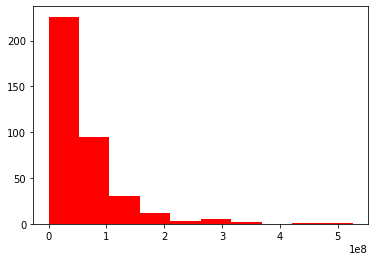

In [319]:
plt.hist(month_aug_18['DAILY_ENTRIES'], color="r");

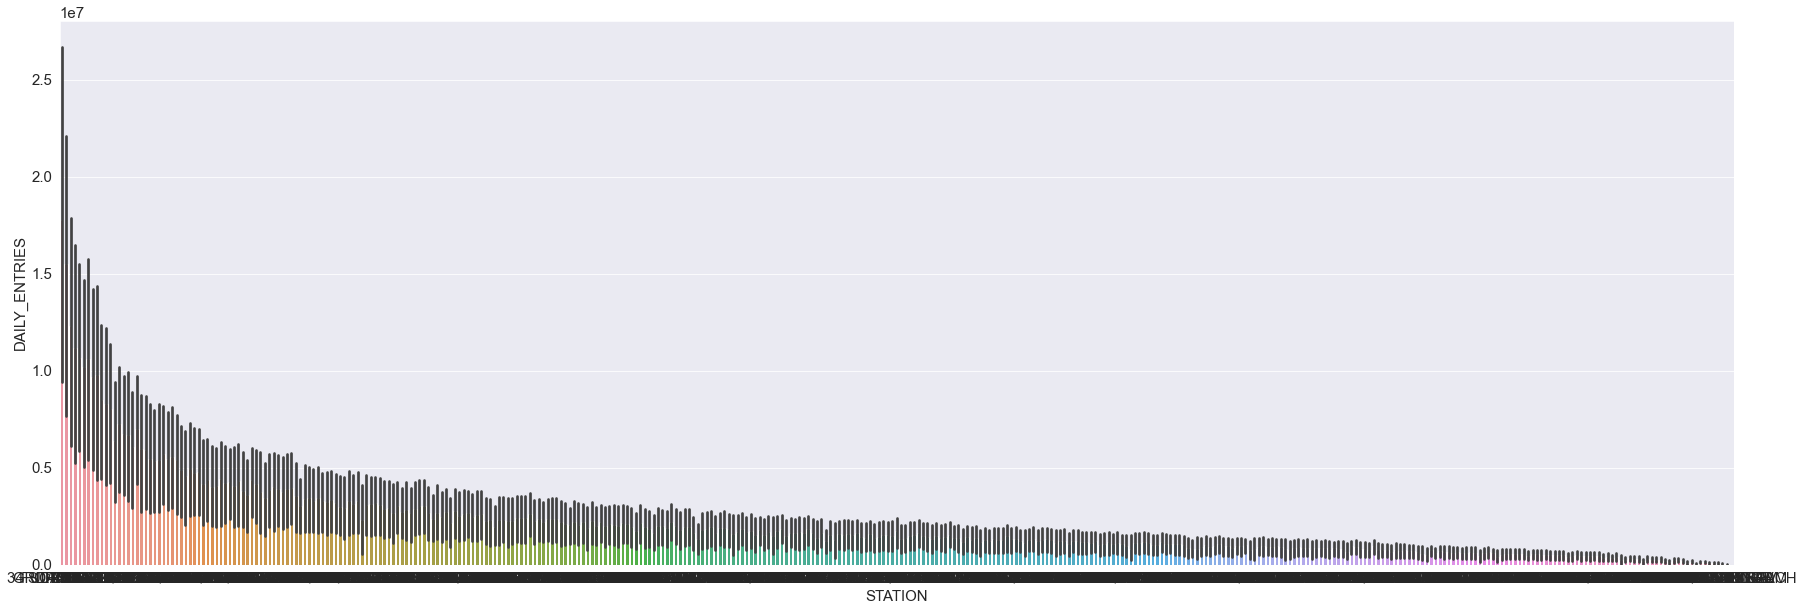

In [452]:
sns.barplot(x='STATION', y='DAILY_ENTRIES' ,data = station_mean_month);

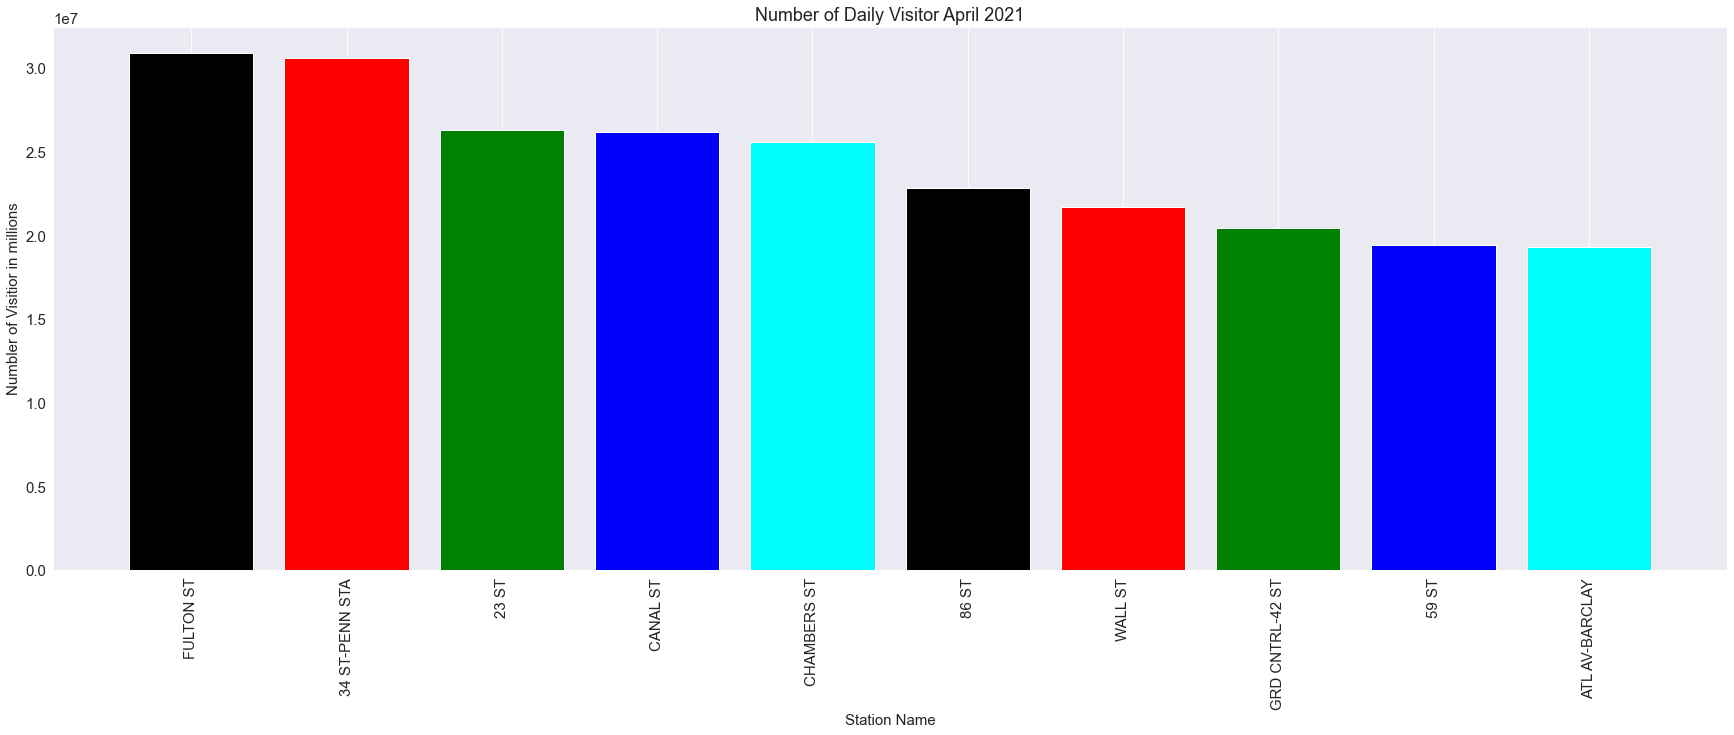

In [451]:
plt.bar(x=month_apr_18['STATION'][:10], height=station_mean_month['DAILY_ENTRIES'][:10],color=['black', 'red', 'green', 'blue', 'cyan']);
plt.xticks(rotation=90);
plt.title("Number of Daily Visitor April 2021")
plt.xlabel('Station Name')
plt.ylabel('Numbler of Visitior in millions')
plt.grid(axis='y', alpha=0.75)

In [ ]:
plt.bar(x=month_apr_18['STATION'][:10], height=month_apr_18['DAILY_ENTRIES'][:10],color=['black', 'red', 'green', 'blue', 'cyan']);
plt.xticks(rotation=90);
plt.title("Number of Daily Visitor April 2021")
plt.xlabel('Station Name')
plt.ylabel('Numbler of Visitior in millions')
plt.grid(axis='y', alpha=0.75)

In [449]:
R = month_apr_21['DAILY_ENTRIES']
R
# plt.bar(x=month_apr_21['STATION'][:10], height=month_apr_21['DAILY_ENTRIES'][:10],color=['black', 'red', 'green', 'blue', 'cyan']);
# plt.xticks(rotation=90);
# plt.title("Number of Daily Visitor April 2021")
# plt.xlabel('Station Name')
# plt.ylabel('Numbler of Visitior in millions')
# plt.grid(axis='y', alpha=0.75)

14      298873331.0
20      277015587.0
31      204710450.0
41      186352996.0
43      185806527.0
           ...     
2308        29592.0
2324        24358.0
2333        23093.0
2336        22965.0
2364        18336.0
Name: DAILY_ENTRIES, Length: 378, dtype: float64

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

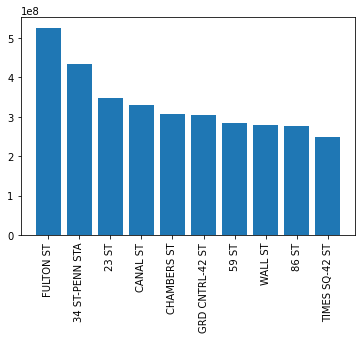

In [336]:
plt.bar(x=month_aug_18['STATION'][:10], height=month_aug_18['DAILY_ENTRIES'][:10]);
plt.xticks(rotation=90)

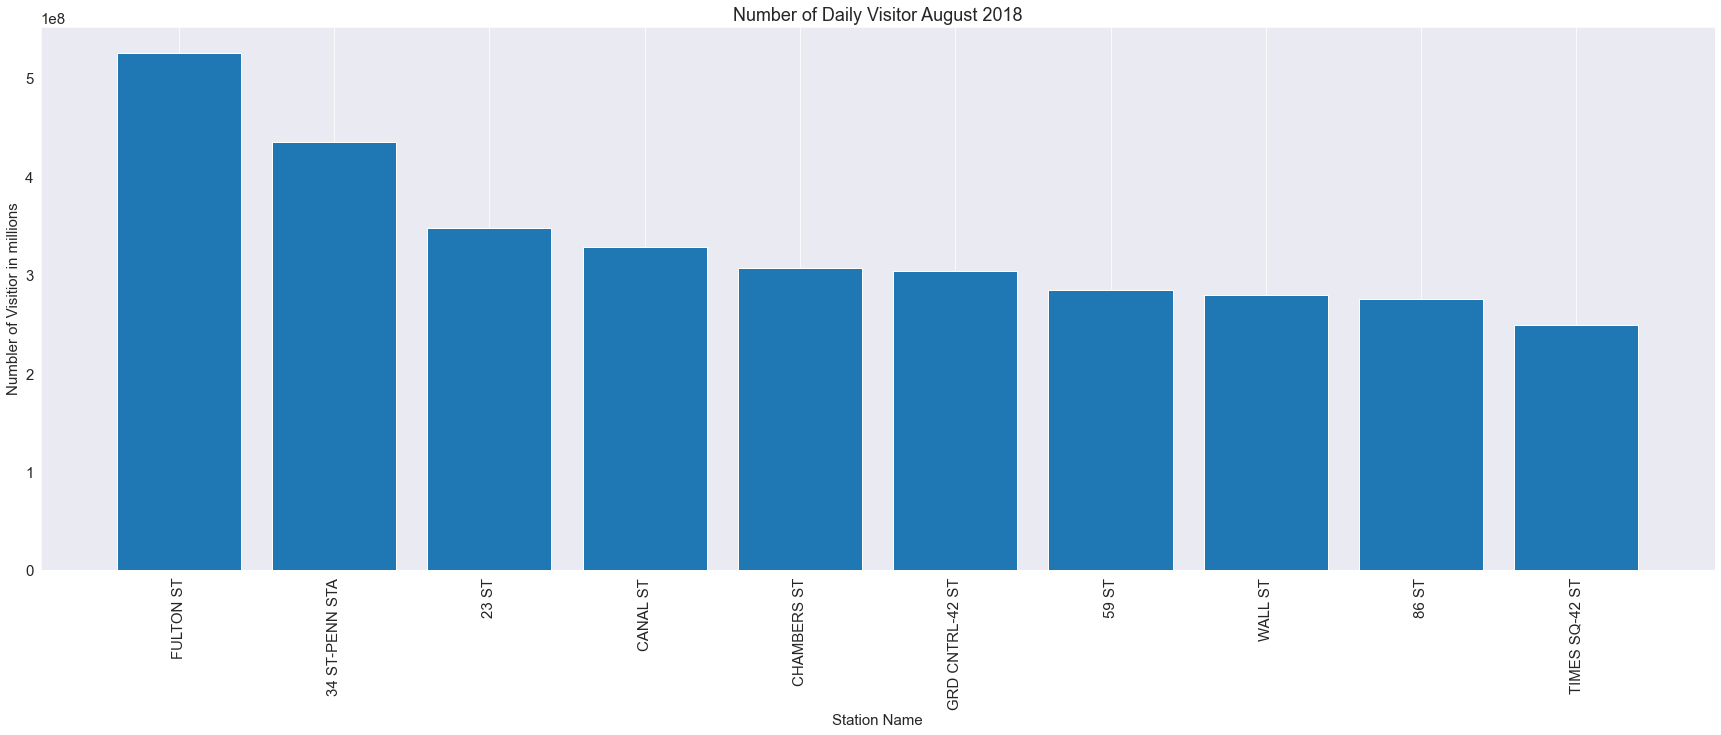

In [402]:
plt.bar(x=month_aug_18['STATION'][:10], height=month_aug_18['DAILY_ENTRIES'][:10]);
plt.xticks(rotation=90)
plt.title("Number of Daily Visitor August 2018")
plt.xlabel('Station Name')
plt.ylabel('Numbler of Visitior in millions')
plt.grid(axis='y', alpha=0.75)

In [346]:
station_totals = each_station[['STATION','DAILY_ENTRIES']].groupby('STATION').sum()\
    .sort_values('DAILY_ENTRIES', ascending=False)\
    .reset_index()
station_totals.head()

,STATION,DAILY_ENTRIES
0,FULTON ST,1.718459e+09
1,34 ST-PENN STA,1.489362e+09
2,23 ST,1.156177e+09
3,CANAL ST,1.075698e+09
4,CHAMBERS ST,1.028029e+09


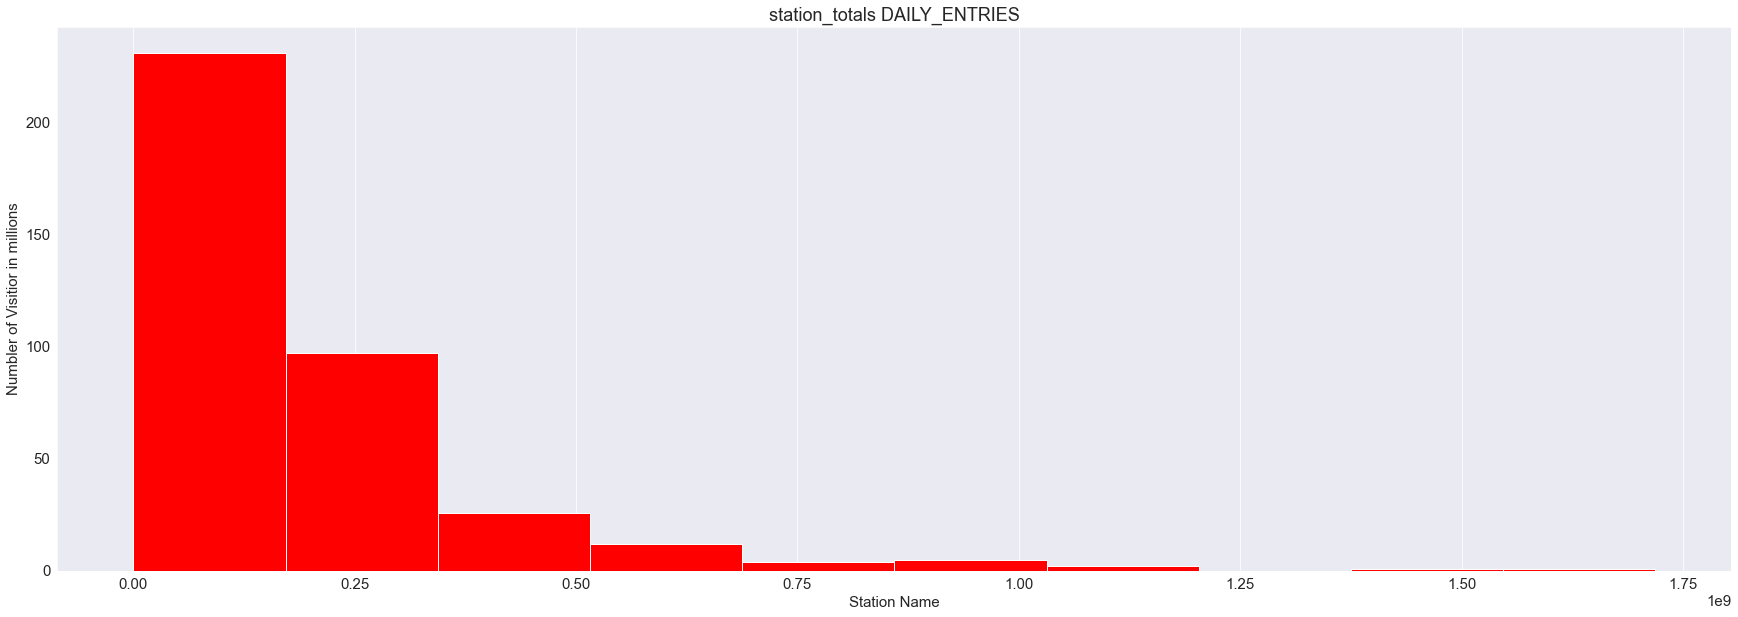

In [401]:
plt.hist(station_totals['DAILY_ENTRIES'], color="r");
plt.title("station_totals DAILY_ENTRIES")
plt.xlabel('Station Name')
plt.ylabel('Numbler of Visitior in millions')
plt.grid(axis='y', alpha=0.75)

In [113]:
daily_df['DATE_TIME'];

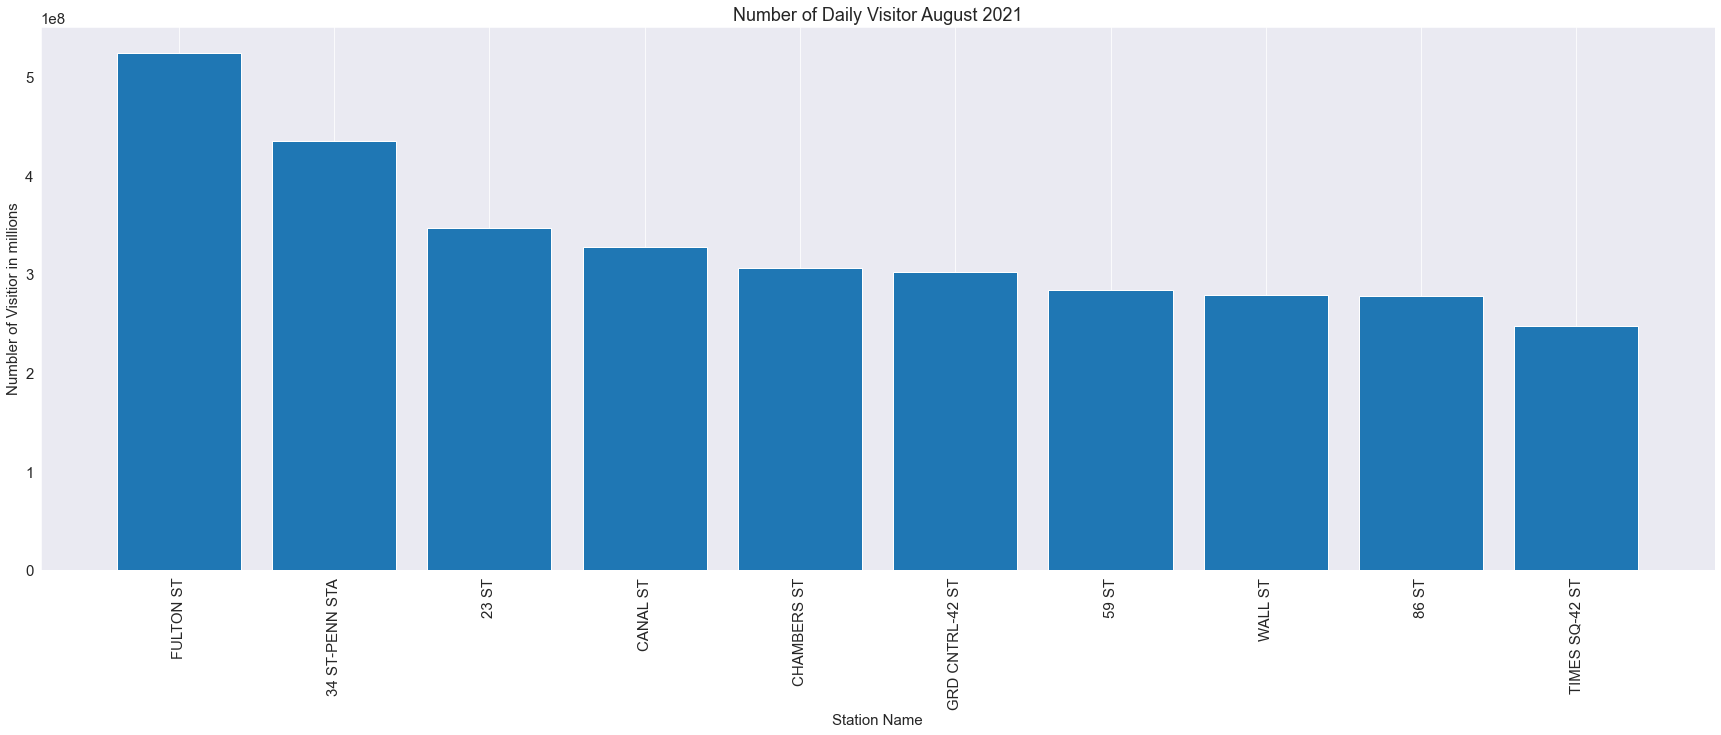

In [400]:
plt.bar(x=month_aug_21['STATION'][:10], height=month_aug_21['DAILY_ENTRIES'][:10]);
plt.xticks(rotation=90)
plt.title("Number of Daily Visitor August 2021")
plt.xlabel('Station Name')
plt.ylabel('Numbler of Visitior in millions')
plt.grid(axis='y', alpha=0.75)

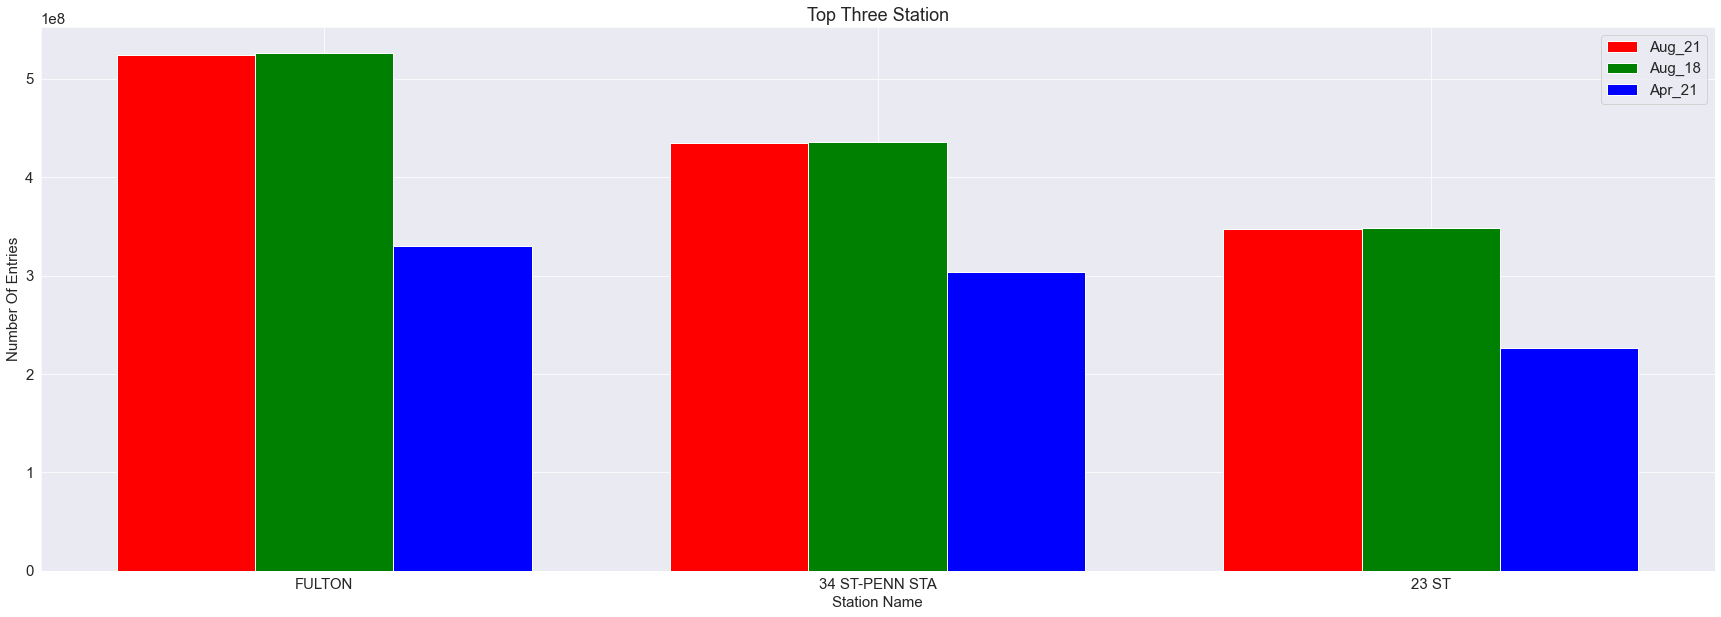

In [431]:
N = 3
ind = np.arange(N) 
width = 0.25
  
xvals = x=month_aug_21['DAILY_ENTRIES'][:3]
bar1 = plt.bar(ind, xvals, width, color = 'r',)
  
yvals = x=month_aug_18['DAILY_ENTRIES'][:3]
bar2 = plt.bar(ind+width, yvals, width, color='g')
  
zvals = x=month_apr_18['DAILY_ENTRIES'][:3]
bar3 = plt.bar(ind+width*2, zvals, width, color = 'b')
  
plt.xlabel("Station Name")
plt.ylabel('Number Of Entries')
plt.title("Top Three Station")
  
plt.xticks(ind+width,['FULTON', '34 ST-PENN STA', '23 ST'])
plt.legend( (bar1, bar2, bar3), ('Aug_21', 'Aug_18', 'Apr_21') )
plt.show()

In [ ]:
FULTON ST	1.718459e+09
1	34 ST-PENN STA	1.489362e+09
2	23 ST	1.156177e+09
3	CANAL ST	1.075698e+09
4	CHAMBERS ST	1.028029e+09

In [421]:
month_aug_21['DAILY_ENTRIES'].head()

1     524584322.0
3     434621051.0
5     347020861.0
8     328088135.0
10    306628248.0
Name: DAILY_ENTRIES, dtype: float64

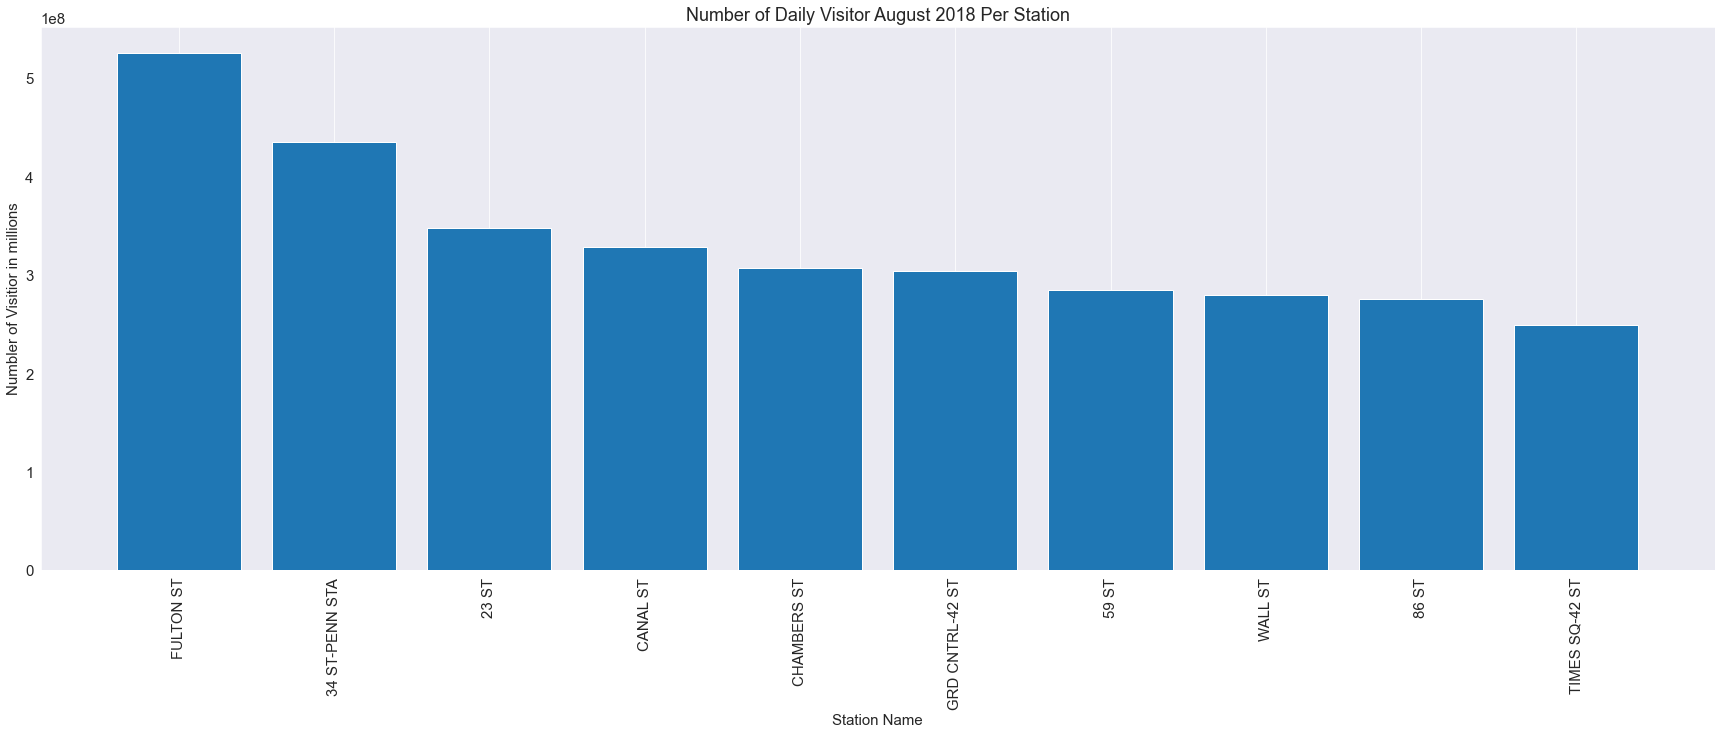

In [397]:
plt.bar(x=month_aug_18['STATION'][:10], height=month_aug_18['DAILY_ENTRIES'][:10]);
plt.xticks(rotation=90)
plt.title("Number of Daily Visitor August 2018 Per Station")
plt.xlabel('Station Name')
plt.ylabel('Numbler of Visitior in millions')
plt.grid(axis='y', alpha=0.75)

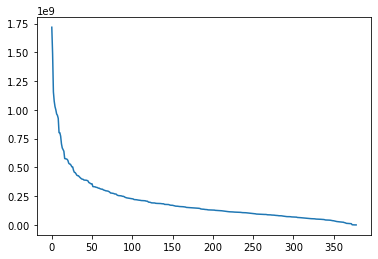

In [162]:
plt.plot(station_totals['DAILY_ENTRIES'])

In [330]:
path_to_data = geopandas.datasets.get_path("nybb")
gdf = geopandas.read_file(path_to_data)

gdf

,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry
0,5,Staten Island,330470.010332,1.623820e+09,"MULTIPOLYGON (((970217.022 145643.332, 970227...."
1,4,Queens,896344.047763,3.045213e+09,"MULTIPOLYGON (((1029606.077 156073.814, 102957..."
2,3,Brooklyn,741080.523166,1.937479e+09,"MULTIPOLYGON (((1021176.479 151374.797, 102100..."
3,1,Manhattan,359299.096471,6.364715e+08,"MULTIPOLYGON (((981219.056 188655.316, 980940...."
4,2,Bronx,464392.991824,1.186925e+09,"MULTIPOLYGON (((1012821.806 229228.265, 101278..."


In [331]:
gdf = gdf.set_index("BoroName")

In [377]:
gdf["area"] = gdf.area
gdf["area"]

BoroName
Staten Island    1.623822e+09
Queens           3.045214e+09
Brooklyn         1.937478e+09
Manhattan        6.364712e+08
Bronx            1.186926e+09
Name: area, dtype: float64

In [379]:
gdf.at[3,'area']=6.364712e+09

In [367]:
gdf.head()
# gdf.loc["Queens"].area = 636471237.966868

/Users/Ramoon50/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [368]:
# gdf.loc["Queens"].area

3045213694.323353

<AxesSubplot:>

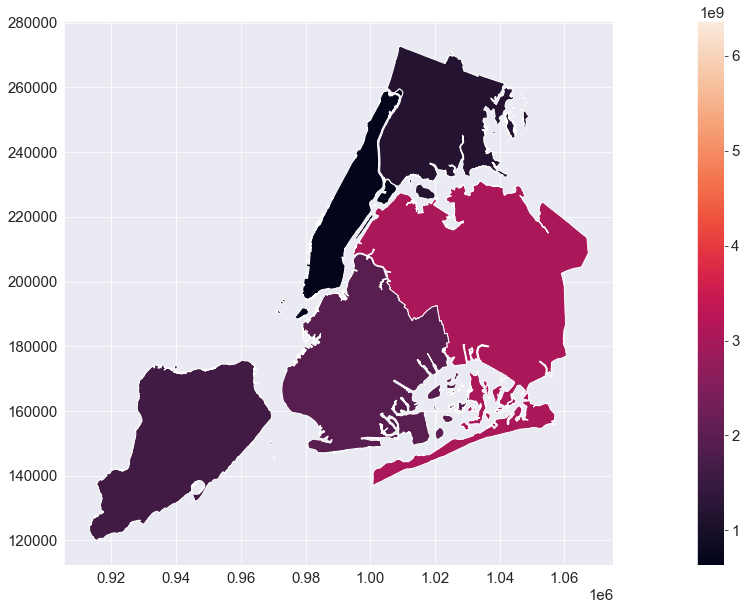

In [396]:
gdf.plot("area", legend=True, )

In [429]:
plt.rcParams["figure.figsize"] = (30,10)
plt.rcParams.update({'font.size': 15})